In [1]:
import cv2
import numpy as np
import os

In [2]:
import matplotlib.cm as cm

In [3]:
import matplotlib.pyplot as plt

In [4]:
import math

In [5]:
np.set_printoptions(threshold=np.inf)

In [6]:
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [165]:
images = []
class_ = []
path='bearing/'
for folder in os.listdir(path):
    for file in os.listdir(path+folder):
        images.append(read_image(path+folder+'/'+file))
        class_.append(folder)

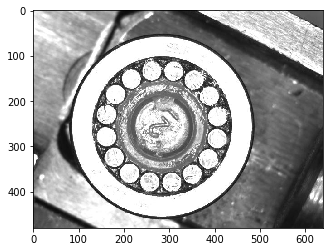

In [232]:
plt.imshow(images[0], cmap=cm.gray, vmin=0, vmax=255)

In [167]:
class_[0]

'Good'

In [125]:
image1 = read_image('1.png')

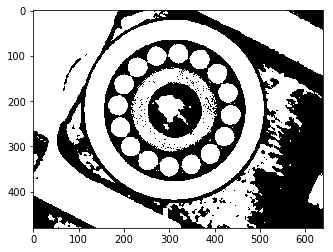

In [126]:
test = image1.copy()
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        if test[i][j]<100:
            test[i][j]=0
        else:
            test[i][j]=255
plt.imshow(test, cmap=cm.gray, vmin=0, vmax=255)

In [127]:
image = test

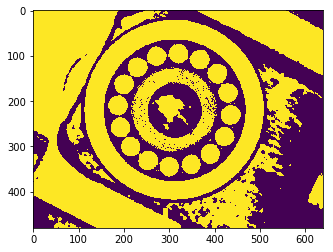

In [128]:
plt.imshow(image)

In [129]:
m = image.shape[0]
n = image.shape[1]

In [130]:
def smoothen_image(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i>0 and j>0 and i<image.shape[0]-1 and j<image.shape[1]-1:
                image[i][j] = int((image[i][j]+image[i-1][j]+image[i][j-1]+image[i+1][j]+image[i][j+1])/5)
    return image

In [131]:
def is_edge(image,x, threshold = 150):
    xi, xj = x
    if xi>0 and xj>0 and xi<image.shape[0]-1 and xj<image.shape[1]-1:
        for (i, j) in [(1,0),(0,1),(-1,0),(0,-1)]:
            if abs(image[xi+i][xj+j] - image[xi][xj])>threshold:
                    return True
    return False

In [132]:
edges = np.array([[0]*image.shape[1]]*image.shape[0])
#image = cv2.blur(image, (10,10))
for i in range(m):
    for j in range(n):
        if not is_edge(image, (i,j)):
            edges[i][j]=1

c:\users\aakasht\appdata\local\continuum\anaconda3\envs\py361\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """


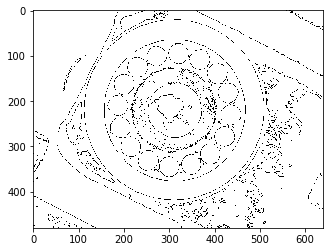

In [133]:
plt.imshow(edges, cmap=cm.gray, vmin=0, vmax=1)

In [134]:
def ecl_dist(x,y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

In [135]:
def is_center(A,B,error_pixel=3):
    C = (B[0],A[1])
    if abs(ecl_dist(A,C)-ecl_dist(B,C)) < error_pixel:
        return True
    return False

In [136]:
def is_an_edge(image, x, error):
    for i in range(-error,error+1):
        for j in range(-error,error+1):
            
            if x[0]+i>=0 and x[0]+i<image.shape[0] and x[1]+j>=0 and x[1]+j<image.shape[1] and image[x[0]+i][x[1]+j] == 0:
                return True
    return False

In [137]:
def is_circle(image, C, R, error = 1, threshold = 0.9):
    colored = 0
    total = 0
    degree = 0
    while degree<360:
        xi = round(C[0]+R*math.cos(degree * math.pi / 180))
        xj = round(C[1]+R*math.sin(degree * math.pi / 180))
        if is_an_edge(image, (xi,xj), error):
            colored+=1
        total+=1
        if colored/total<threshold:
            return False
        degree+=0.01
    return True

In [145]:
def draw_bounding_box(image, C_, R_):
    bounded = image.copy()
    for k in range(len(C_)):
        C = C_[k]
        R = int(R_[k])
        for i in range(C[0]-R, C[0]+R):
            for j in [C[1]-R, C[1]+R]:
                bounded[i][j] = 0
                bounded[i][j+1] = 0
        for j in range(C[1]-R, C[1]+R):
            for i in [C[0]-R, C[0]+R]:
                bounded[i][j] = 0
                bounded[i+1][j] = 0
    return bounded

In [139]:
def get_black_pixels(image):
    indexes = []
    maxlen = 0
    for i in range(image.shape[0]):
        index = []
        for j in range(image.shape[1]):
            if image[i][j]==0:
                index.append(j)
        indexes.append(index)
        maxlen = max(maxlen, len(index))
    
    indexes1 = np.array([[-1]*maxlen]*image.shape[0])
    
    for i in range(len(indexes)):
        for j in range(len(indexes[i])):
            indexes1[i][j] = indexes[i][j]
    
    return indexes1

In [147]:
### Here A and B are in straight line
def find_circle(image):
    m = image.shape[0]
    n = image.shape[1]
    max_R = []
    max_C = []
    max_circum = None
    count = 0
    dark_pixels = get_black_pixels(image)
    for i in range(dark_pixels.shape[0]):
        for ind in range(dark_pixels[i].shape[0]-1):
            j = dark_pixels[i][ind]
            if j == -1:
                break
            for ind1 in range(ind+1,dark_pixels[i].shape[0]):
                k = dark_pixels[i][ind1]
                if k == -1:
                    break
                if k-j < min(image.shape[0], image.shape[1])/5:
                    continue
                #print((i,j),(i,k))
                count+=1
#                 if count%1000:
#                     print(count)
                C = (i, int((j+k)/2))
                R = ecl_dist((i,j),C)
                print(C,R)
                if is_circle(image, C, R, error= 1, threshold=0.3):
                    max_R.append(R)
                    max_C.append(C)
#                     if R>max_R:
#                         max_R = R
#                         max_C = C
    return max_R, max_C

In [148]:
max_R, max_C = find_circle(edges)

(1, 274) 85.0
(1, 374) 185.0
(1, 377) 188.0
(1, 378) 189.0
(1, 381) 192.0
(1, 302) 57.0
(1, 402) 157.0
(1, 405) 160.0
(1, 406) 161.0
(1, 409) 164.0
(1, 303) 57.0
(1, 402) 156.0
(1, 406) 160.0
(1, 407) 161.0
(1, 409) 163.0
(1, 303) 56.0
(1, 403) 156.0
(1, 406) 159.0
(1, 407) 160.0
(1, 410) 163.0
(1, 413) 146.0
(1, 416) 149.0
(1, 417) 150.0
(1, 420) 153.0
(1, 415) 144.0
(1, 418) 147.0
(1, 419) 148.0
(1, 422) 151.0
(1, 415) 143.0
(1, 419) 147.0
(1, 420) 148.0
(1, 422) 150.0
(1, 416) 143.0
(1, 419) 146.0
(1, 420) 147.0
(1, 423) 150.0
(1, 418) 140.0
(1, 422) 144.0
(1, 423) 145.0
(1, 425) 147.0
(1, 419) 140.0
(1, 422) 143.0
(1, 423) 144.0
(1, 426) 147.0
(1, 419) 139.0
(1, 423) 143.0
(1, 424) 144.0
(1, 426) 146.0
(1, 459) 99.0
(1, 463) 103.0
(1, 464) 104.0
(1, 466) 106.0
(2, 239) 51.0
(2, 240) 52.0
(2, 240) 52.0
(2, 241) 53.0
(2, 274) 86.0
(2, 275) 87.0
(2, 374) 186.0
(2, 374) 186.0
(2, 375) 187.0
(2, 375) 187.0
(2, 377) 189.0
(2, 378) 190.0
(2, 379) 191.0
(2, 379) 191.0
(2, 380) 192.0
(2, 30

(8, 379) 194.0
(8, 379) 194.0
(8, 381) 196.0
(8, 383) 198.0
(8, 384) 199.0
(8, 298) 74.0
(8, 398) 174.0
(8, 398) 174.0
(8, 399) 175.0
(8, 401) 177.0
(8, 402) 178.0
(8, 403) 179.0
(8, 299) 74.0
(8, 398) 173.0
(8, 399) 174.0
(8, 399) 174.0
(8, 401) 176.0
(8, 403) 178.0
(8, 404) 179.0
(8, 321) 52.0
(8, 420) 151.0
(8, 421) 152.0
(8, 421) 152.0
(8, 423) 154.0
(8, 425) 156.0
(8, 426) 157.0
(8, 323) 50.0
(8, 422) 149.0
(8, 423) 150.0
(8, 423) 150.0
(8, 425) 152.0
(8, 427) 154.0
(8, 428) 155.0
(8, 323) 49.0
(8, 423) 149.0
(8, 423) 149.0
(8, 424) 150.0
(8, 426) 152.0
(8, 427) 153.0
(8, 428) 154.0
(8, 425) 146.0
(8, 426) 147.0
(8, 426) 147.0
(8, 428) 149.0
(8, 430) 151.0
(8, 431) 152.0
(8, 426) 145.0
(8, 427) 146.0
(8, 427) 146.0
(8, 429) 148.0
(8, 431) 150.0
(8, 432) 151.0
(8, 427) 145.0
(8, 427) 145.0
(8, 428) 146.0
(8, 430) 148.0
(8, 431) 149.0
(8, 432) 150.0
(8, 427) 144.0
(8, 428) 145.0
(8, 428) 145.0
(8, 430) 147.0
(8, 432) 149.0
(8, 433) 150.0
(8, 428) 144.0
(8, 428) 144.0
(8, 429) 145.0


(16, 337) 51.0
(16, 437) 151.0
(16, 437) 151.0
(16, 440) 154.0
(16, 442) 156.0
(16, 337) 50.0
(16, 338) 51.0
(16, 437) 150.0
(16, 438) 151.0
(16, 440) 153.0
(16, 442) 155.0
(16, 338) 50.0
(16, 338) 50.0
(16, 438) 150.0
(16, 438) 150.0
(16, 441) 153.0
(16, 443) 155.0
(16, 338) 49.0
(16, 339) 50.0
(16, 438) 149.0
(16, 439) 150.0
(16, 441) 152.0
(16, 443) 154.0
(16, 339) 49.0
(16, 339) 49.0
(16, 439) 149.0
(16, 439) 149.0
(16, 442) 152.0
(16, 444) 154.0
(16, 339) 48.0
(16, 340) 49.0
(16, 439) 148.0
(16, 440) 149.0
(16, 442) 151.0
(16, 444) 153.0
(16, 488) 100.0
(16, 488) 100.0
(16, 491) 103.0
(16, 493) 105.0
(16, 488) 99.0
(16, 489) 100.0
(16, 491) 102.0
(16, 493) 104.0
(17, 229) 48.0
(17, 285) 104.0
(17, 286) 105.0
(17, 385) 204.0
(17, 387) 206.0
(17, 388) 207.0
(17, 389) 208.0
(17, 390) 209.0
(17, 294) 96.0
(17, 294) 96.0
(17, 394) 196.0
(17, 395) 197.0
(17, 396) 198.0
(17, 397) 199.0
(17, 398) 200.0
(17, 329) 61.0
(17, 329) 61.0
(17, 429) 161.0
(17, 430) 162.0
(17, 431) 163.0
(17, 432)

(23, 470) 129.0
(23, 471) 130.0
(23, 471) 130.0
(23, 472) 131.0
(23, 471) 129.0
(23, 471) 129.0
(23, 472) 130.0
(23, 472) 130.0
(23, 501) 98.0
(23, 502) 99.0
(23, 502) 99.0
(23, 503) 100.0
(23, 502) 98.0
(23, 502) 98.0
(23, 503) 99.0
(23, 503) 99.0
(23, 502) 97.0
(23, 503) 98.0
(23, 503) 98.0
(23, 504) 99.0
(24, 227) 48.0
(24, 227) 48.0
(24, 228) 49.0
(24, 228) 49.0
(24, 229) 50.0
(24, 261) 82.0
(24, 261) 82.0
(24, 262) 83.0
(24, 262) 83.0
(24, 263) 84.0
(24, 292) 113.0
(24, 293) 114.0
(24, 391) 212.0
(24, 392) 213.0
(24, 392) 213.0
(24, 268) 75.0
(24, 268) 75.0
(24, 269) 76.0
(24, 269) 76.0
(24, 270) 77.0
(24, 299) 106.0
(24, 300) 107.0
(24, 398) 205.0
(24, 399) 206.0
(24, 399) 206.0
(24, 293) 50.0
(24, 293) 50.0
(24, 294) 51.0
(24, 294) 51.0
(24, 295) 52.0
(24, 324) 81.0
(24, 325) 82.0
(24, 423) 180.0
(24, 424) 181.0
(24, 424) 181.0
(24, 293) 49.0
(24, 294) 50.0
(24, 294) 50.0
(24, 295) 51.0
(24, 295) 51.0
(24, 325) 81.0
(24, 325) 81.0
(24, 424) 180.0
(24, 424) 180.0
(24, 425) 181.0


(33, 332) 89.0
(33, 332) 89.0
(33, 333) 90.0
(33, 431) 188.0
(33, 311) 67.0
(33, 311) 67.0
(33, 312) 68.0
(33, 332) 88.0
(33, 333) 89.0
(33, 333) 89.0
(33, 431) 187.0
(33, 498) 120.0
(33, 499) 120.0
(33, 499) 119.0
(33, 520) 99.0
(33, 520) 98.0
(33, 521) 98.0
(34, 279) 102.0
(34, 279) 102.0
(34, 300) 123.0
(34, 301) 124.0
(34, 301) 124.0
(34, 398) 221.0
(34, 399) 222.0
(34, 287) 93.0
(34, 288) 94.0
(34, 309) 115.0
(34, 309) 115.0
(34, 310) 116.0
(34, 407) 213.0
(34, 407) 213.0
(34, 303) 78.0
(34, 303) 78.0
(34, 324) 99.0
(34, 325) 100.0
(34, 325) 100.0
(34, 422) 197.0
(34, 423) 198.0
(34, 303) 77.0
(34, 304) 78.0
(34, 325) 99.0
(34, 325) 99.0
(34, 326) 100.0
(34, 423) 197.0
(34, 423) 197.0
(34, 310) 71.0
(34, 310) 71.0
(34, 331) 92.0
(34, 332) 93.0
(34, 332) 93.0
(34, 429) 190.0
(34, 430) 191.0
(34, 310) 70.0
(34, 311) 71.0
(34, 332) 92.0
(34, 332) 92.0
(34, 333) 93.0
(34, 430) 190.0
(34, 430) 190.0
(34, 311) 70.0
(34, 311) 70.0
(34, 332) 91.0
(34, 333) 92.0
(34, 333) 92.0
(34, 430) 18

(41, 311) 87.0
(41, 332) 108.0
(41, 333) 109.0
(41, 429) 205.0
(41, 430) 206.0
(41, 516) 119.0
(41, 516) 119.0
(41, 516) 118.0
(41, 517) 119.0
(41, 517) 118.0
(41, 517) 118.0
(41, 538) 97.0
(41, 538) 97.0
(41, 538) 96.0
(41, 539) 97.0
(42, 286) 113.0
(42, 287) 114.0
(42, 308) 135.0
(42, 308) 135.0
(42, 405) 232.0
(42, 405) 232.0
(42, 291) 108.0
(42, 292) 109.0
(42, 313) 130.0
(42, 313) 130.0
(42, 410) 227.0
(42, 410) 227.0
(42, 305) 95.0
(42, 305) 95.0
(42, 326) 116.0
(42, 327) 117.0
(42, 423) 213.0
(42, 424) 214.0
(42, 305) 94.0
(42, 306) 95.0
(42, 327) 116.0
(42, 327) 116.0
(42, 424) 213.0
(42, 424) 213.0
(42, 310) 89.0
(42, 311) 90.0
(42, 332) 111.0
(42, 332) 111.0
(42, 429) 208.0
(42, 429) 208.0
(42, 311) 89.0
(42, 311) 89.0
(42, 332) 110.0
(42, 333) 111.0
(42, 429) 207.0
(42, 430) 208.0
(42, 518) 118.0
(42, 519) 119.0
(42, 519) 118.0
(42, 519) 118.0
(42, 540) 97.0
(42, 540) 97.0
(42, 540) 96.0
(42, 541) 97.0
(43, 287) 114.0
(43, 309) 136.0
(43, 309) 136.0
(43, 310) 137.0
(43, 292)

(65, 250) 73.0
(65, 251) 74.0
(65, 251) 74.0
(65, 252) 75.0
(65, 306) 129.0
(65, 331) 154.0
(65, 332) 155.0
(65, 240) 54.0
(65, 241) 55.0
(65, 241) 55.0
(65, 242) 56.0
(65, 242) 56.0
(65, 243) 57.0
(65, 243) 57.0
(65, 244) 58.0
(65, 244) 58.0
(65, 245) 59.0
(65, 245) 59.0
(65, 246) 60.0
(65, 246) 60.0
(65, 247) 61.0
(65, 247) 61.0
(65, 248) 62.0
(65, 248) 62.0
(65, 249) 63.0
(65, 249) 63.0
(65, 250) 64.0
(65, 250) 64.0
(65, 251) 65.0
(65, 251) 65.0
(65, 252) 66.0
(65, 252) 66.0
(65, 253) 67.0
(65, 253) 67.0
(65, 254) 68.0
(65, 254) 68.0
(65, 255) 69.0
(65, 255) 69.0
(65, 256) 70.0
(65, 256) 70.0
(65, 310) 124.0
(65, 336) 150.0
(65, 336) 150.0
(65, 365) 70.0
(65, 390) 95.0
(65, 391) 96.0
(65, 365) 69.0
(65, 391) 95.0
(65, 391) 95.0
(65, 366) 69.0
(65, 391) 94.0
(65, 392) 95.0
(65, 366) 68.0
(65, 392) 94.0
(65, 392) 94.0
(65, 367) 68.0
(65, 392) 93.0
(65, 393) 94.0
(65, 367) 67.0
(65, 393) 93.0
(65, 393) 93.0
(65, 368) 67.0
(65, 393) 92.0
(65, 394) 93.0
(65, 368) 66.0
(65, 394) 92.0
(65,

(73, 246) 69.0
(73, 246) 69.0
(73, 247) 70.0
(73, 247) 70.0
(73, 248) 71.0
(73, 249) 72.0
(73, 249) 72.0
(73, 250) 73.0
(73, 251) 74.0
(73, 269) 92.0
(73, 269) 92.0
(73, 270) 93.0
(73, 311) 134.0
(73, 339) 162.0
(73, 340) 163.0
(73, 311) 50.0
(73, 311) 50.0
(73, 312) 51.0
(73, 353) 92.0
(73, 381) 120.0
(73, 382) 121.0
(73, 311) 49.0
(73, 312) 50.0
(73, 312) 50.0
(73, 353) 91.0
(73, 382) 120.0
(73, 382) 120.0
(73, 312) 49.0
(73, 312) 49.0
(73, 313) 50.0
(73, 354) 91.0
(73, 382) 119.0
(73, 383) 120.0
(73, 379) 65.0
(73, 408) 94.0
(73, 408) 94.0
(73, 380) 65.0
(73, 408) 93.0
(73, 409) 94.0
(73, 380) 64.0
(73, 409) 93.0
(73, 409) 93.0
(73, 381) 64.0
(73, 409) 92.0
(73, 410) 93.0
(73, 381) 63.0
(73, 410) 92.0
(73, 410) 92.0
(73, 382) 63.0
(73, 410) 91.0
(73, 411) 92.0
(73, 383) 62.0
(73, 411) 90.0
(73, 412) 91.0
(73, 383) 61.0
(73, 412) 90.0
(73, 412) 90.0
(73, 384) 61.0
(73, 412) 89.0
(73, 413) 90.0
(73, 385) 60.0
(73, 413) 88.0
(73, 414) 89.0
(73, 431) 70.0
(73, 432) 71.0
(73, 432) 70.0
(

(81, 391) 128.0
(81, 330) 51.0
(81, 330) 51.0
(81, 366) 87.0
(81, 398) 119.0
(81, 399) 120.0
(81, 330) 50.0
(81, 331) 51.0
(81, 366) 86.0
(81, 399) 119.0
(81, 399) 119.0
(81, 378) 74.0
(81, 411) 107.0
(81, 411) 107.0
(81, 394) 58.0
(81, 427) 91.0
(81, 427) 91.0
(81, 449) 68.0
(81, 450) 69.0
(81, 450) 68.0
(81, 450) 68.0
(82, 208) 54.0
(82, 217) 63.0
(82, 218) 64.0
(82, 229) 75.0
(82, 245) 91.0
(82, 268) 114.0
(82, 269) 115.0
(82, 304) 150.0
(82, 337) 183.0
(82, 224) 57.0
(82, 224) 57.0
(82, 235) 68.0
(82, 252) 85.0
(82, 275) 108.0
(82, 275) 108.0
(82, 310) 143.0
(82, 343) 176.0
(82, 288) 48.0
(82, 311) 71.0
(82, 312) 72.0
(82, 347) 107.0
(82, 380) 140.0
(82, 289) 48.0
(82, 312) 71.0
(82, 312) 71.0
(82, 347) 106.0
(82, 380) 139.0
(82, 312) 70.0
(82, 313) 71.0
(82, 348) 106.0
(82, 381) 139.0
(82, 322) 60.0
(82, 323) 61.0
(82, 358) 96.0
(82, 391) 129.0
(82, 332) 51.0
(82, 332) 51.0
(82, 367) 86.0
(82, 400) 119.0
(82, 332) 50.0
(82, 333) 51.0
(82, 368) 86.0
(82, 401) 119.0
(82, 379) 75.0
(

(91, 221) 70.0
(91, 225) 74.0
(91, 246) 95.0
(91, 253) 102.0
(91, 266) 115.0
(91, 275) 124.0
(91, 306) 155.0
(91, 343) 192.0
(91, 344) 193.0
(91, 344) 193.0
(91, 345) 194.0
(91, 225) 66.0
(91, 229) 70.0
(91, 250) 91.0
(91, 257) 98.0
(91, 270) 111.0
(91, 279) 120.0
(91, 310) 151.0
(91, 347) 188.0
(91, 348) 189.0
(91, 348) 189.0
(91, 349) 190.0
(91, 283) 58.0
(91, 290) 65.0
(91, 303) 78.0
(91, 312) 87.0
(91, 343) 118.0
(91, 380) 155.0
(91, 381) 156.0
(91, 381) 156.0
(91, 382) 157.0
(91, 284) 58.0
(91, 290) 64.0
(91, 304) 78.0
(91, 312) 86.0
(91, 344) 118.0
(91, 381) 155.0
(91, 381) 155.0
(91, 382) 156.0
(91, 382) 156.0
(91, 304) 50.0
(91, 318) 64.0
(91, 326) 72.0
(91, 358) 104.0
(91, 395) 141.0
(91, 395) 141.0
(91, 396) 142.0
(91, 396) 142.0
(91, 345) 54.0
(91, 376) 85.0
(91, 413) 122.0
(91, 414) 123.0
(91, 414) 123.0
(91, 415) 124.0
(91, 349) 49.0
(91, 381) 81.0
(91, 418) 118.0
(91, 418) 118.0
(91, 419) 119.0
(91, 419) 119.0
(91, 402) 60.0
(91, 439) 97.0
(91, 439) 97.0
(91, 440) 98.0
(9

(98, 426) 127.0
(98, 405) 63.0
(98, 446) 104.0
(98, 447) 105.0
(98, 408) 60.0
(98, 449) 101.0
(98, 450) 102.0
(98, 469) 82.0
(98, 470) 83.0
(98, 480) 71.0
(98, 481) 72.0
(99, 165) 49.0
(99, 165) 49.0
(99, 183) 67.0
(99, 205) 89.0
(99, 206) 90.0
(99, 207) 91.0
(99, 229) 113.0
(99, 232) 116.0
(99, 252) 136.0
(99, 263) 147.0
(99, 292) 176.0
(99, 334) 218.0
(99, 335) 219.0
(99, 165) 48.0
(99, 166) 49.0
(99, 184) 67.0
(99, 206) 89.0
(99, 207) 90.0
(99, 208) 91.0
(99, 229) 112.0
(99, 232) 115.0
(99, 252) 135.0
(99, 263) 146.0
(99, 293) 176.0
(99, 334) 217.0
(99, 335) 218.0
(99, 198) 52.0
(99, 220) 74.0
(99, 221) 75.0
(99, 222) 76.0
(99, 244) 98.0
(99, 247) 101.0
(99, 267) 121.0
(99, 278) 132.0
(99, 307) 161.0
(99, 349) 203.0
(99, 350) 204.0
(99, 202) 49.0
(99, 224) 71.0
(99, 225) 72.0
(99, 226) 73.0
(99, 247) 94.0
(99, 250) 97.0
(99, 270) 117.0
(99, 281) 128.0
(99, 311) 158.0
(99, 352) 199.0
(99, 353) 200.0
(99, 278) 64.0
(99, 281) 67.0
(99, 301) 87.0
(99, 312) 98.0
(99, 341) 127.0
(99, 383)

(106, 304) 85.0
(106, 318) 99.0
(106, 346) 127.0
(106, 392) 173.0
(106, 290) 51.0
(106, 291) 52.0
(106, 314) 75.0
(106, 328) 89.0
(106, 356) 117.0
(106, 402) 163.0
(106, 290) 50.0
(106, 292) 52.0
(106, 315) 75.0
(106, 329) 89.0
(106, 357) 117.0
(106, 403) 163.0
(106, 320) 69.0
(106, 334) 83.0
(106, 362) 111.0
(106, 408) 157.0
(106, 342) 48.0
(106, 356) 62.0
(106, 384) 90.0
(106, 430) 136.0
(106, 360) 58.0
(106, 388) 86.0
(106, 434) 132.0
(106, 407) 66.0
(106, 453) 112.0
(106, 409) 65.0
(106, 455) 111.0
(106, 478) 88.0
(106, 492) 74.0
(107, 152) 52.0
(107, 158) 58.0
(107, 170) 70.0
(107, 171) 71.0
(107, 175) 75.0
(107, 196) 96.0
(107, 201) 101.0
(107, 219) 119.0
(107, 220) 120.0
(107, 222) 122.0
(107, 245) 145.0
(107, 259) 159.0
(107, 287) 187.0
(107, 333) 233.0
(107, 153) 52.0
(107, 159) 58.0
(107, 171) 70.0
(107, 171) 70.0
(107, 176) 75.0
(107, 197) 96.0
(107, 201) 100.0
(107, 220) 119.0
(107, 220) 119.0
(107, 223) 122.0
(107, 245) 144.0
(107, 260) 159.0
(107, 287) 186.0
(107, 334) 23

(111, 318) 71.0
(111, 335) 88.0
(111, 362) 115.0
(111, 410) 163.0
(111, 411) 164.0
(111, 321) 69.0
(111, 337) 85.0
(111, 364) 112.0
(111, 413) 161.0
(111, 413) 161.0
(111, 341) 49.0
(111, 357) 65.0
(111, 384) 92.0
(111, 433) 141.0
(111, 433) 141.0
(111, 364) 58.0
(111, 391) 85.0
(111, 440) 134.0
(111, 440) 134.0
(111, 406) 70.0
(111, 455) 119.0
(111, 455) 119.0
(111, 411) 65.0
(111, 460) 114.0
(111, 460) 114.0
(111, 482) 92.0
(111, 482) 92.0
(111, 498) 75.0
(111, 499) 76.0
(111, 525) 48.0
(111, 526) 49.0
(112, 147) 53.0
(112, 153) 59.0
(112, 171) 77.0
(112, 171) 77.0
(112, 172) 78.0
(112, 173) 79.0
(112, 192) 98.0
(112, 200) 106.0
(112, 214) 120.0
(112, 220) 126.0
(112, 241) 147.0
(112, 259) 165.0
(112, 285) 191.0
(112, 335) 241.0
(112, 335) 241.0
(112, 338) 244.0
(112, 339) 245.0
(112, 150) 49.0
(112, 156) 55.0
(112, 174) 73.0
(112, 175) 74.0
(112, 176) 75.0
(112, 177) 76.0
(112, 196) 95.0
(112, 204) 103.0
(112, 218) 117.0
(112, 223) 122.0
(112, 245) 144.0
(112, 262) 161.0
(112, 289) 

(115, 299) 89.0
(115, 318) 108.0
(115, 344) 134.0
(115, 397) 187.0
(115, 320) 69.0
(115, 339) 88.0
(115, 365) 114.0
(115, 418) 167.0
(115, 321) 68.0
(115, 340) 87.0
(115, 366) 113.0
(115, 419) 166.0
(115, 339) 50.0
(115, 358) 69.0
(115, 384) 95.0
(115, 437) 148.0
(115, 369) 58.0
(115, 395) 84.0
(115, 448) 137.0
(115, 369) 57.0
(115, 395) 83.0
(115, 448) 136.0
(115, 379) 48.0
(115, 405) 74.0
(115, 458) 127.0
(115, 405) 73.0
(115, 458) 126.0
(115, 412) 66.0
(115, 465) 119.0
(115, 487) 98.0
(115, 506) 79.0
(115, 532) 53.0
(116, 143) 52.0
(116, 150) 59.0
(116, 171) 80.0
(116, 172) 81.0
(116, 173) 82.0
(116, 173) 82.0
(116, 189) 98.0
(116, 202) 111.0
(116, 202) 111.0
(116, 209) 118.0
(116, 210) 119.0
(116, 210) 119.0
(116, 219) 128.0
(116, 240) 149.0
(116, 259) 168.0
(116, 285) 194.0
(116, 290) 199.0
(116, 338) 247.0
(116, 339) 248.0
(116, 147) 49.0
(116, 154) 56.0
(116, 175) 77.0
(116, 175) 77.0
(116, 176) 78.0
(116, 177) 79.0
(116, 193) 95.0
(116, 205) 107.0
(116, 206) 108.0
(116, 213) 11

(118, 299) 210.0
(118, 299) 210.0
(118, 300) 211.0
(118, 339) 250.0
(118, 145) 49.0
(118, 152) 56.0
(118, 174) 78.0
(118, 177) 81.0
(118, 191) 95.0
(118, 208) 112.0
(118, 209) 113.0
(118, 221) 125.0
(118, 242) 146.0
(118, 248) 152.0
(118, 248) 152.0
(118, 249) 153.0
(118, 249) 153.0
(118, 250) 154.0
(118, 251) 155.0
(118, 252) 156.0
(118, 253) 157.0
(118, 253) 157.0
(118, 254) 158.0
(118, 262) 166.0
(118, 289) 193.0
(118, 293) 197.0
(118, 302) 206.0
(118, 303) 207.0
(118, 303) 207.0
(118, 343) 247.0
(118, 193) 59.0
(118, 196) 62.0
(118, 210) 76.0
(118, 227) 93.0
(118, 228) 94.0
(118, 240) 106.0
(118, 261) 127.0
(118, 267) 133.0
(118, 267) 133.0
(118, 268) 134.0
(118, 268) 134.0
(118, 269) 135.0
(118, 270) 136.0
(118, 271) 137.0
(118, 272) 138.0
(118, 272) 138.0
(118, 273) 139.0
(118, 281) 147.0
(118, 308) 174.0
(118, 312) 178.0
(118, 321) 187.0
(118, 322) 188.0
(118, 322) 188.0
(118, 362) 228.0
(118, 196) 56.0
(118, 199) 59.0
(118, 213) 73.0
(118, 230) 90.0
(118, 231) 91.0
(118, 243) 1

(120, 446) 49.0
(120, 452) 55.0
(120, 455) 58.0
(120, 495) 98.0
(120, 464) 49.0
(120, 504) 89.0
(120, 464) 48.0
(120, 504) 88.0
(120, 505) 87.0
(120, 506) 87.0
(120, 512) 81.0
(120, 538) 55.0
(120, 543) 50.0
(120, 544) 49.0
(121, 139) 52.0
(121, 148) 61.0
(121, 169) 82.0
(121, 174) 87.0
(121, 175) 88.0
(121, 184) 97.0
(121, 184) 97.0
(121, 218) 131.0
(121, 236) 149.0
(121, 240) 153.0
(121, 241) 154.0
(121, 252) 165.0
(121, 253) 166.0
(121, 259) 172.0
(121, 285) 198.0
(121, 290) 203.0
(121, 297) 210.0
(121, 300) 213.0
(121, 340) 253.0
(121, 341) 254.0
(121, 142) 49.0
(121, 151) 58.0
(121, 172) 79.0
(121, 177) 84.0
(121, 178) 85.0
(121, 187) 94.0
(121, 187) 94.0
(121, 221) 128.0
(121, 239) 146.0
(121, 243) 150.0
(121, 244) 151.0
(121, 255) 162.0
(121, 256) 163.0
(121, 262) 169.0
(121, 288) 195.0
(121, 293) 200.0
(121, 300) 207.0
(121, 303) 210.0
(121, 343) 250.0
(121, 344) 251.0
(121, 192) 60.0
(121, 197) 65.0
(121, 197) 65.0
(121, 206) 74.0
(121, 207) 75.0
(121, 240) 108.0
(121, 259) 12

(124, 298) 214.0
(124, 341) 257.0
(124, 140) 49.0
(124, 149) 58.0
(124, 172) 81.0
(124, 221) 130.0
(124, 237) 146.0
(124, 238) 147.0
(124, 241) 150.0
(124, 257) 166.0
(124, 263) 172.0
(124, 288) 197.0
(124, 300) 209.0
(124, 302) 211.0
(124, 344) 253.0
(124, 192) 61.0
(124, 241) 110.0
(124, 257) 126.0
(124, 258) 127.0
(124, 261) 130.0
(124, 277) 146.0
(124, 283) 152.0
(124, 308) 177.0
(124, 320) 189.0
(124, 322) 191.0
(124, 364) 233.0
(124, 195) 58.0
(124, 244) 107.0
(124, 260) 123.0
(124, 261) 124.0
(124, 264) 127.0
(124, 280) 143.0
(124, 286) 149.0
(124, 311) 174.0
(124, 323) 186.0
(124, 325) 188.0
(124, 367) 230.0
(124, 271) 81.0
(124, 287) 97.0
(124, 287) 97.0
(124, 290) 100.0
(124, 306) 116.0
(124, 312) 122.0
(124, 337) 147.0
(124, 349) 159.0
(124, 351) 161.0
(124, 394) 204.0
(124, 280) 72.0
(124, 296) 88.0
(124, 296) 88.0
(124, 299) 91.0
(124, 315) 107.0
(124, 321) 113.0
(124, 346) 138.0
(124, 358) 150.0
(124, 360) 152.0
(124, 403) 195.0
(124, 302) 49.0
(124, 318) 65.0
(124, 319) 

(126, 364) 61.0
(126, 369) 66.0
(126, 394) 91.0
(126, 401) 98.0
(126, 406) 103.0
(126, 409) 106.0
(126, 411) 108.0
(126, 411) 108.0
(126, 412) 109.0
(126, 412) 109.0
(126, 414) 111.0
(126, 452) 149.0
(126, 453) 150.0
(126, 365) 59.0
(126, 371) 65.0
(126, 396) 90.0
(126, 402) 96.0
(126, 407) 101.0
(126, 411) 105.0
(126, 412) 106.0
(126, 413) 107.0
(126, 413) 107.0
(126, 414) 108.0
(126, 415) 109.0
(126, 454) 148.0
(126, 454) 148.0
(126, 366) 58.0
(126, 372) 64.0
(126, 397) 89.0
(126, 403) 95.0
(126, 408) 100.0
(126, 412) 104.0
(126, 413) 105.0
(126, 414) 106.0
(126, 414) 106.0
(126, 415) 107.0
(126, 416) 108.0
(126, 455) 147.0
(126, 455) 147.0
(126, 368) 57.0
(126, 373) 62.0
(126, 398) 87.0
(126, 405) 94.0
(126, 410) 99.0
(126, 413) 102.0
(126, 415) 104.0
(126, 415) 104.0
(126, 416) 105.0
(126, 416) 105.0
(126, 418) 107.0
(126, 456) 145.0
(126, 457) 146.0
(126, 420) 66.0
(126, 426) 72.0
(126, 431) 77.0
(126, 435) 81.0
(126, 436) 82.0
(126, 437) 83.0
(126, 437) 83.0
(126, 438) 84.0
(126,

(127, 402) 83.0
(127, 408) 89.0
(127, 409) 90.0
(127, 414) 95.0
(127, 418) 99.0
(127, 418) 99.0
(127, 422) 103.0
(127, 461) 142.0
(127, 373) 52.0
(127, 379) 58.0
(127, 403) 82.0
(127, 409) 88.0
(127, 410) 89.0
(127, 415) 94.0
(127, 419) 98.0
(127, 419) 98.0
(127, 423) 102.0
(127, 462) 141.0
(127, 420) 65.0
(127, 426) 71.0
(127, 427) 72.0
(127, 432) 77.0
(127, 436) 81.0
(127, 436) 81.0
(127, 440) 85.0
(127, 479) 124.0
(127, 421) 65.0
(127, 427) 71.0
(127, 428) 72.0
(127, 432) 76.0
(127, 436) 80.0
(127, 437) 81.0
(127, 441) 85.0
(127, 480) 124.0
(127, 432) 53.0
(127, 438) 59.0
(127, 439) 60.0
(127, 444) 65.0
(127, 448) 69.0
(127, 448) 69.0
(127, 452) 73.0
(127, 491) 112.0
(127, 433) 53.0
(127, 439) 59.0
(127, 440) 60.0
(127, 444) 64.0
(127, 448) 68.0
(127, 449) 69.0
(127, 453) 73.0
(127, 492) 112.0
(127, 434) 52.0
(127, 440) 58.0
(127, 441) 59.0
(127, 445) 63.0
(127, 449) 67.0
(127, 450) 68.0
(127, 454) 72.0
(127, 493) 111.0
(127, 436) 49.0
(127, 442) 55.0
(127, 443) 56.0
(127, 448) 61.0

(128, 402) 95.0
(128, 403) 96.0
(128, 408) 101.0
(128, 413) 106.0
(128, 417) 110.0
(128, 417) 110.0
(128, 456) 149.0
(128, 456) 149.0
(128, 457) 150.0
(128, 368) 58.0
(128, 374) 64.0
(128, 398) 88.0
(128, 403) 93.0
(128, 404) 94.0
(128, 410) 100.0
(128, 414) 104.0
(128, 418) 108.0
(128, 419) 109.0
(128, 457) 147.0
(128, 458) 148.0
(128, 458) 148.0
(128, 373) 53.0
(128, 379) 59.0
(128, 403) 83.0
(128, 408) 88.0
(128, 409) 89.0
(128, 415) 95.0
(128, 419) 99.0
(128, 423) 103.0
(128, 424) 104.0
(128, 462) 142.0
(128, 463) 143.0
(128, 463) 143.0
(128, 374) 52.0
(128, 380) 58.0
(128, 404) 82.0
(128, 409) 87.0
(128, 410) 88.0
(128, 416) 94.0
(128, 420) 98.0
(128, 424) 102.0
(128, 425) 103.0
(128, 463) 141.0
(128, 464) 142.0
(128, 464) 142.0
(128, 376) 50.0
(128, 382) 56.0
(128, 406) 80.0
(128, 411) 85.0
(128, 412) 86.0
(128, 418) 92.0
(128, 422) 96.0
(128, 426) 100.0
(128, 427) 101.0
(128, 465) 139.0
(128, 466) 140.0
(128, 466) 140.0
(128, 376) 49.0
(128, 382) 55.0
(128, 407) 80.0
(128, 412) 

(130, 182) 101.0
(130, 183) 102.0
(130, 184) 103.0
(130, 185) 104.0
(130, 185) 104.0
(130, 186) 105.0
(130, 186) 105.0
(130, 187) 106.0
(130, 187) 106.0
(130, 188) 107.0
(130, 194) 113.0
(130, 201) 120.0
(130, 202) 121.0
(130, 202) 121.0
(130, 203) 122.0
(130, 203) 122.0
(130, 204) 123.0
(130, 205) 124.0
(130, 208) 127.0
(130, 221) 140.0
(130, 221) 140.0
(130, 222) 141.0
(130, 222) 141.0
(130, 223) 142.0
(130, 226) 145.0
(130, 226) 145.0
(130, 227) 146.0
(130, 227) 146.0
(130, 234) 153.0
(130, 254) 173.0
(130, 260) 179.0
(130, 284) 203.0
(130, 288) 207.0
(130, 290) 209.0
(130, 296) 215.0
(130, 297) 216.0
(130, 297) 216.0
(130, 306) 225.0
(130, 345) 264.0
(130, 346) 265.0
(130, 135) 50.0
(130, 147) 62.0
(130, 168) 83.0
(130, 184) 99.0
(130, 184) 99.0
(130, 185) 100.0
(130, 186) 101.0
(130, 187) 102.0
(130, 187) 102.0
(130, 188) 103.0
(130, 188) 103.0
(130, 189) 104.0
(130, 189) 104.0
(130, 190) 105.0
(130, 196) 111.0
(130, 203) 118.0
(130, 204) 119.0
(130, 204) 119.0
(130, 205) 120.0
(1

(130, 431) 57.0
(130, 435) 61.0
(130, 437) 63.0
(130, 442) 68.0
(130, 443) 69.0
(130, 444) 70.0
(130, 452) 78.0
(130, 492) 118.0
(130, 492) 118.0
(130, 437) 50.0
(130, 441) 54.0
(130, 443) 56.0
(130, 449) 62.0
(130, 450) 63.0
(130, 450) 63.0
(130, 459) 72.0
(130, 498) 111.0
(130, 499) 112.0
(130, 479) 52.0
(130, 518) 91.0
(130, 519) 92.0
(130, 524) 85.0
(130, 525) 86.0
(130, 549) 61.0
(130, 549) 61.0
(130, 553) 57.0
(130, 553) 57.0
(130, 555) 55.0
(130, 555) 55.0
(130, 560) 49.0
(130, 561) 50.0
(130, 561) 48.0
(130, 562) 49.0
(130, 562) 48.0
(130, 562) 48.0
(131, 133) 52.0
(131, 145) 64.0
(131, 166) 85.0
(131, 181) 100.0
(131, 183) 102.0
(131, 184) 103.0
(131, 184) 103.0
(131, 185) 104.0
(131, 204) 123.0
(131, 205) 124.0
(131, 206) 125.0
(131, 208) 127.0
(131, 210) 129.0
(131, 223) 142.0
(131, 224) 143.0
(131, 224) 143.0
(131, 225) 144.0
(131, 225) 144.0
(131, 233) 152.0
(131, 254) 173.0
(131, 260) 179.0
(131, 284) 203.0
(131, 288) 207.0
(131, 290) 209.0
(131, 291) 210.0
(131, 296) 215

(132, 308) 181.0
(132, 312) 185.0
(132, 314) 187.0
(132, 320) 193.0
(132, 325) 198.0
(132, 326) 199.0
(132, 330) 203.0
(132, 370) 243.0
(132, 192) 59.0
(132, 207) 74.0
(132, 209) 76.0
(132, 209) 76.0
(132, 228) 95.0
(132, 228) 95.0
(132, 230) 97.0
(132, 230) 97.0
(132, 232) 99.0
(132, 233) 100.0
(132, 233) 100.0
(132, 234) 101.0
(132, 236) 103.0
(132, 237) 104.0
(132, 238) 105.0
(132, 259) 126.0
(132, 280) 147.0
(132, 286) 153.0
(132, 311) 178.0
(132, 315) 182.0
(132, 317) 184.0
(132, 323) 190.0
(132, 328) 195.0
(132, 329) 196.0
(132, 333) 200.0
(132, 373) 240.0
(132, 233) 49.0
(132, 234) 50.0
(132, 235) 51.0
(132, 253) 69.0
(132, 254) 70.0
(132, 255) 71.0
(132, 256) 72.0
(132, 258) 74.0
(132, 258) 74.0
(132, 259) 75.0
(132, 260) 76.0
(132, 261) 77.0
(132, 262) 78.0
(132, 264) 80.0
(132, 285) 101.0
(132, 306) 122.0
(132, 312) 128.0
(132, 336) 152.0
(132, 340) 156.0
(132, 343) 159.0
(132, 349) 165.0
(132, 354) 170.0
(132, 354) 170.0
(132, 359) 175.0
(132, 399) 215.0
(132, 266) 57.0
(132

(133, 387) 53.0
(133, 412) 78.0
(133, 415) 81.0
(133, 418) 84.0
(133, 424) 90.0
(133, 429) 95.0
(133, 434) 100.0
(133, 435) 101.0
(133, 474) 140.0
(133, 475) 141.0
(133, 388) 53.0
(133, 412) 77.0
(133, 416) 81.0
(133, 419) 84.0
(133, 424) 89.0
(133, 430) 95.0
(133, 435) 100.0
(133, 435) 100.0
(133, 475) 140.0
(133, 475) 140.0
(133, 389) 52.0
(133, 413) 76.0
(133, 417) 80.0
(133, 420) 83.0
(133, 425) 88.0
(133, 431) 94.0
(133, 436) 99.0
(133, 436) 99.0
(133, 476) 139.0
(133, 476) 139.0
(133, 390) 51.0
(133, 414) 75.0
(133, 418) 79.0
(133, 421) 82.0
(133, 426) 87.0
(133, 432) 93.0
(133, 437) 98.0
(133, 437) 98.0
(133, 477) 138.0
(133, 477) 138.0
(133, 391) 49.0
(133, 416) 74.0
(133, 419) 77.0
(133, 422) 80.0
(133, 428) 86.0
(133, 433) 91.0
(133, 438) 96.0
(133, 439) 97.0
(133, 478) 136.0
(133, 479) 137.0
(133, 392) 49.0
(133, 416) 73.0
(133, 420) 77.0
(133, 423) 80.0
(133, 428) 85.0
(133, 434) 91.0
(133, 439) 96.0
(133, 439) 96.0
(133, 479) 136.0
(133, 479) 136.0
(133, 393) 48.0
(133, 41

(135, 199) 74.0
(135, 200) 75.0
(135, 200) 75.0
(135, 212) 87.0
(135, 224) 99.0
(135, 224) 99.0
(135, 225) 100.0
(135, 226) 101.0
(135, 226) 101.0
(135, 228) 103.0
(135, 228) 103.0
(135, 229) 104.0
(135, 233) 108.0
(135, 233) 108.0
(135, 234) 109.0
(135, 235) 110.0
(135, 239) 114.0
(135, 255) 130.0
(135, 276) 151.0
(135, 284) 159.0
(135, 308) 183.0
(135, 311) 186.0
(135, 314) 189.0
(135, 315) 190.0
(135, 316) 191.0
(135, 316) 191.0
(135, 317) 192.0
(135, 317) 192.0
(135, 318) 193.0
(135, 319) 194.0
(135, 319) 194.0
(135, 326) 201.0
(135, 331) 206.0
(135, 372) 247.0
(135, 372) 247.0
(135, 190) 59.0
(135, 200) 69.0
(135, 201) 70.0
(135, 202) 71.0
(135, 202) 71.0
(135, 203) 72.0
(135, 203) 72.0
(135, 215) 84.0
(135, 227) 96.0
(135, 227) 96.0
(135, 228) 97.0
(135, 229) 98.0
(135, 229) 98.0
(135, 231) 100.0
(135, 231) 100.0
(135, 232) 101.0
(135, 236) 105.0
(135, 236) 105.0
(135, 237) 106.0
(135, 238) 107.0
(135, 242) 111.0
(135, 258) 127.0
(135, 279) 148.0
(135, 287) 156.0
(135, 311) 180.0

(135, 446) 61.0
(135, 446) 61.0
(135, 447) 62.0
(135, 447) 62.0
(135, 448) 63.0
(135, 449) 64.0
(135, 449) 64.0
(135, 456) 71.0
(135, 461) 76.0
(135, 502) 117.0
(135, 502) 117.0
(135, 478) 50.0
(135, 483) 55.0
(135, 523) 95.0
(135, 524) 96.0
(135, 531) 88.0
(135, 531) 88.0
(135, 555) 64.0
(135, 555) 64.0
(135, 558) 60.0
(135, 559) 61.0
(135, 561) 58.0
(135, 561) 58.0
(135, 562) 56.0
(135, 563) 57.0
(135, 563) 56.0
(135, 563) 56.0
(135, 563) 55.0
(135, 564) 56.0
(135, 564) 55.0
(135, 564) 55.0
(135, 564) 54.0
(135, 565) 55.0
(135, 565) 54.0
(135, 565) 54.0
(135, 566) 53.0
(135, 566) 53.0
(135, 566) 52.0
(135, 567) 53.0
(136, 130) 51.0
(136, 145) 66.0
(136, 164) 85.0
(136, 173) 94.0
(136, 175) 96.0
(136, 175) 96.0
(136, 177) 98.0
(136, 202) 123.0
(136, 204) 125.0
(136, 208) 129.0
(136, 209) 130.0
(136, 212) 133.0
(136, 213) 134.0
(136, 216) 137.0
(136, 217) 138.0
(136, 232) 153.0
(136, 254) 175.0
(136, 261) 182.0
(136, 285) 206.0
(136, 288) 209.0
(136, 290) 211.0
(136, 295) 216.0
(136, 3

(137, 446) 93.0
(137, 447) 94.0
(137, 451) 98.0
(137, 488) 135.0
(137, 423) 68.0
(137, 427) 72.0
(137, 447) 92.0
(137, 448) 93.0
(137, 452) 97.0
(137, 489) 134.0
(137, 424) 67.0
(137, 428) 71.0
(137, 448) 91.0
(137, 449) 92.0
(137, 453) 96.0
(137, 490) 133.0
(137, 437) 53.0
(137, 441) 57.0
(137, 462) 78.0
(137, 462) 78.0
(137, 467) 83.0
(137, 504) 120.0
(137, 484) 55.0
(137, 485) 56.0
(137, 489) 60.0
(137, 526) 97.0
(137, 492) 48.0
(137, 492) 48.0
(137, 497) 53.0
(137, 534) 90.0
(137, 557) 66.0
(137, 561) 62.0
(138, 129) 50.0
(138, 145) 66.0
(138, 164) 85.0
(138, 170) 91.0
(138, 171) 92.0
(138, 173) 94.0
(138, 174) 95.0
(138, 206) 127.0
(138, 215) 136.0
(138, 216) 137.0
(138, 217) 138.0
(138, 217) 138.0
(138, 218) 139.0
(138, 231) 152.0
(138, 254) 175.0
(138, 261) 182.0
(138, 285) 206.0
(138, 289) 210.0
(138, 291) 212.0
(138, 310) 231.0
(138, 313) 234.0
(138, 314) 235.0
(138, 315) 236.0
(138, 315) 236.0
(138, 352) 273.0
(138, 352) 273.0
(138, 186) 62.0
(138, 193) 69.0
(138, 194) 70.0
(

(139, 563) 63.0
(139, 564) 64.0
(140, 127) 51.0
(140, 145) 69.0
(140, 161) 85.0
(140, 167) 91.0
(140, 169) 93.0
(140, 169) 93.0
(140, 170) 94.0
(140, 172) 96.0
(140, 197) 121.0
(140, 205) 129.0
(140, 218) 142.0
(140, 230) 154.0
(140, 252) 176.0
(140, 260) 184.0
(140, 284) 208.0
(140, 288) 212.0
(140, 315) 239.0
(140, 352) 276.0
(140, 353) 277.0
(140, 128) 51.0
(140, 145) 68.0
(140, 162) 85.0
(140, 168) 91.0
(140, 169) 92.0
(140, 170) 93.0
(140, 171) 94.0
(140, 173) 96.0
(140, 197) 120.0
(140, 205) 128.0
(140, 218) 141.0
(140, 231) 154.0
(140, 252) 175.0
(140, 261) 184.0
(140, 285) 208.0
(140, 288) 211.0
(140, 315) 238.0
(140, 353) 276.0
(140, 353) 276.0
(140, 128) 50.0
(140, 146) 68.0
(140, 162) 84.0
(140, 168) 90.0
(140, 170) 92.0
(140, 170) 92.0
(140, 171) 93.0
(140, 173) 95.0
(140, 198) 120.0
(140, 206) 128.0
(140, 219) 141.0
(140, 231) 153.0
(140, 253) 175.0
(140, 261) 183.0
(140, 285) 207.0
(140, 289) 211.0
(140, 316) 238.0
(140, 353) 275.0
(140, 354) 276.0
(140, 185) 62.0
(140, 1

(141, 496) 136.0
(141, 427) 66.0
(141, 431) 70.0
(141, 432) 71.0
(141, 457) 96.0
(141, 496) 135.0
(141, 496) 135.0
(141, 427) 65.0
(141, 431) 69.0
(141, 432) 70.0
(141, 458) 96.0
(141, 496) 134.0
(141, 497) 135.0
(141, 439) 54.0
(141, 443) 58.0
(141, 444) 59.0
(141, 469) 84.0
(141, 508) 123.0
(141, 508) 123.0
(141, 491) 63.0
(141, 529) 101.0
(141, 530) 102.0
(141, 500) 54.0
(141, 538) 92.0
(141, 539) 93.0
(141, 562) 69.0
(141, 562) 69.0
(141, 566) 65.0
(141, 566) 65.0
(141, 567) 64.0
(141, 567) 64.0
(142, 126) 51.0
(142, 134) 59.0
(142, 135) 60.0
(142, 135) 60.0
(142, 136) 61.0
(142, 136) 61.0
(142, 137) 62.0
(142, 137) 62.0
(142, 139) 64.0
(142, 139) 64.0
(142, 140) 65.0
(142, 140) 65.0
(142, 144) 69.0
(142, 160) 85.0
(142, 165) 90.0
(142, 167) 92.0
(142, 167) 92.0
(142, 168) 93.0
(142, 168) 93.0
(142, 200) 125.0
(142, 214) 139.0
(142, 216) 141.0
(142, 219) 144.0
(142, 230) 155.0
(142, 251) 176.0
(142, 261) 186.0
(142, 284) 209.0
(142, 288) 213.0
(142, 289) 214.0
(142, 289) 214.0
(142

(143, 220) 143.0
(143, 231) 154.0
(143, 252) 175.0
(143, 262) 185.0
(143, 285) 208.0
(143, 289) 212.0
(143, 290) 213.0
(143, 290) 213.0
(143, 291) 214.0
(143, 291) 214.0
(143, 316) 239.0
(143, 356) 279.0
(143, 356) 279.0
(143, 182) 60.0
(143, 183) 61.0
(143, 188) 66.0
(143, 189) 67.0
(143, 190) 68.0
(143, 192) 70.0
(143, 192) 70.0
(143, 219) 97.0
(143, 220) 98.0
(143, 238) 116.0
(143, 238) 116.0
(143, 239) 117.0
(143, 239) 117.0
(143, 240) 118.0
(143, 242) 120.0
(143, 243) 121.0
(143, 253) 131.0
(143, 275) 153.0
(143, 284) 162.0
(143, 308) 186.0
(143, 311) 189.0
(143, 312) 190.0
(143, 313) 191.0
(143, 313) 191.0
(143, 314) 192.0
(143, 338) 216.0
(143, 378) 256.0
(143, 379) 257.0
(143, 185) 58.0
(143, 185) 58.0
(143, 191) 64.0
(143, 192) 65.0
(143, 193) 66.0
(143, 194) 67.0
(143, 195) 68.0
(143, 222) 95.0
(143, 222) 95.0
(143, 240) 113.0
(143, 241) 114.0
(143, 241) 114.0
(143, 242) 115.0
(143, 243) 116.0
(143, 245) 118.0
(143, 245) 118.0
(143, 256) 129.0
(143, 277) 150.0
(143, 287) 160.

(144, 272) 56.0
(144, 282) 66.0
(144, 288) 72.0
(144, 288) 72.0
(144, 289) 73.0
(144, 290) 74.0
(144, 300) 84.0
(144, 322) 106.0
(144, 332) 116.0
(144, 355) 139.0
(144, 358) 142.0
(144, 359) 143.0
(144, 360) 144.0
(144, 385) 169.0
(144, 425) 209.0
(144, 426) 210.0
(144, 426) 210.0
(144, 427) 211.0
(144, 295) 53.0
(144, 301) 59.0
(144, 301) 59.0
(144, 302) 60.0
(144, 303) 61.0
(144, 313) 71.0
(144, 335) 93.0
(144, 345) 103.0
(144, 368) 126.0
(144, 371) 129.0
(144, 372) 130.0
(144, 373) 131.0
(144, 398) 156.0
(144, 438) 196.0
(144, 439) 197.0
(144, 439) 197.0
(144, 440) 198.0
(144, 308) 52.0
(144, 308) 52.0
(144, 309) 53.0
(144, 310) 54.0
(144, 320) 64.0
(144, 342) 86.0
(144, 352) 96.0
(144, 375) 119.0
(144, 378) 122.0
(144, 379) 123.0
(144, 380) 124.0
(144, 405) 149.0
(144, 445) 189.0
(144, 446) 190.0
(144, 446) 190.0
(144, 447) 191.0
(144, 309) 51.0
(144, 309) 51.0
(144, 310) 52.0
(144, 311) 53.0
(144, 321) 63.0
(144, 343) 85.0
(144, 353) 95.0
(144, 376) 118.0
(144, 379) 121.0
(144, 38

(145, 417) 138.0
(145, 457) 178.0
(145, 372) 56.0
(145, 382) 66.0
(145, 405) 89.0
(145, 409) 93.0
(145, 409) 93.0
(145, 435) 119.0
(145, 475) 159.0
(145, 372) 55.0
(145, 383) 66.0
(145, 406) 89.0
(145, 409) 92.0
(145, 410) 93.0
(145, 436) 119.0
(145, 476) 159.0
(145, 373) 55.0
(145, 383) 65.0
(145, 406) 88.0
(145, 410) 92.0
(145, 410) 92.0
(145, 436) 118.0
(145, 476) 158.0
(145, 373) 54.0
(145, 384) 65.0
(145, 407) 88.0
(145, 410) 91.0
(145, 411) 92.0
(145, 437) 118.0
(145, 477) 158.0
(145, 374) 54.0
(145, 384) 64.0
(145, 407) 87.0
(145, 411) 91.0
(145, 411) 91.0
(145, 437) 117.0
(145, 477) 157.0
(145, 400) 49.0
(145, 423) 72.0
(145, 426) 75.0
(145, 427) 76.0
(145, 453) 102.0
(145, 493) 142.0
(145, 427) 67.0
(145, 431) 71.0
(145, 431) 71.0
(145, 457) 97.0
(145, 497) 137.0
(145, 428) 67.0
(145, 431) 70.0
(145, 432) 71.0
(145, 458) 97.0
(145, 498) 137.0
(145, 429) 65.0
(145, 433) 69.0
(145, 433) 69.0
(145, 459) 95.0
(145, 499) 135.0
(145, 430) 65.0
(145, 433) 68.0
(145, 434) 69.0
(145, 4

(147, 396) 163.0
(147, 398) 165.0
(147, 286) 52.0
(147, 294) 60.0
(147, 300) 66.0
(147, 300) 66.0
(147, 310) 76.0
(147, 330) 96.0
(147, 342) 108.0
(147, 365) 131.0
(147, 368) 134.0
(147, 395) 161.0
(147, 395) 161.0
(147, 396) 162.0
(147, 396) 162.0
(147, 398) 164.0
(147, 287) 52.0
(147, 294) 59.0
(147, 300) 65.0
(147, 301) 66.0
(147, 310) 75.0
(147, 331) 96.0
(147, 342) 107.0
(147, 365) 130.0
(147, 369) 134.0
(147, 395) 160.0
(147, 396) 161.0
(147, 396) 161.0
(147, 397) 162.0
(147, 399) 164.0
(147, 287) 51.0
(147, 295) 59.0
(147, 301) 65.0
(147, 301) 65.0
(147, 311) 75.0
(147, 331) 95.0
(147, 343) 107.0
(147, 366) 130.0
(147, 369) 133.0
(147, 396) 160.0
(147, 396) 160.0
(147, 397) 161.0
(147, 397) 161.0
(147, 399) 163.0
(147, 303) 50.0
(147, 309) 56.0
(147, 310) 57.0
(147, 319) 66.0
(147, 340) 87.0
(147, 351) 98.0
(147, 374) 121.0
(147, 378) 125.0
(147, 404) 151.0
(147, 405) 152.0
(147, 405) 152.0
(147, 406) 153.0
(147, 408) 155.0
(147, 304) 50.0
(147, 310) 56.0
(147, 310) 56.0
(147, 3

(149, 288) 216.0
(149, 299) 227.0
(149, 300) 228.0
(149, 321) 249.0
(149, 321) 249.0
(149, 124) 49.0
(149, 129) 54.0
(149, 146) 71.0
(149, 161) 86.0
(149, 163) 88.0
(149, 192) 117.0
(149, 207) 132.0
(149, 222) 147.0
(149, 222) 147.0
(149, 224) 149.0
(149, 231) 156.0
(149, 250) 175.0
(149, 263) 188.0
(149, 285) 210.0
(149, 289) 214.0
(149, 300) 225.0
(149, 301) 226.0
(149, 322) 247.0
(149, 323) 248.0
(149, 168) 49.0
(149, 183) 64.0
(149, 185) 66.0
(149, 214) 95.0
(149, 229) 110.0
(149, 244) 125.0
(149, 244) 125.0
(149, 246) 127.0
(149, 253) 134.0
(149, 272) 153.0
(149, 285) 166.0
(149, 307) 188.0
(149, 311) 192.0
(149, 322) 203.0
(149, 323) 204.0
(149, 344) 225.0
(149, 345) 226.0
(149, 186) 61.0
(149, 188) 63.0
(149, 217) 92.0
(149, 232) 107.0
(149, 247) 122.0
(149, 247) 122.0
(149, 249) 124.0
(149, 256) 131.0
(149, 275) 150.0
(149, 288) 163.0
(149, 310) 185.0
(149, 314) 189.0
(149, 325) 200.0
(149, 326) 201.0
(149, 347) 222.0
(149, 348) 223.0
(149, 241) 67.0
(149, 257) 83.0
(149, 271) 

(151, 161) 86.0
(151, 162) 87.0
(151, 169) 94.0
(151, 192) 117.0
(151, 193) 118.0
(151, 198) 123.0
(151, 207) 132.0
(151, 214) 139.0
(151, 221) 146.0
(151, 221) 146.0
(151, 223) 148.0
(151, 223) 148.0
(151, 224) 149.0
(151, 225) 150.0
(151, 231) 156.0
(151, 250) 175.0
(151, 263) 188.0
(151, 286) 211.0
(151, 290) 215.0
(151, 299) 224.0
(151, 303) 228.0
(151, 305) 230.0
(151, 306) 231.0
(151, 324) 249.0
(151, 325) 250.0
(151, 169) 50.0
(151, 182) 63.0
(151, 182) 63.0
(151, 183) 64.0
(151, 184) 65.0
(151, 191) 72.0
(151, 214) 95.0
(151, 215) 96.0
(151, 220) 101.0
(151, 229) 110.0
(151, 236) 117.0
(151, 243) 124.0
(151, 243) 124.0
(151, 245) 126.0
(151, 245) 126.0
(151, 246) 127.0
(151, 247) 128.0
(151, 253) 134.0
(151, 272) 153.0
(151, 285) 166.0
(151, 308) 189.0
(151, 312) 193.0
(151, 321) 202.0
(151, 325) 206.0
(151, 327) 208.0
(151, 328) 209.0
(151, 346) 227.0
(151, 347) 228.0
(151, 185) 60.0
(151, 185) 60.0
(151, 186) 61.0
(151, 187) 62.0
(151, 194) 69.0
(151, 217) 92.0
(151, 218) 93.

(152, 347) 175.0
(152, 352) 180.0
(152, 353) 181.0
(152, 353) 181.0
(152, 354) 182.0
(152, 374) 202.0
(152, 374) 202.0
(152, 375) 203.0
(152, 375) 203.0
(152, 245) 65.0
(152, 250) 70.0
(152, 251) 71.0
(152, 261) 81.0
(152, 261) 81.0
(152, 267) 87.0
(152, 274) 94.0
(152, 276) 96.0
(152, 276) 96.0
(152, 277) 97.0
(152, 278) 98.0
(152, 284) 104.0
(152, 302) 122.0
(152, 316) 136.0
(152, 339) 159.0
(152, 342) 162.0
(152, 351) 171.0
(152, 356) 176.0
(152, 357) 177.0
(152, 357) 177.0
(152, 358) 178.0
(152, 378) 198.0
(152, 378) 198.0
(152, 379) 199.0
(152, 379) 199.0
(152, 270) 51.0
(152, 270) 51.0
(152, 280) 61.0
(152, 281) 62.0
(152, 286) 67.0
(152, 293) 74.0
(152, 295) 76.0
(152, 296) 77.0
(152, 296) 77.0
(152, 297) 78.0
(152, 304) 85.0
(152, 322) 103.0
(152, 335) 116.0
(152, 358) 139.0
(152, 362) 143.0
(152, 371) 152.0
(152, 376) 157.0
(152, 376) 157.0
(152, 377) 158.0
(152, 377) 158.0
(152, 397) 178.0
(152, 398) 179.0
(152, 398) 179.0
(152, 399) 180.0
(152, 293) 49.0
(152, 293) 49.0
(152

(153, 308) 65.0
(153, 309) 66.0
(153, 316) 73.0
(153, 333) 90.0
(153, 336) 93.0
(153, 347) 104.0
(153, 370) 127.0
(153, 374) 131.0
(153, 383) 140.0
(153, 390) 147.0
(153, 411) 168.0
(153, 412) 169.0
(153, 309) 64.0
(153, 310) 65.0
(153, 317) 72.0
(153, 334) 89.0
(153, 337) 92.0
(153, 348) 103.0
(153, 371) 126.0
(153, 375) 130.0
(153, 384) 139.0
(153, 391) 146.0
(153, 412) 167.0
(153, 413) 168.0
(153, 310) 64.0
(153, 310) 64.0
(153, 317) 71.0
(153, 335) 89.0
(153, 337) 91.0
(153, 349) 103.0
(153, 372) 126.0
(153, 375) 129.0
(153, 384) 138.0
(153, 391) 145.0
(153, 413) 167.0
(153, 413) 167.0
(153, 311) 63.0
(153, 311) 63.0
(153, 318) 70.0
(153, 336) 88.0
(153, 338) 90.0
(153, 350) 102.0
(153, 373) 125.0
(153, 376) 128.0
(153, 385) 137.0
(153, 392) 144.0
(153, 414) 166.0
(153, 414) 166.0
(153, 372) 51.0
(153, 375) 54.0
(153, 386) 65.0
(153, 409) 88.0
(153, 413) 92.0
(153, 422) 101.0
(153, 429) 108.0
(153, 450) 129.0
(153, 451) 130.0
(153, 373) 51.0
(153, 375) 53.0
(153, 387) 65.0
(153, 41

(156, 445) 53.0
(156, 449) 57.0
(156, 452) 60.0
(156, 452) 60.0
(156, 453) 61.0
(156, 453) 61.0
(156, 458) 66.0
(156, 466) 74.0
(156, 488) 96.0
(156, 446) 53.0
(156, 449) 56.0
(156, 452) 59.0
(156, 453) 60.0
(156, 453) 60.0
(156, 454) 61.0
(156, 459) 66.0
(156, 466) 73.0
(156, 488) 95.0
(156, 473) 52.0
(156, 480) 59.0
(156, 502) 81.0
(156, 519) 65.0
(157, 120) 50.0
(157, 124) 54.0
(157, 146) 76.0
(157, 156) 86.0
(157, 158) 88.0
(157, 158) 88.0
(157, 161) 91.0
(157, 163) 93.0
(157, 167) 97.0
(157, 187) 117.0
(157, 189) 119.0
(157, 189) 119.0
(157, 211) 141.0
(157, 212) 142.0
(157, 217) 147.0
(157, 217) 147.0
(157, 223) 153.0
(157, 224) 154.0
(157, 228) 158.0
(157, 230) 160.0
(157, 230) 160.0
(157, 232) 162.0
(157, 245) 175.0
(157, 262) 192.0
(157, 284) 214.0
(157, 288) 218.0
(157, 289) 219.0
(157, 291) 221.0
(157, 293) 223.0
(157, 298) 228.0
(157, 305) 235.0
(157, 327) 257.0
(157, 121) 48.0
(157, 126) 53.0
(157, 147) 74.0
(157, 157) 84.0
(157, 159) 86.0
(157, 160) 87.0
(157, 163) 90.0
(

(158, 206) 133.0
(158, 214) 141.0
(158, 215) 142.0
(158, 216) 143.0
(158, 223) 150.0
(158, 226) 153.0
(158, 226) 153.0
(158, 230) 157.0
(158, 232) 159.0
(158, 234) 161.0
(158, 246) 173.0
(158, 264) 191.0
(158, 286) 213.0
(158, 290) 217.0
(158, 291) 218.0
(158, 292) 219.0
(158, 294) 221.0
(158, 300) 227.0
(158, 300) 227.0
(158, 307) 234.0
(158, 329) 256.0
(158, 169) 53.0
(158, 178) 62.0
(158, 179) 63.0
(158, 195) 79.0
(158, 209) 93.0
(158, 209) 93.0
(158, 210) 94.0
(158, 212) 96.0
(158, 212) 96.0
(158, 214) 98.0
(158, 215) 99.0
(158, 216) 100.0
(158, 218) 102.0
(158, 227) 111.0
(158, 228) 112.0
(158, 235) 119.0
(158, 237) 121.0
(158, 237) 121.0
(158, 244) 128.0
(158, 247) 131.0
(158, 248) 132.0
(158, 251) 135.0
(158, 254) 138.0
(158, 255) 139.0
(158, 267) 151.0
(158, 285) 169.0
(158, 308) 192.0
(158, 312) 196.0
(158, 313) 197.0
(158, 313) 197.0
(158, 316) 200.0
(158, 321) 205.0
(158, 322) 206.0
(158, 329) 213.0
(158, 350) 234.0
(158, 172) 50.0
(158, 181) 59.0
(158, 182) 60.0
(158, 198) 

(159, 189) 116.0
(159, 191) 118.0
(159, 192) 119.0
(159, 193) 120.0
(159, 194) 121.0
(159, 196) 123.0
(159, 198) 125.0
(159, 206) 133.0
(159, 206) 133.0
(159, 208) 135.0
(159, 210) 137.0
(159, 211) 138.0
(159, 213) 140.0
(159, 214) 141.0
(159, 216) 143.0
(159, 218) 145.0
(159, 223) 150.0
(159, 227) 154.0
(159, 230) 157.0
(159, 231) 158.0
(159, 232) 159.0
(159, 234) 161.0
(159, 235) 162.0
(159, 246) 173.0
(159, 264) 191.0
(159, 286) 213.0
(159, 291) 218.0
(159, 294) 221.0
(159, 301) 228.0
(159, 308) 235.0
(159, 329) 256.0
(159, 169) 53.0
(159, 178) 62.0
(159, 179) 63.0
(159, 181) 65.0
(159, 192) 76.0
(159, 207) 91.0
(159, 207) 91.0
(159, 209) 93.0
(159, 210) 94.0
(159, 213) 97.0
(159, 213) 97.0
(159, 214) 98.0
(159, 216) 100.0
(159, 217) 101.0
(159, 219) 103.0
(159, 227) 111.0
(159, 228) 112.0
(159, 230) 114.0
(159, 232) 116.0
(159, 232) 116.0
(159, 235) 119.0
(159, 235) 119.0
(159, 238) 122.0
(159, 240) 124.0
(159, 244) 128.0
(159, 248) 132.0
(159, 252) 136.0
(159, 252) 136.0
(159, 254

(160, 192) 123.0
(160, 193) 124.0
(160, 193) 124.0
(160, 195) 126.0
(160, 198) 129.0
(160, 202) 133.0
(160, 207) 138.0
(160, 208) 139.0
(160, 208) 139.0
(160, 209) 140.0
(160, 210) 141.0
(160, 210) 141.0
(160, 212) 143.0
(160, 215) 146.0
(160, 215) 146.0
(160, 222) 153.0
(160, 225) 156.0
(160, 229) 160.0
(160, 230) 161.0
(160, 233) 164.0
(160, 234) 165.0
(160, 243) 174.0
(160, 248) 179.0
(160, 248) 179.0
(160, 249) 180.0
(160, 249) 180.0
(160, 250) 181.0
(160, 250) 181.0
(160, 262) 193.0
(160, 284) 215.0
(160, 289) 220.0
(160, 290) 221.0
(160, 292) 223.0
(160, 299) 230.0
(160, 306) 237.0
(160, 327) 258.0
(160, 120) 48.0
(160, 125) 53.0
(160, 147) 75.0
(160, 156) 84.0
(160, 158) 86.0
(160, 162) 90.0
(160, 184) 112.0
(160, 184) 112.0
(160, 186) 114.0
(160, 186) 114.0
(160, 189) 117.0
(160, 189) 117.0
(160, 190) 118.0
(160, 190) 118.0
(160, 191) 119.0
(160, 191) 119.0
(160, 193) 121.0
(160, 193) 121.0
(160, 194) 122.0
(160, 195) 123.0
(160, 196) 124.0
(160, 200) 128.0
(160, 204) 132.0
(16

(160, 409) 102.0
(160, 411) 104.0
(160, 418) 111.0
(160, 425) 118.0
(160, 446) 139.0
(160, 363) 55.0
(160, 367) 59.0
(160, 368) 60.0
(160, 368) 60.0
(160, 369) 61.0
(160, 369) 61.0
(160, 370) 62.0
(160, 382) 74.0
(160, 404) 96.0
(160, 408) 100.0
(160, 409) 101.0
(160, 412) 104.0
(160, 418) 110.0
(160, 425) 117.0
(160, 447) 139.0
(160, 363) 54.0
(160, 368) 59.0
(160, 368) 59.0
(160, 369) 60.0
(160, 369) 60.0
(160, 370) 61.0
(160, 370) 61.0
(160, 382) 73.0
(160, 404) 95.0
(160, 409) 100.0
(160, 410) 101.0
(160, 412) 103.0
(160, 419) 110.0
(160, 426) 117.0
(160, 447) 138.0
(160, 364) 54.0
(160, 368) 58.0
(160, 369) 59.0
(160, 369) 59.0
(160, 370) 60.0
(160, 370) 60.0
(160, 371) 61.0
(160, 383) 73.0
(160, 405) 95.0
(160, 409) 99.0
(160, 410) 100.0
(160, 413) 103.0
(160, 419) 109.0
(160, 426) 116.0
(160, 448) 138.0
(160, 364) 53.0
(160, 369) 58.0
(160, 369) 58.0
(160, 370) 59.0
(160, 370) 59.0
(160, 371) 60.0
(160, 371) 60.0
(160, 383) 72.0
(160, 405) 94.0
(160, 410) 99.0
(160, 411) 100.0
(

(161, 272) 151.0
(161, 272) 151.0
(161, 273) 152.0
(161, 273) 152.0
(161, 277) 156.0
(161, 277) 156.0
(161, 278) 157.0
(161, 278) 157.0
(161, 288) 167.0
(161, 311) 190.0
(161, 315) 194.0
(161, 319) 198.0
(161, 325) 204.0
(161, 332) 211.0
(161, 353) 232.0
(161, 354) 233.0
(161, 354) 233.0
(161, 355) 234.0
(161, 355) 234.0
(161, 233) 65.0
(161, 233) 65.0
(161, 234) 66.0
(161, 234) 66.0
(161, 235) 67.0
(161, 235) 67.0
(161, 236) 68.0
(161, 236) 68.0
(161, 238) 70.0
(161, 240) 72.0
(161, 243) 75.0
(161, 244) 76.0
(161, 245) 77.0
(161, 246) 78.0
(161, 247) 79.0
(161, 259) 91.0
(161, 260) 92.0
(161, 261) 93.0
(161, 261) 93.0
(161, 271) 103.0
(161, 274) 106.0
(161, 284) 116.0
(161, 284) 116.0
(161, 285) 117.0
(161, 285) 117.0
(161, 290) 122.0
(161, 290) 122.0
(161, 291) 123.0
(161, 292) 124.0
(161, 292) 124.0
(161, 293) 125.0
(161, 293) 125.0
(161, 295) 127.0
(161, 296) 128.0
(161, 296) 128.0
(161, 297) 129.0
(161, 300) 132.0
(161, 301) 133.0
(161, 301) 133.0
(161, 302) 134.0
(161, 312) 144.0

(161, 362) 50.0
(161, 362) 50.0
(161, 363) 51.0
(161, 364) 52.0
(161, 364) 52.0
(161, 365) 53.0
(161, 365) 53.0
(161, 367) 55.0
(161, 368) 56.0
(161, 368) 56.0
(161, 369) 57.0
(161, 372) 60.0
(161, 373) 61.0
(161, 373) 61.0
(161, 374) 62.0
(161, 384) 72.0
(161, 406) 94.0
(161, 411) 99.0
(161, 414) 102.0
(161, 420) 108.0
(161, 427) 115.0
(161, 449) 137.0
(161, 449) 137.0
(161, 450) 138.0
(161, 450) 138.0
(161, 451) 139.0
(161, 367) 48.0
(161, 367) 48.0
(161, 368) 49.0
(161, 368) 49.0
(161, 369) 50.0
(161, 371) 52.0
(161, 371) 52.0
(161, 372) 53.0
(161, 372) 53.0
(161, 376) 57.0
(161, 376) 57.0
(161, 377) 58.0
(161, 377) 58.0
(161, 387) 68.0
(161, 410) 91.0
(161, 414) 95.0
(161, 418) 99.0
(161, 424) 105.0
(161, 431) 112.0
(161, 452) 133.0
(161, 453) 134.0
(161, 453) 134.0
(161, 454) 135.0
(161, 454) 135.0
(161, 368) 48.0
(161, 368) 48.0
(161, 369) 49.0
(161, 369) 49.0
(161, 371) 51.0
(161, 372) 52.0
(161, 372) 52.0
(161, 373) 53.0
(161, 376) 56.0
(161, 377) 57.0
(161, 377) 57.0
(161, 378

(162, 196) 75.0
(162, 203) 82.0
(162, 208) 87.0
(162, 209) 88.0
(162, 209) 88.0
(162, 213) 92.0
(162, 215) 94.0
(162, 216) 95.0
(162, 222) 101.0
(162, 222) 101.0
(162, 224) 103.0
(162, 224) 103.0
(162, 225) 104.0
(162, 225) 104.0
(162, 226) 105.0
(162, 226) 105.0
(162, 236) 115.0
(162, 250) 129.0
(162, 251) 130.0
(162, 262) 141.0
(162, 263) 142.0
(162, 263) 142.0
(162, 264) 143.0
(162, 264) 143.0
(162, 265) 144.0
(162, 265) 144.0
(162, 266) 145.0
(162, 267) 146.0
(162, 269) 148.0
(162, 270) 149.0
(162, 271) 150.0
(162, 271) 150.0
(162, 279) 158.0
(162, 279) 158.0
(162, 280) 159.0
(162, 288) 167.0
(162, 311) 190.0
(162, 319) 198.0
(162, 320) 199.0
(162, 325) 204.0
(162, 332) 211.0
(162, 356) 235.0
(162, 356) 235.0
(162, 357) 236.0
(162, 357) 236.0
(162, 216) 48.0
(162, 218) 50.0
(162, 218) 50.0
(162, 219) 51.0
(162, 226) 58.0
(162, 231) 63.0
(162, 232) 64.0
(162, 233) 65.0
(162, 237) 69.0
(162, 239) 71.0
(162, 239) 71.0
(162, 245) 77.0
(162, 246) 78.0
(162, 247) 79.0
(162, 248) 80.0
(16

(162, 372) 49.0
(162, 380) 57.0
(162, 380) 57.0
(162, 381) 58.0
(162, 389) 66.0
(162, 412) 89.0
(162, 420) 97.0
(162, 421) 98.0
(162, 426) 103.0
(162, 433) 110.0
(162, 457) 134.0
(162, 457) 134.0
(162, 458) 135.0
(162, 458) 135.0
(162, 372) 48.0
(162, 372) 48.0
(162, 373) 49.0
(162, 380) 56.0
(162, 381) 57.0
(162, 381) 57.0
(162, 390) 66.0
(162, 412) 88.0
(162, 421) 97.0
(162, 421) 97.0
(162, 426) 102.0
(162, 433) 109.0
(162, 457) 133.0
(162, 458) 134.0
(162, 458) 134.0
(162, 459) 135.0
(162, 382) 55.0
(162, 382) 55.0
(162, 383) 56.0
(162, 391) 64.0
(162, 414) 87.0
(162, 422) 95.0
(162, 423) 96.0
(162, 428) 101.0
(162, 435) 108.0
(162, 459) 132.0
(162, 459) 132.0
(162, 460) 133.0
(162, 460) 133.0
(162, 382) 54.0
(162, 383) 55.0
(162, 383) 55.0
(162, 392) 64.0
(162, 414) 86.0
(162, 423) 95.0
(162, 423) 95.0
(162, 428) 100.0
(162, 435) 107.0
(162, 459) 131.0
(162, 460) 132.0
(162, 460) 132.0
(162, 461) 133.0
(162, 383) 54.0
(162, 383) 54.0
(162, 384) 55.0
(162, 392) 63.0
(162, 415) 86.0


(163, 404) 136.0
(163, 404) 136.0
(163, 405) 137.0
(163, 431) 163.0
(163, 320) 51.0
(163, 325) 56.0
(163, 342) 73.0
(163, 343) 74.0
(163, 344) 75.0
(163, 354) 85.0
(163, 355) 86.0
(163, 363) 94.0
(163, 385) 116.0
(163, 394) 125.0
(163, 399) 130.0
(163, 403) 134.0
(163, 404) 135.0
(163, 404) 135.0
(163, 405) 136.0
(163, 405) 136.0
(163, 432) 163.0
(163, 354) 61.0
(163, 355) 62.0
(163, 356) 63.0
(163, 366) 73.0
(163, 367) 74.0
(163, 375) 82.0
(163, 397) 104.0
(163, 406) 113.0
(163, 411) 118.0
(163, 415) 122.0
(163, 416) 123.0
(163, 416) 123.0
(163, 417) 124.0
(163, 417) 124.0
(163, 444) 151.0
(163, 355) 61.0
(163, 356) 62.0
(163, 356) 62.0
(163, 367) 73.0
(163, 367) 73.0
(163, 375) 81.0
(163, 397) 103.0
(163, 407) 113.0
(163, 412) 118.0
(163, 416) 122.0
(163, 416) 122.0
(163, 417) 123.0
(163, 417) 123.0
(163, 418) 124.0
(163, 444) 150.0
(163, 356) 60.0
(163, 357) 61.0
(163, 357) 61.0
(163, 368) 72.0
(163, 368) 72.0
(163, 376) 80.0
(163, 398) 102.0
(163, 408) 112.0
(163, 413) 117.0
(163, 

(165, 263) 194.0
(165, 285) 216.0
(165, 293) 224.0
(165, 294) 225.0
(165, 295) 226.0
(165, 299) 230.0
(165, 302) 233.0
(165, 333) 264.0
(165, 334) 265.0
(165, 168) 54.0
(165, 174) 60.0
(165, 175) 61.0
(165, 176) 62.0
(165, 176) 62.0
(165, 178) 64.0
(165, 186) 72.0
(165, 199) 85.0
(165, 200) 86.0
(165, 202) 88.0
(165, 202) 88.0
(165, 203) 89.0
(165, 225) 111.0
(165, 243) 129.0
(165, 249) 135.0
(165, 253) 139.0
(165, 254) 140.0
(165, 265) 151.0
(165, 278) 164.0
(165, 286) 172.0
(165, 308) 194.0
(165, 316) 202.0
(165, 317) 203.0
(165, 317) 203.0
(165, 322) 208.0
(165, 325) 211.0
(165, 356) 242.0
(165, 356) 242.0
(165, 171) 51.0
(165, 177) 57.0
(165, 178) 58.0
(165, 179) 59.0
(165, 179) 59.0
(165, 181) 61.0
(165, 189) 69.0
(165, 202) 82.0
(165, 203) 83.0
(165, 205) 85.0
(165, 205) 85.0
(165, 206) 86.0
(165, 228) 108.0
(165, 246) 126.0
(165, 252) 132.0
(165, 256) 136.0
(165, 257) 137.0
(165, 268) 148.0
(165, 281) 161.0
(165, 289) 169.0
(165, 311) 191.0
(165, 319) 199.0
(165, 320) 200.0
(165

(166, 333) 111.0
(166, 340) 118.0
(166, 362) 140.0
(166, 370) 148.0
(166, 374) 152.0
(166, 374) 152.0
(166, 375) 153.0
(166, 375) 153.0
(166, 377) 155.0
(166, 378) 156.0
(166, 378) 156.0
(166, 411) 189.0
(166, 285) 51.0
(166, 286) 52.0
(166, 286) 52.0
(166, 287) 53.0
(166, 289) 55.0
(166, 289) 55.0
(166, 293) 59.0
(166, 294) 60.0
(166, 303) 69.0
(166, 309) 75.0
(166, 313) 79.0
(166, 324) 90.0
(166, 324) 90.0
(166, 339) 105.0
(166, 339) 105.0
(166, 346) 112.0
(166, 368) 134.0
(166, 376) 142.0
(166, 380) 146.0
(166, 380) 146.0
(166, 381) 147.0
(166, 381) 147.0
(166, 383) 149.0
(166, 384) 150.0
(166, 384) 150.0
(166, 417) 183.0
(166, 287) 50.0
(166, 287) 50.0
(166, 288) 51.0
(166, 288) 51.0
(166, 290) 53.0
(166, 291) 54.0
(166, 295) 58.0
(166, 295) 58.0
(166, 304) 67.0
(166, 310) 73.0
(166, 315) 78.0
(166, 325) 88.0
(166, 326) 89.0
(166, 340) 103.0
(166, 341) 104.0
(166, 347) 110.0
(166, 369) 132.0
(166, 377) 140.0
(166, 381) 144.0
(166, 382) 145.0
(166, 382) 145.0
(166, 383) 146.0
(166, 

(167, 529) 71.0
(167, 529) 71.0
(167, 551) 49.0
(167, 551) 49.0
(168, 117) 48.0
(168, 124) 55.0
(168, 145) 76.0
(168, 150) 81.0
(168, 151) 82.0
(168, 152) 83.0
(168, 155) 86.0
(168, 166) 97.0
(168, 176) 107.0
(168, 177) 108.0
(168, 205) 136.0
(168, 206) 137.0
(168, 222) 153.0
(168, 222) 153.0
(168, 226) 157.0
(168, 227) 158.0
(168, 228) 159.0
(168, 229) 160.0
(168, 241) 172.0
(168, 257) 188.0
(168, 264) 195.0
(168, 285) 216.0
(168, 294) 225.0
(168, 295) 226.0
(168, 297) 228.0
(168, 300) 231.0
(168, 335) 266.0
(168, 336) 267.0
(168, 166) 56.0
(168, 170) 60.0
(168, 171) 61.0
(168, 172) 62.0
(168, 175) 65.0
(168, 187) 77.0
(168, 197) 87.0
(168, 197) 87.0
(168, 226) 116.0
(168, 226) 116.0
(168, 242) 132.0
(168, 243) 133.0
(168, 247) 137.0
(168, 248) 138.0
(168, 249) 139.0
(168, 250) 140.0
(168, 261) 151.0
(168, 278) 168.0
(168, 284) 174.0
(168, 306) 196.0
(168, 315) 205.0
(168, 315) 205.0
(168, 318) 208.0
(168, 321) 211.0
(168, 356) 246.0
(168, 356) 246.0
(168, 170) 51.0
(168, 175) 56.0
(1

(169, 326) 58.0
(169, 327) 59.0
(169, 328) 60.0
(169, 329) 61.0
(169, 340) 72.0
(169, 357) 89.0
(169, 363) 95.0
(169, 385) 117.0
(169, 389) 121.0
(169, 395) 127.0
(169, 397) 129.0
(169, 397) 129.0
(169, 399) 131.0
(169, 399) 131.0
(169, 436) 168.0
(169, 330) 48.0
(169, 333) 51.0
(169, 334) 52.0
(169, 335) 53.0
(169, 336) 54.0
(169, 347) 65.0
(169, 364) 82.0
(169, 370) 88.0
(169, 392) 110.0
(169, 396) 114.0
(169, 402) 120.0
(169, 404) 122.0
(169, 404) 122.0
(169, 406) 124.0
(169, 406) 124.0
(169, 443) 161.0
(169, 333) 50.0
(169, 334) 51.0
(169, 335) 52.0
(169, 336) 53.0
(169, 347) 64.0
(169, 365) 82.0
(169, 371) 88.0
(169, 393) 110.0
(169, 397) 114.0
(169, 402) 119.0
(169, 404) 121.0
(169, 405) 122.0
(169, 406) 123.0
(169, 407) 124.0
(169, 443) 160.0
(169, 395) 51.0
(169, 401) 57.0
(169, 423) 79.0
(169, 427) 83.0
(169, 433) 89.0
(169, 435) 91.0
(169, 435) 91.0
(169, 437) 93.0
(169, 437) 93.0
(169, 474) 130.0
(169, 396) 51.0
(169, 402) 57.0
(169, 424) 79.0
(169, 428) 83.0
(169, 433) 88.0

(171, 329) 51.0
(171, 333) 55.0
(171, 333) 55.0
(171, 344) 66.0
(171, 363) 85.0
(171, 369) 91.0
(171, 390) 112.0
(171, 394) 116.0
(171, 397) 119.0
(171, 397) 119.0
(171, 401) 123.0
(171, 441) 163.0
(171, 330) 51.0
(171, 333) 54.0
(171, 334) 55.0
(171, 344) 65.0
(171, 364) 85.0
(171, 369) 90.0
(171, 391) 112.0
(171, 394) 115.0
(171, 397) 118.0
(171, 398) 119.0
(171, 402) 123.0
(171, 442) 163.0
(171, 397) 51.0
(171, 403) 57.0
(171, 424) 78.0
(171, 428) 82.0
(171, 431) 85.0
(171, 431) 85.0
(171, 435) 89.0
(171, 475) 129.0
(171, 437) 66.0
(171, 440) 69.0
(171, 443) 72.0
(171, 444) 73.0
(171, 448) 77.0
(171, 488) 117.0
(171, 438) 64.0
(171, 442) 68.0
(171, 445) 71.0
(171, 445) 71.0
(171, 449) 75.0
(171, 489) 115.0
(171, 442) 61.0
(171, 445) 64.0
(171, 448) 67.0
(171, 449) 68.0
(171, 453) 72.0
(171, 493) 112.0
(171, 445) 57.0
(171, 449) 61.0
(171, 452) 64.0
(171, 452) 64.0
(171, 456) 68.0
(171, 496) 108.0
(171, 446) 57.0
(171, 449) 60.0
(171, 452) 63.0
(171, 453) 64.0
(171, 457) 68.0
(171, 4

(173, 521) 70.0
(173, 521) 70.0
(173, 529) 78.0
(173, 524) 64.0
(173, 524) 64.0
(173, 525) 65.0
(173, 525) 65.0
(173, 526) 66.0
(173, 533) 73.0
(173, 555) 51.0
(173, 559) 48.0
(174, 115) 49.0
(174, 123) 57.0
(174, 142) 76.0
(174, 148) 82.0
(174, 149) 83.0
(174, 149) 83.0
(174, 170) 104.0
(174, 208) 142.0
(174, 208) 142.0
(174, 211) 145.0
(174, 211) 145.0
(174, 228) 162.0
(174, 237) 171.0
(174, 258) 192.0
(174, 263) 197.0
(174, 285) 219.0
(174, 288) 222.0
(174, 293) 227.0
(174, 294) 228.0
(174, 294) 228.0
(174, 295) 229.0
(174, 295) 229.0
(174, 325) 259.0
(174, 326) 260.0
(174, 326) 260.0
(174, 329) 263.0
(174, 330) 264.0
(174, 330) 264.0
(174, 331) 265.0
(174, 337) 271.0
(174, 125) 56.0
(174, 144) 75.0
(174, 149) 80.0
(174, 150) 81.0
(174, 151) 82.0
(174, 172) 103.0
(174, 209) 140.0
(174, 210) 141.0
(174, 212) 143.0
(174, 213) 144.0
(174, 229) 160.0
(174, 239) 170.0
(174, 260) 191.0
(174, 265) 196.0
(174, 286) 217.0
(174, 290) 221.0
(174, 295) 226.0
(174, 295) 226.0
(174, 296) 227.0
(1

(175, 340) 110.0
(175, 345) 115.0
(175, 367) 137.0
(175, 371) 141.0
(175, 371) 141.0
(175, 406) 176.0
(175, 407) 177.0
(175, 413) 183.0
(175, 419) 189.0
(175, 326) 57.0
(175, 328) 59.0
(175, 328) 59.0
(175, 329) 60.0
(175, 339) 70.0
(175, 360) 91.0
(175, 365) 96.0
(175, 386) 117.0
(175, 390) 121.0
(175, 391) 122.0
(175, 426) 157.0
(175, 426) 157.0
(175, 432) 163.0
(175, 439) 170.0
(175, 328) 54.0
(175, 330) 56.0
(175, 331) 57.0
(175, 331) 57.0
(175, 341) 67.0
(175, 362) 88.0
(175, 367) 93.0
(175, 389) 115.0
(175, 393) 119.0
(175, 393) 119.0
(175, 428) 154.0
(175, 429) 155.0
(175, 435) 161.0
(175, 441) 167.0
(175, 401) 49.0
(175, 406) 54.0
(175, 428) 76.0
(175, 432) 80.0
(175, 432) 80.0
(175, 467) 115.0
(175, 468) 116.0
(175, 474) 122.0
(175, 480) 128.0
(175, 409) 52.0
(175, 430) 73.0
(175, 434) 77.0
(175, 435) 78.0
(175, 470) 113.0
(175, 470) 113.0
(175, 476) 119.0
(175, 483) 126.0
(175, 409) 51.0
(175, 431) 73.0
(175, 435) 77.0
(175, 435) 77.0
(175, 470) 112.0
(175, 471) 113.0
(175, 4

(177, 229) 162.0
(177, 230) 163.0
(177, 237) 170.0
(177, 259) 192.0
(177, 264) 197.0
(177, 286) 219.0
(177, 289) 222.0
(177, 324) 257.0
(177, 332) 265.0
(177, 341) 274.0
(177, 161) 55.0
(177, 167) 61.0
(177, 168) 62.0
(177, 168) 62.0
(177, 189) 83.0
(177, 230) 124.0
(177, 235) 129.0
(177, 241) 135.0
(177, 245) 139.0
(177, 248) 142.0
(177, 249) 143.0
(177, 257) 151.0
(177, 279) 173.0
(177, 284) 178.0
(177, 305) 199.0
(177, 309) 203.0
(177, 343) 237.0
(177, 351) 245.0
(177, 361) 255.0
(177, 167) 50.0
(177, 172) 55.0
(177, 173) 56.0
(177, 174) 57.0
(177, 194) 77.0
(177, 235) 118.0
(177, 241) 124.0
(177, 246) 129.0
(177, 250) 133.0
(177, 254) 137.0
(177, 255) 138.0
(177, 262) 145.0
(177, 284) 167.0
(177, 289) 172.0
(177, 311) 194.0
(177, 314) 197.0
(177, 349) 232.0
(177, 357) 240.0
(177, 366) 249.0
(177, 217) 54.0
(177, 258) 95.0
(177, 264) 101.0
(177, 269) 106.0
(177, 273) 110.0
(177, 277) 114.0
(177, 278) 115.0
(177, 285) 122.0
(177, 307) 144.0
(177, 312) 149.0
(177, 334) 171.0
(177, 337

(179, 271) 86.0
(179, 272) 87.0
(179, 272) 87.0
(179, 273) 88.0
(179, 288) 103.0
(179, 288) 103.0
(179, 296) 111.0
(179, 319) 134.0
(179, 323) 138.0
(179, 345) 160.0
(179, 349) 164.0
(179, 350) 165.0
(179, 380) 195.0
(179, 381) 196.0
(179, 381) 196.0
(179, 391) 206.0
(179, 394) 209.0
(179, 394) 209.0
(179, 401) 216.0
(179, 285) 70.0
(179, 286) 71.0
(179, 287) 72.0
(179, 287) 72.0
(179, 288) 73.0
(179, 303) 88.0
(179, 303) 88.0
(179, 311) 96.0
(179, 334) 119.0
(179, 338) 123.0
(179, 360) 145.0
(179, 364) 149.0
(179, 365) 150.0
(179, 395) 180.0
(179, 396) 181.0
(179, 396) 181.0
(179, 406) 191.0
(179, 409) 194.0
(179, 409) 194.0
(179, 416) 201.0
(179, 286) 70.0
(179, 286) 70.0
(179, 287) 71.0
(179, 288) 72.0
(179, 288) 72.0
(179, 303) 87.0
(179, 304) 88.0
(179, 312) 96.0
(179, 334) 118.0
(179, 339) 123.0
(179, 360) 144.0
(179, 364) 148.0
(179, 365) 149.0
(179, 396) 180.0
(179, 396) 180.0
(179, 397) 181.0
(179, 406) 190.0
(179, 409) 193.0
(179, 410) 194.0
(179, 416) 200.0
(179, 289) 67.0
(

(180, 436) 78.0
(180, 465) 107.0
(180, 466) 108.0
(180, 466) 108.0
(180, 477) 119.0
(180, 480) 122.0
(180, 481) 123.0
(180, 483) 125.0
(180, 483) 125.0
(180, 484) 126.0
(180, 484) 126.0
(180, 488) 130.0
(180, 488) 130.0
(180, 490) 132.0
(180, 491) 133.0
(180, 411) 52.0
(180, 432) 73.0
(180, 436) 77.0
(180, 437) 78.0
(180, 466) 107.0
(180, 466) 107.0
(180, 467) 108.0
(180, 477) 118.0
(180, 481) 122.0
(180, 482) 123.0
(180, 483) 124.0
(180, 484) 125.0
(180, 484) 125.0
(180, 485) 126.0
(180, 488) 129.0
(180, 489) 130.0
(180, 491) 132.0
(180, 491) 132.0
(180, 449) 57.0
(180, 452) 60.0
(180, 453) 61.0
(180, 482) 90.0
(180, 483) 91.0
(180, 483) 91.0
(180, 494) 102.0
(180, 497) 105.0
(180, 498) 106.0
(180, 500) 108.0
(180, 500) 108.0
(180, 501) 109.0
(180, 501) 109.0
(180, 505) 113.0
(180, 505) 113.0
(180, 507) 115.0
(180, 508) 116.0
(180, 449) 56.0
(180, 453) 60.0
(180, 454) 61.0
(180, 483) 90.0
(180, 483) 90.0
(180, 484) 91.0
(180, 494) 101.0
(180, 498) 105.0
(180, 499) 106.0
(180, 500) 107

(182, 359) 92.0
(182, 365) 98.0
(182, 386) 119.0
(182, 390) 123.0
(182, 391) 124.0
(182, 392) 125.0
(182, 392) 125.0
(182, 419) 152.0
(182, 431) 164.0
(182, 435) 168.0
(182, 440) 173.0
(182, 440) 173.0
(182, 441) 174.0
(182, 443) 176.0
(182, 444) 177.0
(182, 447) 180.0
(182, 411) 52.0
(182, 432) 73.0
(182, 436) 77.0
(182, 437) 78.0
(182, 438) 79.0
(182, 438) 79.0
(182, 465) 106.0
(182, 477) 118.0
(182, 481) 122.0
(182, 486) 127.0
(182, 486) 127.0
(182, 487) 128.0
(182, 489) 130.0
(182, 490) 131.0
(182, 493) 134.0
(182, 413) 49.0
(182, 435) 71.0
(182, 438) 74.0
(182, 439) 75.0
(182, 440) 76.0
(182, 441) 77.0
(182, 468) 104.0
(182, 479) 115.0
(182, 484) 120.0
(182, 488) 124.0
(182, 489) 125.0
(182, 489) 125.0
(182, 492) 128.0
(182, 492) 128.0
(182, 495) 131.0
(182, 445) 61.0
(182, 448) 64.0
(182, 449) 65.0
(182, 450) 66.0
(182, 451) 67.0
(182, 478) 94.0
(182, 489) 105.0
(182, 494) 110.0
(182, 498) 114.0
(182, 499) 115.0
(182, 499) 115.0
(182, 502) 118.0
(182, 502) 118.0
(182, 505) 121.0


(183, 517) 54.0
(183, 529) 66.0
(183, 533) 70.0
(183, 539) 76.0
(183, 540) 77.0
(183, 541) 78.0
(183, 542) 79.0
(183, 545) 82.0
(183, 555) 49.0
(183, 561) 55.0
(183, 561) 55.0
(183, 563) 57.0
(183, 564) 58.0
(183, 567) 61.0
(183, 564) 51.0
(183, 565) 52.0
(183, 566) 53.0
(183, 567) 54.0
(183, 570) 57.0
(183, 565) 50.0
(183, 566) 51.0
(183, 567) 52.0
(183, 568) 53.0
(183, 571) 56.0
(183, 566) 50.0
(183, 566) 50.0
(183, 568) 52.0
(183, 569) 53.0
(183, 572) 56.0
(183, 567) 49.0
(183, 567) 49.0
(183, 569) 51.0
(183, 570) 52.0
(183, 573) 55.0
(183, 567) 48.0
(183, 568) 49.0
(183, 569) 50.0
(183, 570) 51.0
(183, 573) 54.0
(184, 153) 51.0
(184, 154) 52.0
(184, 154) 52.0
(184, 155) 53.0
(184, 162) 60.0
(184, 163) 61.0
(184, 164) 62.0
(184, 171) 69.0
(184, 184) 82.0
(184, 231) 129.0
(184, 234) 132.0
(184, 234) 132.0
(184, 235) 133.0
(184, 236) 134.0
(184, 237) 135.0
(184, 248) 146.0
(184, 249) 147.0
(184, 255) 153.0
(184, 277) 175.0
(184, 283) 181.0
(184, 304) 202.0
(184, 308) 206.0
(184, 308) 

(185, 284) 90.0
(185, 290) 96.0
(185, 295) 101.0
(185, 296) 102.0
(185, 301) 107.0
(185, 323) 129.0
(185, 329) 135.0
(185, 350) 156.0
(185, 354) 160.0
(185, 382) 188.0
(185, 394) 200.0
(185, 397) 203.0
(185, 397) 203.0
(185, 398) 204.0
(185, 408) 214.0
(185, 412) 218.0
(185, 279) 81.0
(185, 282) 84.0
(185, 283) 85.0
(185, 283) 85.0
(185, 286) 88.0
(185, 292) 94.0
(185, 297) 99.0
(185, 298) 100.0
(185, 303) 105.0
(185, 325) 127.0
(185, 331) 133.0
(185, 352) 154.0
(185, 356) 158.0
(185, 384) 186.0
(185, 396) 198.0
(185, 399) 201.0
(185, 399) 201.0
(185, 400) 202.0
(185, 410) 212.0
(185, 414) 216.0
(185, 279) 80.0
(185, 282) 83.0
(185, 283) 84.0
(185, 284) 85.0
(185, 287) 88.0
(185, 292) 93.0
(185, 298) 99.0
(185, 298) 99.0
(185, 303) 104.0
(185, 325) 126.0
(185, 331) 132.0
(185, 352) 153.0
(185, 357) 158.0
(185, 384) 185.0
(185, 396) 197.0
(185, 399) 200.0
(185, 400) 201.0
(185, 400) 201.0
(185, 410) 211.0
(185, 414) 215.0
(185, 280) 80.0
(185, 283) 83.0
(185, 284) 84.0
(185, 284) 84.0
(

(186, 381) 186.0
(186, 382) 187.0
(186, 394) 199.0
(186, 397) 202.0
(186, 409) 214.0
(186, 409) 214.0
(186, 410) 215.0
(186, 412) 217.0
(186, 413) 218.0
(186, 247) 51.0
(186, 248) 52.0
(186, 248) 52.0
(186, 249) 53.0
(186, 249) 53.0
(186, 250) 54.0
(186, 250) 54.0
(186, 251) 55.0
(186, 251) 55.0
(186, 278) 82.0
(186, 279) 83.0
(186, 282) 86.0
(186, 282) 86.0
(186, 295) 99.0
(186, 295) 99.0
(186, 297) 101.0
(186, 302) 106.0
(186, 324) 128.0
(186, 330) 134.0
(186, 351) 155.0
(186, 355) 159.0
(186, 382) 186.0
(186, 382) 186.0
(186, 395) 199.0
(186, 397) 201.0
(186, 409) 213.0
(186, 410) 214.0
(186, 410) 214.0
(186, 413) 217.0
(186, 413) 217.0
(186, 248) 51.0
(186, 248) 51.0
(186, 249) 52.0
(186, 249) 52.0
(186, 250) 53.0
(186, 250) 53.0
(186, 251) 54.0
(186, 251) 54.0
(186, 252) 55.0
(186, 279) 82.0
(186, 279) 82.0
(186, 282) 85.0
(186, 283) 86.0
(186, 295) 98.0
(186, 296) 99.0
(186, 298) 101.0
(186, 303) 106.0
(186, 324) 127.0
(186, 330) 133.0
(186, 352) 155.0
(186, 355) 158.0
(186, 382)

(187, 283) 95.0
(187, 291) 103.0
(187, 293) 105.0
(187, 298) 110.0
(187, 320) 132.0
(187, 326) 138.0
(187, 347) 159.0
(187, 351) 163.0
(187, 378) 190.0
(187, 391) 203.0
(187, 392) 204.0
(187, 393) 205.0
(187, 407) 219.0
(187, 410) 222.0
(187, 242) 53.0
(187, 243) 54.0
(187, 243) 54.0
(187, 248) 59.0
(187, 276) 87.0
(187, 278) 89.0
(187, 284) 95.0
(187, 292) 103.0
(187, 294) 105.0
(187, 299) 110.0
(187, 320) 131.0
(187, 326) 137.0
(187, 348) 159.0
(187, 351) 162.0
(187, 378) 189.0
(187, 391) 202.0
(187, 393) 204.0
(187, 393) 204.0
(187, 407) 218.0
(187, 410) 221.0
(187, 243) 53.0
(187, 243) 53.0
(187, 244) 54.0
(187, 249) 59.0
(187, 276) 86.0
(187, 279) 89.0
(187, 284) 94.0
(187, 292) 102.0
(187, 294) 104.0
(187, 299) 109.0
(187, 321) 131.0
(187, 327) 137.0
(187, 348) 158.0
(187, 352) 162.0
(187, 379) 189.0
(187, 392) 202.0
(187, 393) 203.0
(187, 394) 204.0
(187, 408) 218.0
(187, 411) 221.0
(187, 243) 52.0
(187, 244) 53.0
(187, 244) 53.0
(187, 249) 58.0
(187, 277) 86.0
(187, 279) 88.0
(

(188, 237) 52.0
(188, 238) 53.0
(188, 238) 53.0
(188, 239) 54.0
(188, 239) 54.0
(188, 240) 55.0
(188, 246) 61.0
(188, 274) 89.0
(188, 276) 91.0
(188, 280) 95.0
(188, 290) 105.0
(188, 290) 105.0
(188, 291) 106.0
(188, 292) 107.0
(188, 297) 112.0
(188, 318) 133.0
(188, 324) 139.0
(188, 346) 161.0
(188, 349) 164.0
(188, 376) 191.0
(188, 377) 192.0
(188, 390) 205.0
(188, 390) 205.0
(188, 406) 221.0
(188, 406) 221.0
(188, 409) 224.0
(188, 409) 224.0
(188, 237) 51.0
(188, 237) 51.0
(188, 238) 52.0
(188, 238) 52.0
(188, 239) 53.0
(188, 239) 53.0
(188, 240) 54.0
(188, 240) 54.0
(188, 247) 61.0
(188, 274) 88.0
(188, 277) 91.0
(188, 280) 94.0
(188, 290) 104.0
(188, 291) 105.0
(188, 291) 105.0
(188, 292) 106.0
(188, 297) 111.0
(188, 318) 132.0
(188, 325) 139.0
(188, 346) 160.0
(188, 350) 164.0
(188, 377) 191.0
(188, 377) 191.0
(188, 390) 204.0
(188, 391) 205.0
(188, 406) 220.0
(188, 407) 221.0
(188, 409) 223.0
(188, 410) 224.0
(188, 243) 48.0
(188, 243) 48.0
(188, 244) 49.0
(188, 244) 49.0
(188, 

(189, 233) 54.0
(189, 244) 65.0
(189, 271) 92.0
(189, 273) 94.0
(189, 275) 96.0
(189, 275) 96.0
(189, 277) 98.0
(189, 280) 101.0
(189, 287) 108.0
(189, 288) 109.0
(189, 294) 115.0
(189, 315) 136.0
(189, 322) 143.0
(189, 343) 164.0
(189, 346) 167.0
(189, 374) 195.0
(189, 404) 225.0
(189, 407) 228.0
(189, 231) 51.0
(189, 232) 52.0
(189, 232) 52.0
(189, 233) 53.0
(189, 233) 53.0
(189, 244) 64.0
(189, 271) 91.0
(189, 274) 94.0
(189, 275) 95.0
(189, 276) 96.0
(189, 277) 97.0
(189, 281) 101.0
(189, 288) 108.0
(189, 289) 109.0
(189, 294) 114.0
(189, 315) 135.0
(189, 322) 142.0
(189, 343) 163.0
(189, 347) 167.0
(189, 375) 195.0
(189, 404) 224.0
(189, 407) 227.0
(189, 232) 51.0
(189, 232) 51.0
(189, 233) 52.0
(189, 233) 52.0
(189, 234) 53.0
(189, 245) 64.0
(189, 272) 91.0
(189, 274) 93.0
(189, 276) 95.0
(189, 276) 95.0
(189, 278) 97.0
(189, 281) 100.0
(189, 288) 107.0
(189, 289) 108.0
(189, 295) 114.0
(189, 316) 135.0
(189, 323) 142.0
(189, 344) 163.0
(189, 347) 166.0
(189, 375) 194.0
(189, 405

(190, 428) 148.0
(190, 455) 175.0
(190, 458) 178.0
(190, 336) 55.0
(190, 339) 58.0
(190, 340) 59.0
(190, 345) 64.0
(190, 365) 84.0
(190, 373) 92.0
(190, 394) 113.0
(190, 397) 116.0
(190, 425) 144.0
(190, 426) 145.0
(190, 426) 145.0
(190, 427) 146.0
(190, 427) 146.0
(190, 428) 147.0
(190, 428) 147.0
(190, 455) 174.0
(190, 458) 177.0
(190, 336) 54.0
(190, 339) 57.0
(190, 340) 58.0
(190, 346) 64.0
(190, 366) 84.0
(190, 373) 91.0
(190, 394) 112.0
(190, 398) 116.0
(190, 426) 144.0
(190, 426) 144.0
(190, 427) 145.0
(190, 427) 145.0
(190, 428) 146.0
(190, 428) 146.0
(190, 429) 147.0
(190, 456) 174.0
(190, 459) 177.0
(190, 360) 50.0
(190, 380) 70.0
(190, 387) 77.0
(190, 408) 98.0
(190, 412) 102.0
(190, 440) 130.0
(190, 440) 130.0
(190, 441) 131.0
(190, 441) 131.0
(190, 442) 132.0
(190, 442) 132.0
(190, 443) 133.0
(190, 470) 160.0
(190, 473) 163.0
(190, 360) 49.0
(190, 380) 69.0
(190, 388) 77.0
(190, 409) 98.0
(190, 412) 101.0
(190, 440) 129.0
(190, 441) 130.0
(190, 441) 130.0
(190, 442) 131.0


(192, 373) 259.0
(192, 375) 261.0
(192, 209) 50.0
(192, 218) 59.0
(192, 219) 60.0
(192, 235) 76.0
(192, 262) 103.0
(192, 264) 105.0
(192, 270) 111.0
(192, 278) 119.0
(192, 279) 120.0
(192, 280) 121.0
(192, 285) 126.0
(192, 304) 145.0
(192, 312) 153.0
(192, 333) 174.0
(192, 336) 177.0
(192, 338) 179.0
(192, 368) 209.0
(192, 372) 213.0
(192, 374) 215.0
(192, 395) 236.0
(192, 396) 237.0
(192, 398) 239.0
(192, 226) 52.0
(192, 226) 52.0
(192, 242) 68.0
(192, 270) 96.0
(192, 271) 97.0
(192, 278) 104.0
(192, 286) 112.0
(192, 286) 112.0
(192, 287) 113.0
(192, 292) 118.0
(192, 311) 137.0
(192, 319) 145.0
(192, 340) 166.0
(192, 344) 170.0
(192, 346) 172.0
(192, 376) 202.0
(192, 380) 206.0
(192, 382) 208.0
(192, 403) 229.0
(192, 403) 229.0
(192, 405) 231.0
(192, 255) 55.0
(192, 283) 83.0
(192, 284) 84.0
(192, 291) 91.0
(192, 299) 99.0
(192, 299) 99.0
(192, 300) 100.0
(192, 305) 105.0
(192, 324) 124.0
(192, 332) 132.0
(192, 353) 153.0
(192, 357) 157.0
(192, 359) 159.0
(192, 389) 189.0
(192, 393) 1

(193, 474) 162.0
(193, 385) 63.0
(193, 393) 71.0
(193, 415) 93.0
(193, 418) 96.0
(193, 450) 128.0
(193, 451) 129.0
(193, 454) 132.0
(193, 455) 133.0
(193, 455) 133.0
(193, 477) 155.0
(193, 479) 157.0
(193, 415) 49.0
(193, 437) 71.0
(193, 440) 74.0
(193, 472) 106.0
(193, 473) 107.0
(193, 476) 110.0
(193, 477) 111.0
(193, 477) 111.0
(193, 499) 133.0
(193, 501) 135.0
(193, 416) 48.0
(193, 438) 70.0
(193, 441) 73.0
(193, 473) 105.0
(193, 474) 106.0
(193, 477) 109.0
(193, 478) 110.0
(193, 478) 110.0
(193, 500) 132.0
(193, 502) 134.0
(193, 417) 48.0
(193, 438) 69.0
(193, 441) 72.0
(193, 474) 105.0
(193, 474) 105.0
(193, 478) 109.0
(193, 478) 109.0
(193, 479) 110.0
(193, 501) 132.0
(193, 502) 133.0
(193, 444) 63.0
(193, 447) 66.0
(193, 480) 99.0
(193, 480) 99.0
(193, 484) 103.0
(193, 484) 103.0
(193, 485) 104.0
(193, 507) 126.0
(193, 508) 127.0
(193, 445) 62.0
(193, 448) 65.0
(193, 481) 98.0
(193, 481) 98.0
(193, 485) 102.0
(193, 485) 102.0
(193, 486) 103.0
(193, 508) 125.0
(193, 509) 126.0
(

(195, 247) 133.0
(195, 254) 140.0
(195, 255) 141.0
(195, 255) 141.0
(195, 256) 142.0
(195, 256) 142.0
(195, 257) 143.0
(195, 263) 149.0
(195, 280) 166.0
(195, 290) 176.0
(195, 311) 197.0
(195, 314) 200.0
(195, 336) 222.0
(195, 336) 222.0
(195, 337) 223.0
(195, 337) 223.0
(195, 338) 224.0
(195, 338) 224.0
(195, 339) 225.0
(195, 339) 225.0
(195, 348) 234.0
(195, 209) 50.0
(195, 218) 59.0
(195, 237) 78.0
(195, 237) 78.0
(195, 238) 79.0
(195, 241) 82.0
(195, 262) 103.0
(195, 269) 110.0
(195, 270) 111.0
(195, 276) 117.0
(195, 277) 118.0
(195, 278) 119.0
(195, 278) 119.0
(195, 279) 120.0
(195, 280) 121.0
(195, 286) 127.0
(195, 303) 144.0
(195, 312) 153.0
(195, 333) 174.0
(195, 337) 178.0
(195, 358) 199.0
(195, 359) 200.0
(195, 359) 200.0
(195, 360) 201.0
(195, 360) 201.0
(195, 361) 202.0
(195, 361) 202.0
(195, 362) 203.0
(195, 370) 211.0
(195, 224) 53.0
(195, 243) 72.0
(195, 243) 72.0
(195, 244) 73.0
(195, 247) 76.0
(195, 268) 97.0
(195, 275) 104.0
(195, 276) 105.0
(195, 282) 111.0
(195, 283

(196, 308) 86.0
(196, 310) 88.0
(196, 310) 88.0
(196, 312) 90.0
(196, 318) 96.0
(196, 334) 112.0
(196, 344) 122.0
(196, 365) 143.0
(196, 368) 146.0
(196, 369) 147.0
(196, 390) 168.0
(196, 394) 172.0
(196, 394) 172.0
(196, 395) 173.0
(196, 395) 173.0
(196, 396) 174.0
(196, 402) 180.0
(196, 274) 49.0
(196, 296) 71.0
(196, 300) 75.0
(196, 309) 84.0
(196, 310) 85.0
(196, 311) 86.0
(196, 312) 87.0
(196, 313) 88.0
(196, 319) 94.0
(196, 336) 111.0
(196, 345) 120.0
(196, 366) 141.0
(196, 370) 145.0
(196, 371) 146.0
(196, 391) 166.0
(196, 395) 170.0
(196, 396) 171.0
(196, 396) 171.0
(196, 397) 172.0
(196, 397) 172.0
(196, 403) 178.0
(196, 303) 64.0
(196, 307) 68.0
(196, 316) 77.0
(196, 317) 78.0
(196, 318) 79.0
(196, 319) 80.0
(196, 320) 81.0
(196, 326) 87.0
(196, 343) 104.0
(196, 352) 113.0
(196, 373) 134.0
(196, 377) 138.0
(196, 378) 139.0
(196, 398) 159.0
(196, 402) 163.0
(196, 403) 164.0
(196, 403) 164.0
(196, 404) 165.0
(196, 404) 165.0
(196, 410) 171.0
(196, 313) 54.0
(196, 317) 58.0
(196

(197, 416) 141.0
(197, 423) 148.0
(197, 423) 148.0
(197, 428) 153.0
(197, 330) 54.0
(197, 335) 59.0
(197, 336) 60.0
(197, 337) 61.0
(197, 337) 61.0
(197, 339) 63.0
(197, 345) 69.0
(197, 361) 85.0
(197, 371) 95.0
(197, 392) 116.0
(197, 395) 119.0
(197, 396) 120.0
(197, 417) 141.0
(197, 423) 147.0
(197, 424) 148.0
(197, 429) 153.0
(197, 332) 52.0
(197, 337) 57.0
(197, 338) 58.0
(197, 339) 59.0
(197, 339) 59.0
(197, 341) 61.0
(197, 347) 67.0
(197, 363) 83.0
(197, 373) 93.0
(197, 394) 114.0
(197, 397) 117.0
(197, 398) 118.0
(197, 419) 139.0
(197, 425) 145.0
(197, 426) 146.0
(197, 431) 151.0
(197, 385) 61.0
(197, 395) 71.0
(197, 416) 92.0
(197, 419) 95.0
(197, 420) 96.0
(197, 441) 117.0
(197, 447) 123.0
(197, 448) 124.0
(197, 453) 129.0
(197, 416) 49.0
(197, 437) 70.0
(197, 441) 74.0
(197, 442) 75.0
(197, 462) 95.0
(197, 469) 102.0
(197, 469) 102.0
(197, 474) 107.0
(197, 446) 61.0
(197, 450) 65.0
(197, 451) 66.0
(197, 471) 86.0
(197, 478) 93.0
(197, 478) 93.0
(197, 483) 98.0
(197, 451) 56.0

(199, 275) 51.0
(199, 296) 72.0
(199, 299) 75.0
(199, 305) 81.0
(199, 306) 82.0
(199, 310) 86.0
(199, 312) 88.0
(199, 313) 89.0
(199, 320) 96.0
(199, 334) 110.0
(199, 345) 121.0
(199, 366) 142.0
(199, 369) 145.0
(199, 370) 146.0
(199, 390) 166.0
(199, 392) 168.0
(199, 399) 175.0
(199, 399) 175.0
(199, 403) 179.0
(199, 276) 50.0
(199, 297) 71.0
(199, 300) 74.0
(199, 306) 80.0
(199, 307) 81.0
(199, 311) 85.0
(199, 313) 87.0
(199, 314) 88.0
(199, 321) 95.0
(199, 335) 109.0
(199, 346) 120.0
(199, 367) 141.0
(199, 370) 144.0
(199, 371) 145.0
(199, 391) 165.0
(199, 393) 167.0
(199, 400) 174.0
(199, 400) 174.0
(199, 404) 178.0
(199, 302) 65.0
(199, 306) 69.0
(199, 312) 75.0
(199, 312) 75.0
(199, 316) 79.0
(199, 318) 81.0
(199, 320) 83.0
(199, 327) 90.0
(199, 340) 103.0
(199, 351) 114.0
(199, 372) 135.0
(199, 376) 139.0
(199, 377) 140.0
(199, 396) 159.0
(199, 398) 161.0
(199, 405) 168.0
(199, 406) 169.0
(199, 410) 173.0
(199, 307) 60.0
(199, 311) 64.0
(199, 317) 70.0
(199, 317) 70.0
(199, 321)

(200, 525) 59.0
(201, 150) 56.0
(201, 156) 62.0
(201, 157) 63.0
(201, 158) 64.0
(201, 172) 78.0
(201, 175) 81.0
(201, 181) 87.0
(201, 211) 117.0
(201, 211) 117.0
(201, 231) 137.0
(201, 232) 138.0
(201, 240) 146.0
(201, 243) 149.0
(201, 245) 151.0
(201, 245) 151.0
(201, 246) 152.0
(201, 247) 153.0
(201, 247) 153.0
(201, 248) 154.0
(201, 256) 162.0
(201, 257) 163.0
(201, 267) 173.0
(201, 267) 173.0
(201, 280) 186.0
(201, 301) 207.0
(201, 304) 210.0
(201, 328) 234.0
(201, 329) 235.0
(201, 329) 235.0
(201, 330) 236.0
(201, 330) 236.0
(201, 337) 243.0
(201, 338) 244.0
(201, 165) 52.0
(201, 166) 53.0
(201, 168) 55.0
(201, 181) 68.0
(201, 184) 71.0
(201, 190) 77.0
(201, 220) 107.0
(201, 221) 108.0
(201, 240) 127.0
(201, 241) 128.0
(201, 250) 137.0
(201, 253) 140.0
(201, 254) 141.0
(201, 255) 142.0
(201, 256) 143.0
(201, 256) 143.0
(201, 257) 144.0
(201, 258) 145.0
(201, 266) 153.0
(201, 266) 153.0
(201, 276) 163.0
(201, 277) 164.0
(201, 290) 177.0
(201, 311) 198.0
(201, 314) 201.0
(201, 338) 

(202, 253) 148.0
(202, 263) 158.0
(202, 263) 158.0
(202, 272) 167.0
(202, 286) 181.0
(202, 307) 202.0
(202, 310) 205.0
(202, 336) 231.0
(202, 342) 237.0
(202, 344) 239.0
(202, 157) 51.0
(202, 162) 56.0
(202, 163) 57.0
(202, 165) 59.0
(202, 165) 59.0
(202, 181) 75.0
(202, 185) 79.0
(202, 185) 79.0
(202, 186) 80.0
(202, 187) 81.0
(202, 218) 112.0
(202, 237) 131.0
(202, 239) 133.0
(202, 240) 134.0
(202, 240) 134.0
(202, 242) 136.0
(202, 246) 140.0
(202, 249) 143.0
(202, 254) 148.0
(202, 263) 157.0
(202, 264) 158.0
(202, 272) 166.0
(202, 286) 180.0
(202, 307) 201.0
(202, 310) 204.0
(202, 337) 231.0
(202, 342) 236.0
(202, 345) 239.0
(202, 165) 52.0
(202, 166) 53.0
(202, 168) 55.0
(202, 169) 56.0
(202, 184) 71.0
(202, 188) 75.0
(202, 189) 76.0
(202, 189) 76.0
(202, 191) 78.0
(202, 221) 108.0
(202, 240) 127.0
(202, 243) 130.0
(202, 243) 130.0
(202, 244) 131.0
(202, 246) 133.0
(202, 250) 137.0
(202, 253) 140.0
(202, 257) 144.0
(202, 267) 154.0
(202, 267) 154.0
(202, 276) 163.0
(202, 290) 177.0

(203, 191) 78.0
(203, 222) 109.0
(203, 241) 128.0
(203, 250) 137.0
(203, 256) 143.0
(203, 257) 144.0
(203, 268) 155.0
(203, 268) 155.0
(203, 269) 156.0
(203, 269) 156.0
(203, 274) 161.0
(203, 274) 161.0
(203, 275) 162.0
(203, 275) 162.0
(203, 278) 165.0
(203, 290) 177.0
(203, 311) 198.0
(203, 314) 201.0
(203, 338) 225.0
(203, 338) 225.0
(203, 341) 228.0
(203, 345) 232.0
(203, 348) 235.0
(203, 207) 49.0
(203, 210) 52.0
(203, 210) 52.0
(203, 212) 54.0
(203, 214) 56.0
(203, 244) 86.0
(203, 263) 105.0
(203, 272) 114.0
(203, 279) 121.0
(203, 280) 122.0
(203, 290) 132.0
(203, 291) 133.0
(203, 291) 133.0
(203, 292) 134.0
(203, 296) 138.0
(203, 297) 139.0
(203, 297) 139.0
(203, 298) 140.0
(203, 301) 143.0
(203, 312) 154.0
(203, 333) 175.0
(203, 336) 178.0
(203, 360) 202.0
(203, 361) 203.0
(203, 363) 205.0
(203, 368) 210.0
(203, 371) 213.0
(203, 212) 49.0
(203, 213) 50.0
(203, 215) 52.0
(203, 216) 53.0
(203, 247) 84.0
(203, 266) 103.0
(203, 275) 112.0
(203, 281) 118.0
(203, 282) 119.0
(203, 293

(204, 189) 82.0
(204, 189) 82.0
(204, 219) 112.0
(204, 238) 131.0
(204, 247) 140.0
(204, 247) 140.0
(204, 248) 141.0
(204, 253) 146.0
(204, 254) 147.0
(204, 267) 160.0
(204, 267) 160.0
(204, 268) 161.0
(204, 268) 161.0
(204, 269) 162.0
(204, 271) 164.0
(204, 275) 168.0
(204, 276) 169.0
(204, 287) 180.0
(204, 308) 201.0
(204, 311) 204.0
(204, 335) 228.0
(204, 336) 229.0
(204, 338) 231.0
(204, 342) 235.0
(204, 345) 238.0
(204, 166) 53.0
(204, 168) 55.0
(204, 169) 56.0
(204, 184) 71.0
(204, 187) 74.0
(204, 190) 77.0
(204, 192) 79.0
(204, 192) 79.0
(204, 222) 109.0
(204, 241) 128.0
(204, 250) 137.0
(204, 250) 137.0
(204, 251) 138.0
(204, 256) 143.0
(204, 257) 144.0
(204, 270) 157.0
(204, 270) 157.0
(204, 271) 158.0
(204, 271) 158.0
(204, 272) 159.0
(204, 274) 161.0
(204, 278) 165.0
(204, 279) 166.0
(204, 290) 177.0
(204, 311) 198.0
(204, 314) 201.0
(204, 338) 225.0
(204, 339) 226.0
(204, 341) 228.0
(204, 345) 232.0
(204, 348) 235.0
(204, 206) 49.0
(204, 209) 52.0
(204, 212) 55.0
(204, 214)

(205, 287) 180.0
(205, 308) 201.0
(205, 311) 204.0
(205, 335) 228.0
(205, 335) 228.0
(205, 336) 229.0
(205, 336) 229.0
(205, 338) 231.0
(205, 342) 235.0
(205, 345) 238.0
(205, 161) 48.0
(205, 166) 53.0
(205, 168) 55.0
(205, 169) 56.0
(205, 184) 71.0
(205, 187) 74.0
(205, 190) 77.0
(205, 193) 80.0
(205, 222) 109.0
(205, 241) 128.0
(205, 245) 132.0
(205, 250) 137.0
(205, 251) 138.0
(205, 256) 143.0
(205, 257) 144.0
(205, 271) 158.0
(205, 272) 159.0
(205, 273) 160.0
(205, 274) 161.0
(205, 277) 164.0
(205, 279) 166.0
(205, 290) 177.0
(205, 311) 198.0
(205, 314) 201.0
(205, 338) 225.0
(205, 338) 225.0
(205, 339) 226.0
(205, 339) 226.0
(205, 341) 228.0
(205, 345) 232.0
(205, 348) 235.0
(205, 206) 49.0
(205, 209) 52.0
(205, 212) 55.0
(205, 215) 58.0
(205, 244) 87.0
(205, 263) 106.0
(205, 267) 110.0
(205, 272) 115.0
(205, 273) 116.0
(205, 278) 121.0
(205, 279) 122.0
(205, 293) 136.0
(205, 294) 137.0
(205, 295) 138.0
(205, 296) 139.0
(205, 299) 142.0
(205, 301) 144.0
(205, 312) 155.0
(205, 333)

(206, 328) 73.0
(206, 328) 73.0
(206, 342) 87.0
(206, 343) 88.0
(206, 345) 90.0
(206, 349) 94.0
(206, 349) 94.0
(206, 361) 106.0
(206, 382) 127.0
(206, 385) 130.0
(206, 411) 156.0
(206, 411) 156.0
(206, 412) 157.0
(206, 416) 161.0
(206, 419) 164.0
(206, 316) 54.0
(206, 316) 54.0
(206, 323) 61.0
(206, 325) 63.0
(206, 325) 63.0
(206, 327) 65.0
(206, 330) 68.0
(206, 331) 69.0
(206, 332) 70.0
(206, 345) 83.0
(206, 346) 84.0
(206, 348) 86.0
(206, 352) 90.0
(206, 353) 91.0
(206, 364) 102.0
(206, 385) 123.0
(206, 388) 126.0
(206, 414) 152.0
(206, 415) 153.0
(206, 415) 153.0
(206, 420) 158.0
(206, 422) 160.0
(206, 318) 51.0
(206, 319) 52.0
(206, 325) 58.0
(206, 327) 60.0
(206, 328) 61.0
(206, 329) 62.0
(206, 332) 65.0
(206, 334) 67.0
(206, 334) 67.0
(206, 348) 81.0
(206, 349) 82.0
(206, 351) 84.0
(206, 355) 88.0
(206, 355) 88.0
(206, 367) 100.0
(206, 388) 121.0
(206, 391) 124.0
(206, 417) 150.0
(206, 417) 150.0
(206, 418) 151.0
(206, 422) 155.0
(206, 425) 158.0
(206, 322) 48.0
(206, 322) 48.0


(207, 331) 65.0
(207, 332) 66.0
(207, 333) 67.0
(207, 334) 68.0
(207, 335) 69.0
(207, 348) 82.0
(207, 349) 83.0
(207, 349) 83.0
(207, 350) 84.0
(207, 366) 100.0
(207, 387) 121.0
(207, 390) 124.0
(207, 417) 151.0
(207, 420) 154.0
(207, 420) 154.0
(207, 422) 156.0
(207, 423) 157.0
(207, 423) 157.0
(207, 424) 158.0
(207, 328) 53.0
(207, 329) 54.0
(207, 330) 55.0
(207, 333) 58.0
(207, 333) 58.0
(207, 336) 61.0
(207, 336) 61.0
(207, 338) 63.0
(207, 339) 64.0
(207, 339) 64.0
(207, 352) 77.0
(207, 353) 78.0
(207, 354) 79.0
(207, 354) 79.0
(207, 371) 96.0
(207, 392) 117.0
(207, 395) 120.0
(207, 421) 146.0
(207, 424) 149.0
(207, 425) 150.0
(207, 427) 152.0
(207, 427) 152.0
(207, 428) 153.0
(207, 428) 153.0
(207, 381) 48.0
(207, 382) 49.0
(207, 383) 50.0
(207, 383) 50.0
(207, 400) 67.0
(207, 421) 88.0
(207, 424) 91.0
(207, 450) 117.0
(207, 453) 120.0
(207, 454) 121.0
(207, 456) 123.0
(207, 456) 123.0
(207, 457) 124.0
(207, 457) 124.0
(207, 418) 48.0
(207, 439) 69.0
(207, 442) 72.0
(207, 469) 99.

(208, 520) 53.0
(208, 521) 54.0
(209, 149) 60.0
(209, 152) 63.0
(209, 153) 64.0
(209, 154) 65.0
(209, 155) 66.0
(209, 165) 76.0
(209, 171) 82.0
(209, 182) 93.0
(209, 211) 122.0
(209, 229) 140.0
(209, 238) 149.0
(209, 240) 151.0
(209, 247) 158.0
(209, 260) 171.0
(209, 260) 171.0
(209, 261) 172.0
(209, 263) 174.0
(209, 263) 174.0
(209, 264) 175.0
(209, 264) 175.0
(209, 265) 176.0
(209, 278) 189.0
(209, 299) 210.0
(209, 302) 213.0
(209, 329) 240.0
(209, 329) 240.0
(209, 331) 242.0
(209, 332) 243.0
(209, 154) 54.0
(209, 158) 58.0
(209, 159) 59.0
(209, 159) 59.0
(209, 160) 60.0
(209, 170) 70.0
(209, 177) 77.0
(209, 187) 87.0
(209, 217) 117.0
(209, 235) 135.0
(209, 244) 144.0
(209, 245) 145.0
(209, 252) 152.0
(209, 265) 165.0
(209, 266) 166.0
(209, 266) 166.0
(209, 268) 168.0
(209, 269) 169.0
(209, 269) 169.0
(209, 270) 170.0
(209, 270) 170.0
(209, 283) 183.0
(209, 304) 204.0
(209, 308) 208.0
(209, 334) 234.0
(209, 335) 235.0
(209, 337) 237.0
(209, 337) 237.0
(209, 158) 51.0
(209, 161) 54.0


(210, 393) 177.0
(210, 276) 58.0
(210, 281) 63.0
(210, 281) 63.0
(210, 282) 64.0
(210, 294) 76.0
(210, 297) 79.0
(210, 300) 82.0
(210, 303) 85.0
(210, 304) 86.0
(210, 306) 88.0
(210, 311) 93.0
(210, 323) 105.0
(210, 323) 105.0
(210, 324) 106.0
(210, 330) 112.0
(210, 330) 112.0
(210, 331) 113.0
(210, 343) 125.0
(210, 363) 145.0
(210, 367) 149.0
(210, 387) 169.0
(210, 388) 170.0
(210, 388) 170.0
(210, 394) 176.0
(210, 277) 58.0
(210, 281) 62.0
(210, 282) 63.0
(210, 282) 63.0
(210, 294) 75.0
(210, 297) 78.0
(210, 301) 82.0
(210, 303) 84.0
(210, 305) 86.0
(210, 306) 87.0
(210, 311) 92.0
(210, 323) 104.0
(210, 324) 105.0
(210, 324) 105.0
(210, 330) 111.0
(210, 331) 112.0
(210, 331) 112.0
(210, 343) 124.0
(210, 364) 145.0
(210, 367) 148.0
(210, 388) 169.0
(210, 388) 169.0
(210, 389) 170.0
(210, 395) 176.0
(210, 312) 58.0
(210, 315) 61.0
(210, 318) 64.0
(210, 321) 67.0
(210, 322) 68.0
(210, 324) 70.0
(210, 329) 75.0
(210, 341) 87.0
(210, 341) 87.0
(210, 342) 88.0
(210, 348) 94.0
(210, 348) 94

(211, 324) 70.0
(211, 326) 72.0
(211, 328) 74.0
(211, 339) 85.0
(211, 340) 86.0
(211, 340) 86.0
(211, 349) 95.0
(211, 350) 96.0
(211, 361) 107.0
(211, 381) 127.0
(211, 385) 131.0
(211, 405) 151.0
(211, 406) 152.0
(211, 412) 158.0
(211, 324) 48.0
(211, 324) 48.0
(211, 325) 49.0
(211, 328) 52.0
(211, 329) 53.0
(211, 331) 55.0
(211, 333) 57.0
(211, 335) 59.0
(211, 337) 61.0
(211, 339) 63.0
(211, 350) 74.0
(211, 351) 75.0
(211, 351) 75.0
(211, 360) 84.0
(211, 361) 85.0
(211, 372) 96.0
(211, 392) 116.0
(211, 396) 120.0
(211, 416) 140.0
(211, 417) 141.0
(211, 423) 147.0
(211, 389) 55.0
(211, 390) 56.0
(211, 401) 67.0
(211, 421) 87.0
(211, 425) 91.0
(211, 445) 111.0
(211, 446) 112.0
(211, 452) 118.0
(211, 394) 51.0
(211, 394) 51.0
(211, 405) 62.0
(211, 426) 83.0
(211, 429) 86.0
(211, 450) 107.0
(211, 451) 108.0
(211, 457) 114.0
(211, 396) 49.0
(211, 396) 49.0
(211, 407) 60.0
(211, 428) 81.0
(211, 431) 84.0
(211, 452) 105.0
(211, 453) 106.0
(211, 459) 112.0
(211, 396) 48.0
(211, 397) 49.0
(211

(213, 148) 61.0
(213, 151) 64.0
(213, 152) 65.0
(213, 153) 66.0
(213, 153) 66.0
(213, 155) 68.0
(213, 166) 79.0
(213, 170) 83.0
(213, 182) 95.0
(213, 209) 122.0
(213, 215) 128.0
(213, 218) 131.0
(213, 229) 142.0
(213, 233) 146.0
(213, 234) 147.0
(213, 237) 150.0
(213, 238) 151.0
(213, 239) 152.0
(213, 240) 153.0
(213, 244) 157.0
(213, 244) 157.0
(213, 245) 158.0
(213, 246) 159.0
(213, 255) 168.0
(213, 268) 181.0
(213, 277) 190.0
(213, 298) 211.0
(213, 301) 214.0
(213, 323) 236.0
(213, 324) 237.0
(213, 324) 237.0
(213, 325) 238.0
(213, 325) 238.0
(213, 326) 239.0
(213, 326) 239.0
(213, 327) 240.0
(213, 329) 242.0
(213, 153) 56.0
(213, 156) 59.0
(213, 157) 60.0
(213, 158) 61.0
(213, 158) 61.0
(213, 160) 63.0
(213, 171) 74.0
(213, 175) 78.0
(213, 187) 90.0
(213, 214) 117.0
(213, 220) 123.0
(213, 223) 126.0
(213, 234) 137.0
(213, 238) 141.0
(213, 239) 142.0
(213, 242) 145.0
(213, 243) 146.0
(213, 244) 147.0
(213, 245) 148.0
(213, 249) 152.0
(213, 249) 152.0
(213, 250) 153.0
(213, 251) 154.

(214, 297) 211.0
(214, 301) 215.0
(214, 322) 236.0
(214, 323) 237.0
(214, 327) 241.0
(214, 327) 241.0
(214, 328) 242.0
(214, 329) 243.0
(214, 153) 56.0
(214, 157) 60.0
(214, 158) 61.0
(214, 158) 61.0
(214, 166) 69.0
(214, 175) 78.0
(214, 187) 90.0
(214, 214) 117.0
(214, 220) 123.0
(214, 223) 126.0
(214, 234) 137.0
(214, 242) 145.0
(214, 242) 145.0
(214, 247) 150.0
(214, 249) 152.0
(214, 250) 153.0
(214, 251) 154.0
(214, 259) 162.0
(214, 273) 176.0
(214, 274) 177.0
(214, 282) 185.0
(214, 303) 206.0
(214, 306) 209.0
(214, 328) 231.0
(214, 329) 232.0
(214, 332) 235.0
(214, 333) 236.0
(214, 333) 236.0
(214, 334) 237.0
(214, 157) 51.0
(214, 161) 55.0
(214, 162) 56.0
(214, 163) 57.0
(214, 170) 64.0
(214, 179) 73.0
(214, 191) 85.0
(214, 219) 113.0
(214, 225) 119.0
(214, 227) 121.0
(214, 239) 133.0
(214, 246) 140.0
(214, 247) 141.0
(214, 252) 146.0
(214, 253) 147.0
(214, 254) 148.0
(214, 255) 149.0
(214, 264) 158.0
(214, 278) 172.0
(214, 278) 172.0
(214, 287) 181.0
(214, 307) 201.0
(214, 311) 

(215, 165) 53.0
(215, 169) 57.0
(215, 170) 58.0
(215, 175) 63.0
(215, 182) 70.0
(215, 193) 81.0
(215, 194) 82.0
(215, 194) 82.0
(215, 222) 110.0
(215, 228) 116.0
(215, 230) 118.0
(215, 241) 129.0
(215, 249) 137.0
(215, 249) 137.0
(215, 254) 142.0
(215, 256) 144.0
(215, 256) 144.0
(215, 257) 145.0
(215, 258) 146.0
(215, 266) 154.0
(215, 282) 170.0
(215, 290) 178.0
(215, 310) 198.0
(215, 314) 202.0
(215, 335) 223.0
(215, 335) 223.0
(215, 336) 224.0
(215, 341) 229.0
(215, 342) 230.0
(215, 343) 231.0
(215, 343) 231.0
(215, 205) 48.0
(215, 216) 59.0
(215, 216) 59.0
(215, 217) 60.0
(215, 244) 87.0
(215, 251) 94.0
(215, 253) 96.0
(215, 264) 107.0
(215, 271) 114.0
(215, 272) 115.0
(215, 276) 119.0
(215, 278) 121.0
(215, 279) 122.0
(215, 280) 123.0
(215, 281) 124.0
(215, 289) 132.0
(215, 304) 147.0
(215, 312) 155.0
(215, 333) 176.0
(215, 336) 179.0
(215, 357) 200.0
(215, 358) 201.0
(215, 359) 202.0
(215, 364) 207.0
(215, 365) 208.0
(215, 365) 208.0
(215, 366) 209.0
(215, 220) 54.0
(215, 221) 55

(216, 178) 66.0
(216, 182) 70.0
(216, 193) 81.0
(216, 222) 110.0
(216, 229) 117.0
(216, 229) 117.0
(216, 230) 118.0
(216, 241) 129.0
(216, 245) 133.0
(216, 246) 134.0
(216, 248) 136.0
(216, 249) 137.0
(216, 249) 137.0
(216, 254) 142.0
(216, 255) 143.0
(216, 255) 143.0
(216, 257) 145.0
(216, 258) 146.0
(216, 266) 154.0
(216, 282) 170.0
(216, 290) 178.0
(216, 310) 198.0
(216, 314) 202.0
(216, 336) 224.0
(216, 341) 229.0
(216, 344) 232.0
(216, 205) 48.0
(216, 215) 58.0
(216, 245) 88.0
(216, 251) 94.0
(216, 252) 95.0
(216, 252) 95.0
(216, 264) 107.0
(216, 268) 111.0
(216, 269) 112.0
(216, 271) 114.0
(216, 271) 114.0
(216, 272) 115.0
(216, 276) 119.0
(216, 277) 120.0
(216, 278) 121.0
(216, 279) 122.0
(216, 280) 123.0
(216, 288) 131.0
(216, 304) 147.0
(216, 312) 155.0
(216, 333) 176.0
(216, 337) 180.0
(216, 358) 201.0
(216, 364) 207.0
(216, 366) 209.0
(216, 220) 54.0
(216, 249) 83.0
(216, 256) 90.0
(216, 256) 90.0
(216, 257) 91.0
(216, 268) 102.0
(216, 272) 106.0
(216, 273) 107.0
(216, 275) 

(217, 307) 90.0
(217, 308) 91.0
(217, 309) 92.0
(217, 318) 101.0
(217, 335) 118.0
(217, 342) 125.0
(217, 363) 146.0
(217, 367) 150.0
(217, 389) 172.0
(217, 389) 172.0
(217, 394) 177.0
(217, 396) 179.0
(217, 284) 49.0
(217, 303) 68.0
(217, 307) 72.0
(217, 308) 73.0
(217, 313) 78.0
(217, 314) 79.0
(217, 316) 81.0
(217, 317) 82.0
(217, 318) 83.0
(217, 327) 92.0
(217, 344) 109.0
(217, 351) 116.0
(217, 372) 137.0
(217, 376) 141.0
(217, 398) 163.0
(217, 398) 163.0
(217, 403) 168.0
(217, 405) 170.0
(217, 312) 59.0
(217, 316) 63.0
(217, 317) 64.0
(217, 322) 69.0
(217, 323) 70.0
(217, 325) 72.0
(217, 326) 73.0
(217, 327) 74.0
(217, 336) 83.0
(217, 353) 100.0
(217, 360) 107.0
(217, 381) 128.0
(217, 385) 132.0
(217, 407) 154.0
(217, 407) 154.0
(217, 412) 159.0
(217, 414) 161.0
(217, 322) 49.0
(217, 326) 53.0
(217, 327) 54.0
(217, 332) 59.0
(217, 333) 60.0
(217, 335) 62.0
(217, 336) 63.0
(217, 337) 64.0
(217, 346) 73.0
(217, 363) 90.0
(217, 370) 97.0
(217, 391) 118.0
(217, 395) 122.0
(217, 417) 14

(219, 315) 203.0
(219, 315) 203.0
(219, 338) 226.0
(219, 342) 230.0
(219, 344) 232.0
(219, 205) 48.0
(219, 215) 58.0
(219, 238) 81.0
(219, 240) 83.0
(219, 242) 85.0
(219, 242) 85.0
(219, 243) 86.0
(219, 243) 86.0
(219, 244) 87.0
(219, 264) 107.0
(219, 270) 113.0
(219, 273) 116.0
(219, 274) 117.0
(219, 276) 119.0
(219, 277) 120.0
(219, 280) 123.0
(219, 287) 130.0
(219, 306) 149.0
(219, 312) 155.0
(219, 333) 176.0
(219, 337) 180.0
(219, 338) 181.0
(219, 360) 203.0
(219, 365) 208.0
(219, 366) 209.0
(219, 221) 53.0
(219, 244) 76.0
(219, 246) 78.0
(219, 247) 79.0
(219, 248) 80.0
(219, 248) 80.0
(219, 249) 81.0
(219, 249) 81.0
(219, 270) 102.0
(219, 276) 108.0
(219, 278) 110.0
(219, 279) 111.0
(219, 281) 113.0
(219, 283) 115.0
(219, 285) 117.0
(219, 292) 124.0
(219, 311) 143.0
(219, 318) 150.0
(219, 338) 170.0
(219, 343) 175.0
(219, 343) 175.0
(219, 366) 198.0
(219, 370) 202.0
(219, 372) 204.0
(219, 263) 56.0
(219, 265) 58.0
(219, 267) 60.0
(219, 267) 60.0
(219, 268) 61.0
(219, 268) 61.0
(21

(220, 319) 98.0
(220, 338) 117.0
(220, 344) 123.0
(220, 365) 144.0
(220, 370) 149.0
(220, 378) 157.0
(220, 379) 158.0
(220, 379) 158.0
(220, 393) 172.0
(220, 397) 176.0
(220, 398) 177.0
(220, 312) 59.0
(220, 318) 65.0
(220, 319) 66.0
(220, 322) 69.0
(220, 324) 71.0
(220, 327) 74.0
(220, 335) 82.0
(220, 354) 101.0
(220, 360) 107.0
(220, 381) 128.0
(220, 386) 133.0
(220, 394) 141.0
(220, 395) 142.0
(220, 395) 142.0
(220, 409) 156.0
(220, 413) 160.0
(220, 414) 161.0
(220, 323) 48.0
(220, 329) 54.0
(220, 330) 55.0
(220, 333) 58.0
(220, 335) 60.0
(220, 338) 63.0
(220, 346) 71.0
(220, 365) 90.0
(220, 371) 96.0
(220, 392) 117.0
(220, 397) 122.0
(220, 405) 130.0
(220, 406) 131.0
(220, 406) 131.0
(220, 420) 145.0
(220, 424) 149.0
(220, 425) 150.0
(220, 368) 48.0
(220, 387) 67.0
(220, 394) 74.0
(220, 414) 94.0
(220, 419) 99.0
(220, 427) 107.0
(220, 428) 108.0
(220, 429) 109.0
(220, 442) 122.0
(220, 447) 127.0
(220, 448) 128.0
(220, 390) 65.0
(220, 396) 71.0
(220, 417) 92.0
(220, 422) 97.0
(220, 

(222, 289) 83.0
(222, 290) 84.0
(222, 290) 84.0
(222, 298) 92.0
(222, 300) 94.0
(222, 303) 97.0
(222, 311) 105.0
(222, 331) 125.0
(222, 337) 131.0
(222, 357) 151.0
(222, 363) 157.0
(222, 366) 160.0
(222, 366) 160.0
(222, 367) 161.0
(222, 368) 162.0
(222, 368) 162.0
(222, 369) 163.0
(222, 371) 165.0
(222, 371) 165.0
(222, 372) 166.0
(222, 372) 166.0
(222, 386) 180.0
(222, 268) 52.0
(222, 268) 52.0
(222, 294) 78.0
(222, 294) 78.0
(222, 295) 79.0
(222, 295) 79.0
(222, 303) 87.0
(222, 305) 89.0
(222, 308) 92.0
(222, 316) 100.0
(222, 336) 120.0
(222, 342) 126.0
(222, 362) 146.0
(222, 368) 152.0
(222, 371) 155.0
(222, 371) 155.0
(222, 372) 156.0
(222, 373) 157.0
(222, 373) 157.0
(222, 374) 158.0
(222, 376) 160.0
(222, 376) 160.0
(222, 377) 161.0
(222, 377) 161.0
(222, 391) 175.0
(222, 269) 51.0
(222, 269) 51.0
(222, 295) 77.0
(222, 295) 77.0
(222, 296) 78.0
(222, 296) 78.0
(222, 304) 86.0
(222, 306) 88.0
(222, 309) 91.0
(222, 317) 99.0
(222, 337) 119.0
(222, 343) 125.0
(222, 363) 145.0
(222,

(223, 308) 92.0
(223, 308) 92.0
(223, 309) 93.0
(223, 315) 99.0
(223, 336) 120.0
(223, 342) 126.0
(223, 362) 146.0
(223, 368) 152.0
(223, 370) 154.0
(223, 374) 158.0
(223, 392) 176.0
(223, 270) 52.0
(223, 270) 52.0
(223, 294) 76.0
(223, 296) 78.0
(223, 297) 79.0
(223, 301) 83.0
(223, 302) 84.0
(223, 304) 86.0
(223, 305) 87.0
(223, 309) 91.0
(223, 309) 91.0
(223, 310) 92.0
(223, 316) 98.0
(223, 337) 119.0
(223, 343) 125.0
(223, 363) 145.0
(223, 369) 151.0
(223, 371) 153.0
(223, 375) 157.0
(223, 393) 175.0
(223, 270) 51.0
(223, 271) 52.0
(223, 295) 76.0
(223, 297) 78.0
(223, 297) 78.0
(223, 302) 83.0
(223, 302) 83.0
(223, 304) 85.0
(223, 306) 87.0
(223, 309) 90.0
(223, 310) 91.0
(223, 310) 91.0
(223, 317) 98.0
(223, 338) 119.0
(223, 343) 124.0
(223, 364) 145.0
(223, 370) 151.0
(223, 372) 153.0
(223, 376) 157.0
(223, 393) 174.0
(223, 272) 50.0
(223, 272) 50.0
(223, 296) 74.0
(223, 298) 76.0
(223, 299) 77.0
(223, 303) 81.0
(223, 304) 82.0
(223, 306) 84.0
(223, 307) 85.0
(223, 311) 89.0
(22

(225, 247) 156.0
(225, 253) 162.0
(225, 274) 183.0
(225, 279) 188.0
(225, 300) 209.0
(225, 306) 215.0
(225, 307) 216.0
(225, 313) 222.0
(225, 329) 238.0
(225, 330) 239.0
(225, 330) 239.0
(225, 331) 240.0
(225, 154) 49.0
(225, 160) 55.0
(225, 161) 56.0
(225, 162) 57.0
(225, 179) 74.0
(225, 193) 88.0
(225, 214) 109.0
(225, 238) 133.0
(225, 251) 146.0
(225, 252) 147.0
(225, 254) 149.0
(225, 260) 155.0
(225, 281) 176.0
(225, 286) 181.0
(225, 307) 202.0
(225, 313) 208.0
(225, 314) 209.0
(225, 320) 215.0
(225, 336) 231.0
(225, 337) 232.0
(225, 337) 232.0
(225, 338) 233.0
(225, 164) 51.0
(225, 165) 52.0
(225, 166) 53.0
(225, 183) 70.0
(225, 197) 84.0
(225, 218) 105.0
(225, 242) 129.0
(225, 255) 142.0
(225, 256) 143.0
(225, 258) 145.0
(225, 264) 151.0
(225, 285) 172.0
(225, 290) 177.0
(225, 311) 198.0
(225, 317) 204.0
(225, 318) 205.0
(225, 324) 211.0
(225, 340) 227.0
(225, 341) 228.0
(225, 341) 228.0
(225, 342) 229.0
(225, 205) 48.0
(225, 219) 62.0
(225, 240) 83.0
(225, 264) 107.0
(225, 277) 

(227, 215) 109.0
(227, 238) 132.0
(227, 244) 138.0
(227, 245) 139.0
(227, 247) 141.0
(227, 248) 142.0
(227, 250) 144.0
(227, 250) 144.0
(227, 252) 146.0
(227, 253) 147.0
(227, 254) 148.0
(227, 260) 154.0
(227, 282) 176.0
(227, 287) 181.0
(227, 307) 201.0
(227, 320) 214.0
(227, 320) 214.0
(227, 339) 233.0
(227, 164) 51.0
(227, 165) 52.0
(227, 179) 66.0
(227, 179) 66.0
(227, 183) 70.0
(227, 198) 85.0
(227, 198) 85.0
(227, 199) 86.0
(227, 199) 86.0
(227, 200) 87.0
(227, 218) 105.0
(227, 242) 129.0
(227, 248) 135.0
(227, 248) 135.0
(227, 251) 138.0
(227, 251) 138.0
(227, 253) 140.0
(227, 254) 141.0
(227, 256) 143.0
(227, 257) 144.0
(227, 257) 144.0
(227, 263) 150.0
(227, 285) 172.0
(227, 290) 177.0
(227, 311) 198.0
(227, 323) 210.0
(227, 324) 211.0
(227, 343) 230.0
(227, 205) 48.0
(227, 220) 63.0
(227, 220) 63.0
(227, 221) 64.0
(227, 221) 64.0
(227, 222) 65.0
(227, 240) 83.0
(227, 264) 107.0
(227, 270) 113.0
(227, 270) 113.0
(227, 273) 116.0
(227, 273) 116.0
(227, 275) 118.0
(227, 276) 119

(229, 328) 75.0
(229, 333) 80.0
(229, 355) 102.0
(229, 360) 107.0
(229, 381) 128.0
(229, 387) 134.0
(229, 392) 139.0
(229, 414) 161.0
(229, 344) 56.0
(229, 345) 57.0
(229, 345) 57.0
(229, 346) 58.0
(229, 351) 63.0
(229, 373) 85.0
(229, 378) 90.0
(229, 398) 110.0
(229, 405) 117.0
(229, 409) 121.0
(229, 432) 144.0
(229, 388) 69.0
(229, 393) 74.0
(229, 414) 95.0
(229, 420) 101.0
(229, 425) 106.0
(229, 447) 128.0
(229, 391) 66.0
(229, 396) 71.0
(229, 417) 92.0
(229, 423) 98.0
(229, 428) 103.0
(229, 450) 125.0
(229, 419) 48.0
(229, 440) 69.0
(229, 446) 75.0
(229, 451) 80.0
(229, 473) 102.0
(229, 454) 54.0
(229, 461) 61.0
(229, 465) 65.0
(229, 488) 88.0
(229, 455) 53.0
(229, 462) 60.0
(229, 466) 64.0
(229, 489) 87.0
(229, 456) 53.0
(229, 462) 59.0
(229, 467) 64.0
(229, 489) 86.0
(229, 456) 52.0
(229, 463) 59.0
(229, 467) 63.0
(229, 490) 86.0
(229, 468) 54.0
(229, 472) 58.0
(229, 495) 81.0
(229, 517) 59.0
(229, 522) 54.0
(230, 128) 50.0
(230, 128) 50.0
(230, 137) 59.0
(230, 137) 59.0
(230, 14

(231, 263) 150.0
(231, 286) 173.0
(231, 290) 177.0
(231, 311) 198.0
(231, 315) 202.0
(231, 315) 202.0
(231, 316) 203.0
(231, 317) 204.0
(231, 318) 205.0
(231, 322) 209.0
(231, 345) 232.0
(231, 346) 233.0
(231, 205) 48.0
(231, 222) 65.0
(231, 237) 80.0
(231, 238) 81.0
(231, 241) 84.0
(231, 241) 84.0
(231, 242) 85.0
(231, 264) 107.0
(231, 274) 117.0
(231, 274) 117.0
(231, 279) 122.0
(231, 281) 124.0
(231, 285) 128.0
(231, 308) 151.0
(231, 312) 155.0
(231, 333) 176.0
(231, 337) 180.0
(231, 337) 180.0
(231, 338) 181.0
(231, 339) 182.0
(231, 340) 183.0
(231, 344) 187.0
(231, 367) 210.0
(231, 368) 211.0
(231, 233) 53.0
(231, 248) 68.0
(231, 249) 69.0
(231, 252) 72.0
(231, 253) 73.0
(231, 253) 73.0
(231, 275) 95.0
(231, 285) 105.0
(231, 286) 106.0
(231, 291) 111.0
(231, 292) 112.0
(231, 297) 117.0
(231, 319) 139.0
(231, 323) 143.0
(231, 344) 164.0
(231, 348) 168.0
(231, 349) 169.0
(231, 349) 169.0
(231, 350) 170.0
(231, 352) 172.0
(231, 355) 175.0
(231, 379) 199.0
(231, 379) 199.0
(231, 234) 

(232, 222) 65.0
(232, 223) 66.0
(232, 236) 79.0
(232, 237) 80.0
(232, 238) 81.0
(232, 238) 81.0
(232, 242) 85.0
(232, 243) 86.0
(232, 264) 107.0
(232, 281) 124.0
(232, 285) 128.0
(232, 307) 150.0
(232, 312) 155.0
(232, 333) 176.0
(232, 336) 179.0
(232, 338) 181.0
(232, 339) 182.0
(232, 341) 184.0
(232, 344) 187.0
(232, 368) 211.0
(232, 235) 52.0
(232, 236) 53.0
(232, 249) 66.0
(232, 250) 67.0
(232, 251) 68.0
(232, 251) 68.0
(232, 255) 72.0
(232, 256) 73.0
(232, 277) 94.0
(232, 294) 111.0
(232, 298) 115.0
(232, 320) 137.0
(232, 325) 142.0
(232, 346) 163.0
(232, 349) 166.0
(232, 351) 168.0
(232, 352) 169.0
(232, 354) 171.0
(232, 357) 174.0
(232, 381) 198.0
(232, 236) 52.0
(232, 236) 52.0
(232, 250) 66.0
(232, 251) 67.0
(232, 251) 67.0
(232, 252) 68.0
(232, 256) 72.0
(232, 256) 72.0
(232, 277) 93.0
(232, 294) 110.0
(232, 299) 115.0
(232, 321) 137.0
(232, 325) 141.0
(232, 346) 162.0
(232, 350) 166.0
(232, 352) 168.0
(232, 353) 169.0
(232, 354) 170.0
(232, 358) 174.0
(232, 382) 198.0
(232, 

(233, 263) 150.0
(233, 285) 172.0
(233, 290) 177.0
(233, 311) 198.0
(233, 314) 201.0
(233, 317) 204.0
(233, 317) 204.0
(233, 319) 206.0
(233, 321) 208.0
(233, 321) 208.0
(233, 323) 210.0
(233, 347) 234.0
(233, 205) 48.0
(233, 223) 66.0
(233, 236) 79.0
(233, 237) 80.0
(233, 243) 86.0
(233, 264) 107.0
(233, 277) 120.0
(233, 278) 121.0
(233, 279) 122.0
(233, 279) 122.0
(233, 280) 123.0
(233, 280) 123.0
(233, 285) 128.0
(233, 307) 150.0
(233, 312) 155.0
(233, 333) 176.0
(233, 336) 179.0
(233, 339) 182.0
(233, 339) 182.0
(233, 341) 184.0
(233, 343) 186.0
(233, 343) 186.0
(233, 345) 188.0
(233, 369) 212.0
(233, 239) 50.0
(233, 252) 63.0
(233, 253) 64.0
(233, 259) 70.0
(233, 280) 91.0
(233, 293) 104.0
(233, 294) 105.0
(233, 295) 106.0
(233, 295) 106.0
(233, 296) 107.0
(233, 296) 107.0
(233, 301) 112.0
(233, 323) 134.0
(233, 328) 139.0
(233, 349) 160.0
(233, 352) 163.0
(233, 355) 166.0
(233, 355) 166.0
(233, 357) 168.0
(233, 359) 170.0
(233, 359) 170.0
(233, 361) 172.0
(233, 385) 196.0
(233, 2

(234, 385) 73.0
(234, 389) 77.0
(234, 410) 98.0
(234, 414) 102.0
(234, 419) 107.0
(234, 419) 107.0
(234, 420) 108.0
(234, 421) 109.0
(234, 422) 110.0
(234, 447) 135.0
(234, 363) 50.0
(234, 385) 72.0
(234, 390) 77.0
(234, 410) 97.0
(234, 414) 101.0
(234, 419) 106.0
(234, 420) 107.0
(234, 420) 107.0
(234, 422) 109.0
(234, 423) 110.0
(234, 447) 134.0
(234, 364) 50.0
(234, 386) 72.0
(234, 390) 76.0
(234, 411) 97.0
(234, 415) 101.0
(234, 420) 106.0
(234, 420) 106.0
(234, 421) 107.0
(234, 422) 108.0
(234, 423) 109.0
(234, 448) 134.0
(234, 365) 49.0
(234, 387) 71.0
(234, 391) 75.0
(234, 412) 96.0
(234, 416) 100.0
(234, 421) 105.0
(234, 421) 105.0
(234, 422) 106.0
(234, 423) 107.0
(234, 424) 108.0
(234, 449) 133.0
(234, 394) 63.0
(234, 399) 68.0
(234, 419) 88.0
(234, 423) 92.0
(234, 428) 97.0
(234, 429) 98.0
(234, 429) 98.0
(234, 431) 100.0
(234, 432) 101.0
(234, 456) 125.0
(234, 418) 48.0
(234, 439) 69.0
(234, 443) 73.0
(234, 448) 78.0
(234, 448) 78.0
(234, 449) 79.0
(234, 450) 80.0
(234, 451

(235, 384) 73.0
(235, 389) 78.0
(235, 409) 98.0
(235, 413) 102.0
(235, 421) 110.0
(235, 422) 111.0
(235, 422) 111.0
(235, 438) 127.0
(235, 439) 128.0
(235, 439) 128.0
(235, 440) 129.0
(235, 446) 135.0
(235, 365) 48.0
(235, 387) 70.0
(235, 392) 75.0
(235, 412) 95.0
(235, 416) 99.0
(235, 424) 107.0
(235, 425) 108.0
(235, 425) 108.0
(235, 441) 124.0
(235, 442) 125.0
(235, 442) 125.0
(235, 443) 126.0
(235, 449) 132.0
(235, 394) 63.0
(235, 399) 68.0
(235, 419) 88.0
(235, 423) 92.0
(235, 431) 100.0
(235, 432) 101.0
(235, 432) 101.0
(235, 448) 117.0
(235, 449) 118.0
(235, 449) 118.0
(235, 450) 119.0
(235, 456) 125.0
(235, 395) 63.0
(235, 399) 67.0
(235, 420) 88.0
(235, 424) 92.0
(235, 431) 99.0
(235, 432) 100.0
(235, 433) 101.0
(235, 449) 117.0
(235, 449) 117.0
(235, 450) 118.0
(235, 450) 118.0
(235, 457) 125.0
(235, 418) 49.0
(235, 438) 69.0
(235, 442) 73.0
(235, 450) 81.0
(235, 451) 82.0
(235, 451) 82.0
(235, 467) 98.0
(235, 468) 99.0
(235, 468) 99.0
(235, 469) 100.0
(235, 475) 106.0
(235, 

(236, 495) 81.0
(236, 497) 83.0
(236, 511) 54.0
(236, 513) 56.0
(236, 514) 57.0
(236, 516) 59.0
(236, 519) 62.0
(236, 516) 49.0
(236, 518) 51.0
(236, 519) 52.0
(236, 521) 54.0
(236, 524) 57.0
(237, 128) 55.0
(237, 129) 56.0
(237, 129) 56.0
(237, 135) 62.0
(237, 136) 63.0
(237, 136) 63.0
(237, 137) 64.0
(237, 146) 73.0
(237, 156) 83.0
(237, 164) 91.0
(237, 183) 110.0
(237, 191) 118.0
(237, 196) 123.0
(237, 198) 125.0
(237, 198) 125.0
(237, 203) 130.0
(237, 221) 148.0
(237, 223) 150.0
(237, 230) 157.0
(237, 232) 159.0
(237, 234) 161.0
(237, 237) 164.0
(237, 237) 164.0
(237, 238) 165.0
(237, 244) 171.0
(237, 265) 192.0
(237, 270) 197.0
(237, 290) 217.0
(237, 294) 221.0
(237, 295) 222.0
(237, 302) 229.0
(237, 303) 230.0
(237, 304) 231.0
(237, 305) 232.0
(237, 319) 246.0
(237, 321) 248.0
(237, 324) 251.0
(237, 325) 252.0
(237, 325) 252.0
(237, 326) 253.0
(237, 326) 253.0
(237, 134) 49.0
(237, 135) 50.0
(237, 135) 50.0
(237, 141) 56.0
(237, 142) 57.0
(237, 142) 57.0
(237, 143) 58.0
(237, 152

(237, 517) 60.0
(237, 518) 61.0
(237, 518) 61.0
(237, 516) 49.0
(237, 518) 51.0
(237, 521) 54.0
(237, 522) 55.0
(237, 522) 55.0
(237, 523) 56.0
(237, 523) 56.0
(238, 127) 55.0
(238, 127) 55.0
(238, 137) 65.0
(238, 137) 65.0
(238, 146) 74.0
(238, 150) 78.0
(238, 153) 81.0
(238, 153) 81.0
(238, 164) 92.0
(238, 183) 111.0
(238, 190) 118.0
(238, 196) 124.0
(238, 197) 125.0
(238, 198) 126.0
(238, 203) 131.0
(238, 220) 148.0
(238, 224) 152.0
(238, 227) 155.0
(238, 234) 162.0
(238, 236) 164.0
(238, 236) 164.0
(238, 237) 165.0
(238, 237) 165.0
(238, 243) 171.0
(238, 264) 192.0
(238, 269) 197.0
(238, 290) 218.0
(238, 294) 222.0
(238, 295) 223.0
(238, 302) 230.0
(238, 305) 233.0
(238, 318) 246.0
(238, 321) 249.0
(238, 323) 251.0
(238, 323) 251.0
(238, 324) 252.0
(238, 326) 254.0
(238, 133) 48.0
(238, 134) 49.0
(238, 143) 58.0
(238, 144) 59.0
(238, 152) 67.0
(238, 156) 71.0
(238, 159) 74.0
(238, 160) 75.0
(238, 170) 85.0
(238, 189) 104.0
(238, 197) 112.0
(238, 203) 118.0
(238, 203) 118.0
(238, 20

(238, 457) 61.0
(238, 464) 68.0
(238, 467) 71.0
(238, 480) 84.0
(238, 483) 87.0
(238, 485) 89.0
(238, 485) 89.0
(238, 486) 90.0
(238, 488) 92.0
(238, 454) 54.0
(238, 458) 58.0
(238, 459) 59.0
(238, 466) 66.0
(238, 469) 69.0
(238, 482) 82.0
(238, 485) 85.0
(238, 487) 87.0
(238, 487) 87.0
(238, 488) 88.0
(238, 490) 90.0
(238, 454) 53.0
(238, 458) 57.0
(238, 459) 58.0
(238, 467) 66.0
(238, 469) 68.0
(238, 483) 82.0
(238, 486) 85.0
(238, 487) 86.0
(238, 488) 87.0
(238, 488) 87.0
(238, 490) 89.0
(238, 455) 53.0
(238, 459) 57.0
(238, 460) 58.0
(238, 467) 65.0
(238, 470) 68.0
(238, 483) 81.0
(238, 486) 84.0
(238, 488) 86.0
(238, 488) 86.0
(238, 489) 87.0
(238, 491) 89.0
(238, 455) 52.0
(238, 459) 56.0
(238, 460) 57.0
(238, 468) 65.0
(238, 470) 67.0
(238, 484) 81.0
(238, 487) 84.0
(238, 488) 85.0
(238, 489) 86.0
(238, 489) 86.0
(238, 491) 88.0
(238, 465) 50.0
(238, 466) 51.0
(238, 474) 59.0
(238, 476) 61.0
(238, 490) 75.0
(238, 493) 78.0
(238, 494) 79.0
(238, 495) 80.0
(238, 495) 80.0
(238, 49

(240, 366) 141.0
(240, 371) 146.0
(240, 379) 154.0
(240, 382) 157.0
(240, 383) 158.0
(240, 395) 170.0
(240, 400) 175.0
(240, 403) 178.0
(240, 404) 179.0
(240, 404) 179.0
(240, 307) 60.0
(240, 311) 64.0
(240, 316) 69.0
(240, 316) 69.0
(240, 325) 78.0
(240, 331) 84.0
(240, 351) 104.0
(240, 357) 110.0
(240, 377) 130.0
(240, 382) 135.0
(240, 390) 143.0
(240, 393) 146.0
(240, 394) 147.0
(240, 406) 159.0
(240, 411) 164.0
(240, 414) 167.0
(240, 415) 168.0
(240, 415) 168.0
(240, 312) 56.0
(240, 315) 59.0
(240, 320) 64.0
(240, 321) 65.0
(240, 329) 73.0
(240, 336) 80.0
(240, 356) 100.0
(240, 361) 105.0
(240, 382) 126.0
(240, 386) 130.0
(240, 395) 139.0
(240, 398) 142.0
(240, 398) 142.0
(240, 411) 155.0
(240, 415) 159.0
(240, 419) 163.0
(240, 419) 163.0
(240, 420) 164.0
(240, 349) 54.0
(240, 355) 60.0
(240, 375) 80.0
(240, 381) 86.0
(240, 401) 106.0
(240, 406) 111.0
(240, 414) 119.0
(240, 417) 122.0
(240, 418) 123.0
(240, 430) 135.0
(240, 435) 140.0
(240, 438) 143.0
(240, 439) 144.0
(240, 439) 14

(242, 309) 226.0
(242, 310) 227.0
(242, 310) 227.0
(242, 311) 228.0
(242, 313) 230.0
(242, 313) 230.0
(242, 325) 242.0
(242, 329) 246.0
(242, 335) 252.0
(242, 156) 50.0
(242, 163) 57.0
(242, 165) 59.0
(242, 181) 75.0
(242, 200) 94.0
(242, 208) 102.0
(242, 218) 112.0
(242, 222) 116.0
(242, 237) 131.0
(242, 253) 147.0
(242, 253) 147.0
(242, 261) 155.0
(242, 280) 174.0
(242, 286) 180.0
(242, 307) 201.0
(242, 312) 206.0
(242, 313) 207.0
(242, 313) 207.0
(242, 321) 215.0
(242, 321) 215.0
(242, 322) 216.0
(242, 322) 216.0
(242, 324) 218.0
(242, 325) 219.0
(242, 336) 230.0
(242, 340) 234.0
(242, 346) 240.0
(242, 167) 53.0
(242, 169) 55.0
(242, 185) 71.0
(242, 204) 90.0
(242, 212) 98.0
(242, 222) 108.0
(242, 226) 112.0
(242, 241) 127.0
(242, 257) 143.0
(242, 257) 143.0
(242, 265) 151.0
(242, 284) 170.0
(242, 290) 176.0
(242, 311) 197.0
(242, 316) 202.0
(242, 317) 203.0
(242, 317) 203.0
(242, 325) 211.0
(242, 325) 211.0
(242, 326) 212.0
(242, 326) 212.0
(242, 328) 214.0
(242, 329) 215.0
(242, 3

(243, 337) 116.0
(243, 343) 122.0
(243, 364) 143.0
(243, 370) 149.0
(243, 371) 150.0
(243, 373) 152.0
(243, 373) 152.0
(243, 374) 153.0
(243, 374) 153.0
(243, 375) 154.0
(243, 375) 154.0
(243, 376) 155.0
(243, 376) 155.0
(243, 380) 159.0
(243, 383) 162.0
(243, 394) 173.0
(243, 398) 177.0
(243, 404) 183.0
(243, 289) 48.0
(243, 304) 63.0
(243, 320) 79.0
(243, 329) 88.0
(243, 347) 106.0
(243, 353) 112.0
(243, 374) 133.0
(243, 380) 139.0
(243, 381) 140.0
(243, 383) 142.0
(243, 383) 142.0
(243, 384) 143.0
(243, 384) 143.0
(243, 385) 144.0
(243, 385) 144.0
(243, 386) 145.0
(243, 386) 145.0
(243, 390) 149.0
(243, 393) 152.0
(243, 404) 163.0
(243, 408) 167.0
(243, 414) 173.0
(243, 308) 59.0
(243, 324) 75.0
(243, 333) 84.0
(243, 351) 102.0
(243, 357) 108.0
(243, 378) 129.0
(243, 384) 135.0
(243, 385) 136.0
(243, 387) 138.0
(243, 387) 138.0
(243, 388) 139.0
(243, 388) 139.0
(243, 389) 140.0
(243, 389) 140.0
(243, 390) 141.0
(243, 390) 141.0
(243, 394) 145.0
(243, 397) 148.0
(243, 408) 159.0
(243

(244, 471) 104.0
(244, 478) 111.0
(244, 453) 53.0
(244, 461) 61.0
(244, 462) 62.0
(244, 466) 66.0
(244, 470) 70.0
(244, 472) 72.0
(244, 480) 80.0
(244, 483) 83.0
(244, 487) 87.0
(244, 494) 94.0
(244, 458) 48.0
(244, 466) 56.0
(244, 467) 57.0
(244, 471) 61.0
(244, 475) 65.0
(244, 477) 67.0
(244, 485) 75.0
(244, 488) 78.0
(244, 492) 82.0
(244, 499) 89.0
(244, 470) 52.0
(244, 471) 53.0
(244, 475) 57.0
(244, 479) 61.0
(244, 481) 63.0
(244, 489) 71.0
(244, 492) 74.0
(244, 496) 78.0
(244, 503) 85.0
(244, 506) 53.0
(244, 509) 56.0
(244, 514) 61.0
(244, 521) 68.0
(244, 516) 50.0
(244, 520) 54.0
(244, 527) 61.0
(245, 121) 54.0
(245, 138) 71.0
(245, 144) 77.0
(245, 148) 81.0
(245, 157) 90.0
(245, 162) 95.0
(245, 181) 114.0
(245, 188) 121.0
(245, 199) 132.0
(245, 199) 132.0
(245, 200) 133.0
(245, 202) 135.0
(245, 216) 149.0
(245, 233) 166.0
(245, 238) 171.0
(245, 239) 172.0
(245, 243) 176.0
(245, 259) 192.0
(245, 266) 199.0
(245, 287) 220.0
(245, 294) 227.0
(245, 296) 229.0
(245, 299) 232.0
(245,

(246, 305) 146.0
(246, 312) 153.0
(246, 333) 174.0
(246, 340) 181.0
(246, 342) 183.0
(246, 343) 184.0
(246, 346) 187.0
(246, 351) 192.0
(246, 358) 199.0
(246, 359) 200.0
(246, 368) 209.0
(246, 375) 216.0
(246, 235) 61.0
(246, 235) 61.0
(246, 240) 66.0
(246, 240) 66.0
(246, 241) 67.0
(246, 254) 80.0
(246, 255) 81.0
(246, 270) 96.0
(246, 274) 100.0
(246, 275) 101.0
(246, 276) 102.0
(246, 277) 103.0
(246, 277) 103.0
(246, 286) 112.0
(246, 287) 113.0
(246, 291) 117.0
(246, 292) 118.0
(246, 297) 123.0
(246, 312) 138.0
(246, 320) 146.0
(246, 340) 166.0
(246, 348) 174.0
(246, 350) 176.0
(246, 350) 176.0
(246, 353) 179.0
(246, 359) 185.0
(246, 366) 192.0
(246, 366) 192.0
(246, 375) 201.0
(246, 382) 208.0
(246, 259) 48.0
(246, 259) 48.0
(246, 272) 61.0
(246, 274) 63.0
(246, 288) 77.0
(246, 293) 82.0
(246, 293) 82.0
(246, 295) 84.0
(246, 295) 84.0
(246, 296) 85.0
(246, 304) 93.0
(246, 305) 94.0
(246, 310) 99.0
(246, 311) 100.0
(246, 315) 104.0
(246, 331) 120.0
(246, 338) 127.0
(246, 359) 148.0
(

(247, 257) 152.0
(247, 258) 153.0
(247, 263) 158.0
(247, 277) 172.0
(247, 285) 180.0
(247, 306) 201.0
(247, 313) 208.0
(247, 316) 211.0
(247, 317) 212.0
(247, 317) 212.0
(247, 319) 214.0
(247, 326) 221.0
(247, 327) 222.0
(247, 331) 226.0
(247, 341) 236.0
(247, 348) 243.0
(247, 162) 48.0
(247, 167) 53.0
(247, 168) 54.0
(247, 173) 59.0
(247, 181) 67.0
(247, 186) 72.0
(247, 201) 87.0
(247, 206) 92.0
(247, 206) 92.0
(247, 208) 94.0
(247, 209) 95.0
(247, 209) 95.0
(247, 224) 110.0
(247, 226) 112.0
(247, 226) 112.0
(247, 227) 113.0
(247, 239) 125.0
(247, 245) 131.0
(247, 256) 142.0
(247, 257) 143.0
(247, 261) 147.0
(247, 262) 148.0
(247, 267) 153.0
(247, 282) 168.0
(247, 290) 176.0
(247, 310) 196.0
(247, 318) 204.0
(247, 321) 207.0
(247, 321) 207.0
(247, 322) 208.0
(247, 324) 210.0
(247, 331) 217.0
(247, 331) 217.0
(247, 335) 221.0
(247, 346) 232.0
(247, 353) 239.0
(247, 209) 50.0
(247, 223) 64.0
(247, 228) 69.0
(247, 229) 70.0
(247, 231) 72.0
(247, 231) 72.0
(247, 232) 73.0
(247, 247) 88.0


(248, 155) 92.0
(248, 159) 96.0
(248, 161) 98.0
(248, 175) 112.0
(248, 176) 113.0
(248, 181) 118.0
(248, 182) 119.0
(248, 182) 119.0
(248, 199) 136.0
(248, 202) 139.0
(248, 214) 151.0
(248, 217) 154.0
(248, 218) 155.0
(248, 218) 155.0
(248, 223) 160.0
(248, 230) 167.0
(248, 231) 168.0
(248, 236) 173.0
(248, 242) 179.0
(248, 255) 192.0
(248, 256) 193.0
(248, 264) 201.0
(248, 285) 222.0
(248, 292) 229.0
(248, 297) 234.0
(248, 297) 234.0
(248, 298) 235.0
(248, 298) 235.0
(248, 299) 236.0
(248, 299) 236.0
(248, 300) 237.0
(248, 307) 244.0
(248, 309) 246.0
(248, 321) 258.0
(248, 321) 258.0
(248, 328) 265.0
(248, 118) 54.0
(248, 138) 74.0
(248, 142) 78.0
(248, 143) 79.0
(248, 143) 79.0
(248, 149) 85.0
(248, 151) 87.0
(248, 154) 90.0
(248, 154) 90.0
(248, 156) 92.0
(248, 160) 96.0
(248, 162) 98.0
(248, 175) 111.0
(248, 176) 112.0
(248, 182) 118.0
(248, 182) 118.0
(248, 183) 119.0
(248, 199) 135.0
(248, 202) 138.0
(248, 214) 150.0
(248, 218) 154.0
(248, 218) 154.0
(248, 219) 155.0
(248, 224) 1

(248, 436) 71.0
(248, 443) 78.0
(248, 448) 83.0
(248, 448) 83.0
(248, 449) 84.0
(248, 449) 84.0
(248, 450) 85.0
(248, 450) 85.0
(248, 451) 86.0
(248, 458) 93.0
(248, 460) 95.0
(248, 472) 107.0
(248, 472) 107.0
(248, 479) 114.0
(248, 439) 67.0
(248, 446) 74.0
(248, 451) 79.0
(248, 452) 80.0
(248, 452) 80.0
(248, 453) 81.0
(248, 453) 81.0
(248, 454) 82.0
(248, 454) 82.0
(248, 461) 89.0
(248, 464) 92.0
(248, 475) 103.0
(248, 476) 104.0
(248, 482) 110.0
(248, 440) 67.0
(248, 447) 74.0
(248, 452) 79.0
(248, 452) 79.0
(248, 453) 80.0
(248, 453) 80.0
(248, 454) 81.0
(248, 454) 81.0
(248, 455) 82.0
(248, 462) 89.0
(248, 464) 91.0
(248, 476) 103.0
(248, 476) 103.0
(248, 483) 110.0
(248, 440) 66.0
(248, 447) 73.0
(248, 452) 78.0
(248, 453) 79.0
(248, 453) 79.0
(248, 454) 80.0
(248, 454) 80.0
(248, 455) 81.0
(248, 455) 81.0
(248, 462) 88.0
(248, 465) 91.0
(248, 476) 102.0
(248, 477) 103.0
(248, 483) 109.0
(248, 445) 61.0
(248, 452) 68.0
(248, 457) 73.0
(248, 458) 74.0
(248, 458) 74.0
(248, 459) 7

(250, 143) 69.0
(250, 148) 74.0
(250, 152) 78.0
(250, 156) 82.0
(250, 159) 85.0
(250, 167) 93.0
(250, 180) 106.0
(250, 181) 107.0
(250, 182) 108.0
(250, 182) 108.0
(250, 183) 109.0
(250, 183) 109.0
(250, 184) 110.0
(250, 184) 110.0
(250, 185) 111.0
(250, 206) 132.0
(250, 208) 134.0
(250, 218) 144.0
(250, 235) 161.0
(250, 236) 162.0
(250, 243) 169.0
(250, 244) 170.0
(250, 249) 175.0
(250, 260) 186.0
(250, 269) 195.0
(250, 290) 216.0
(250, 297) 223.0
(250, 313) 239.0
(250, 313) 239.0
(250, 314) 240.0
(250, 315) 241.0
(250, 327) 253.0
(250, 333) 259.0
(250, 123) 48.0
(250, 144) 69.0
(250, 148) 73.0
(250, 152) 77.0
(250, 157) 82.0
(250, 159) 84.0
(250, 168) 93.0
(250, 181) 106.0
(250, 182) 107.0
(250, 182) 107.0
(250, 183) 108.0
(250, 183) 108.0
(250, 184) 109.0
(250, 184) 109.0
(250, 185) 110.0
(250, 185) 110.0
(250, 206) 131.0
(250, 209) 134.0
(250, 219) 144.0
(250, 235) 160.0
(250, 236) 161.0
(250, 243) 168.0
(250, 245) 170.0
(250, 249) 174.0
(250, 260) 185.0
(250, 270) 195.0
(250, 291)

(251, 255) 83.0
(251, 258) 86.0
(251, 267) 95.0
(251, 280) 108.0
(251, 284) 112.0
(251, 284) 112.0
(251, 292) 120.0
(251, 293) 121.0
(251, 298) 126.0
(251, 299) 127.0
(251, 299) 127.0
(251, 307) 135.0
(251, 308) 136.0
(251, 308) 136.0
(251, 318) 146.0
(251, 339) 167.0
(251, 346) 174.0
(251, 362) 190.0
(251, 364) 192.0
(251, 377) 205.0
(251, 382) 210.0
(251, 275) 62.0
(251, 278) 65.0
(251, 288) 75.0
(251, 300) 87.0
(251, 304) 91.0
(251, 305) 92.0
(251, 313) 100.0
(251, 313) 100.0
(251, 319) 106.0
(251, 319) 106.0
(251, 320) 107.0
(251, 328) 115.0
(251, 328) 115.0
(251, 329) 116.0
(251, 339) 126.0
(251, 359) 146.0
(251, 366) 153.0
(251, 382) 169.0
(251, 385) 172.0
(251, 397) 184.0
(251, 403) 190.0
(251, 280) 57.0
(251, 283) 60.0
(251, 293) 70.0
(251, 305) 82.0
(251, 309) 86.0
(251, 310) 87.0
(251, 318) 95.0
(251, 318) 95.0
(251, 324) 101.0
(251, 324) 101.0
(251, 325) 102.0
(251, 333) 110.0
(251, 333) 110.0
(251, 334) 111.0
(251, 344) 121.0
(251, 364) 141.0
(251, 371) 148.0
(251, 387) 164

(252, 368) 71.0
(252, 369) 72.0
(252, 369) 72.0
(252, 381) 84.0
(252, 401) 104.0
(252, 409) 112.0
(252, 427) 130.0
(252, 440) 143.0
(252, 440) 143.0
(252, 445) 148.0
(252, 389) 50.0
(252, 390) 51.0
(252, 390) 51.0
(252, 402) 63.0
(252, 422) 83.0
(252, 430) 91.0
(252, 448) 109.0
(252, 461) 122.0
(252, 461) 122.0
(252, 466) 127.0
(252, 391) 48.0
(252, 392) 49.0
(252, 392) 49.0
(252, 404) 61.0
(252, 424) 81.0
(252, 432) 89.0
(252, 450) 107.0
(252, 463) 120.0
(252, 463) 120.0
(252, 468) 125.0
(252, 413) 51.0
(252, 434) 72.0
(252, 441) 79.0
(252, 459) 97.0
(252, 472) 110.0
(252, 473) 111.0
(252, 477) 115.0
(252, 447) 59.0
(252, 454) 66.0
(252, 472) 84.0
(252, 485) 97.0
(252, 486) 98.0
(252, 490) 102.0
(252, 450) 55.0
(252, 458) 63.0
(252, 476) 81.0
(252, 489) 94.0
(252, 489) 94.0
(252, 494) 99.0
(252, 451) 54.0
(252, 459) 62.0
(252, 477) 80.0
(252, 490) 93.0
(252, 490) 93.0
(252, 495) 98.0
(252, 492) 64.0
(252, 505) 77.0
(252, 506) 78.0
(252, 510) 82.0
(252, 493) 64.0
(252, 506) 77.0
(252, 

(253, 390) 48.0
(253, 403) 61.0
(253, 424) 82.0
(253, 432) 90.0
(253, 440) 98.0
(253, 440) 98.0
(253, 450) 108.0
(253, 450) 108.0
(253, 451) 109.0
(253, 451) 109.0
(253, 452) 110.0
(253, 463) 121.0
(253, 467) 125.0
(253, 413) 51.0
(253, 434) 72.0
(253, 442) 80.0
(253, 450) 88.0
(253, 450) 88.0
(253, 460) 98.0
(253, 460) 98.0
(253, 461) 99.0
(253, 461) 99.0
(253, 462) 100.0
(253, 473) 111.0
(253, 477) 115.0
(253, 446) 60.0
(253, 454) 68.0
(253, 462) 76.0
(253, 462) 76.0
(253, 472) 86.0
(253, 472) 86.0
(253, 473) 87.0
(253, 473) 87.0
(253, 474) 88.0
(253, 485) 99.0
(253, 489) 103.0
(253, 450) 55.0
(253, 458) 63.0
(253, 466) 71.0
(253, 467) 72.0
(253, 476) 81.0
(253, 477) 82.0
(253, 477) 82.0
(253, 478) 83.0
(253, 478) 83.0
(253, 490) 95.0
(253, 494) 99.0
(253, 451) 54.0
(253, 459) 62.0
(253, 467) 70.0
(253, 468) 71.0
(253, 477) 80.0
(253, 478) 81.0
(253, 478) 81.0
(253, 479) 82.0
(253, 479) 82.0
(253, 491) 94.0
(253, 495) 98.0
(253, 484) 53.0
(253, 485) 54.0
(253, 494) 63.0
(253, 495) 64

(254, 484) 52.0
(254, 484) 52.0
(254, 486) 54.0
(254, 486) 54.0
(254, 497) 65.0
(254, 498) 66.0
(254, 499) 67.0
(254, 499) 67.0
(254, 508) 76.0
(254, 512) 80.0
(254, 513) 49.0
(254, 514) 50.0
(254, 515) 51.0
(254, 515) 51.0
(254, 524) 60.0
(254, 528) 64.0
(255, 109) 50.0
(255, 115) 56.0
(255, 136) 77.0
(255, 142) 83.0
(255, 143) 84.0
(255, 145) 86.0
(255, 151) 92.0
(255, 161) 102.0
(255, 174) 115.0
(255, 178) 119.0
(255, 210) 151.0
(255, 211) 152.0
(255, 215) 156.0
(255, 224) 165.0
(255, 228) 169.0
(255, 244) 185.0
(255, 246) 187.0
(255, 261) 202.0
(255, 282) 223.0
(255, 292) 233.0
(255, 297) 238.0
(255, 298) 239.0
(255, 300) 241.0
(255, 301) 242.0
(255, 301) 242.0
(255, 311) 252.0
(255, 311) 252.0
(255, 313) 254.0
(255, 314) 255.0
(255, 322) 263.0
(255, 325) 266.0
(255, 122) 48.0
(255, 144) 70.0
(255, 149) 75.0
(255, 151) 77.0
(255, 152) 78.0
(255, 158) 84.0
(255, 169) 95.0
(255, 181) 107.0
(255, 186) 112.0
(255, 217) 143.0
(255, 219) 145.0
(255, 223) 149.0
(255, 232) 158.0
(255, 235)

(256, 291) 130.0
(256, 292) 131.0
(256, 292) 131.0
(256, 293) 132.0
(256, 295) 134.0
(256, 296) 135.0
(256, 296) 135.0
(256, 300) 139.0
(256, 300) 139.0
(256, 301) 140.0
(256, 312) 151.0
(256, 333) 172.0
(256, 342) 181.0
(256, 349) 188.0
(256, 353) 192.0
(256, 363) 202.0
(256, 364) 203.0
(256, 365) 204.0
(256, 373) 212.0
(256, 376) 215.0
(256, 230) 59.0
(256, 234) 63.0
(256, 266) 95.0
(256, 279) 108.0
(256, 283) 112.0
(256, 295) 124.0
(256, 295) 124.0
(256, 296) 125.0
(256, 296) 125.0
(256, 297) 126.0
(256, 297) 126.0
(256, 298) 127.0
(256, 300) 129.0
(256, 301) 130.0
(256, 301) 130.0
(256, 305) 134.0
(256, 305) 134.0
(256, 306) 135.0
(256, 317) 146.0
(256, 338) 167.0
(256, 347) 176.0
(256, 354) 183.0
(256, 358) 187.0
(256, 368) 197.0
(256, 369) 198.0
(256, 370) 199.0
(256, 378) 207.0
(256, 381) 210.0
(256, 287) 73.0
(256, 300) 86.0
(256, 305) 91.0
(256, 316) 102.0
(256, 317) 103.0
(256, 317) 103.0
(256, 318) 104.0
(256, 318) 104.0
(256, 319) 105.0
(256, 319) 105.0
(256, 322) 108.0
(25

(257, 339) 251.0
(257, 152) 62.0
(257, 158) 68.0
(257, 158) 68.0
(257, 177) 87.0
(257, 190) 100.0
(257, 194) 104.0
(257, 225) 135.0
(257, 241) 151.0
(257, 241) 151.0
(257, 243) 153.0
(257, 252) 162.0
(257, 253) 163.0
(257, 253) 163.0
(257, 254) 164.0
(257, 258) 168.0
(257, 258) 168.0
(257, 259) 169.0
(257, 259) 169.0
(257, 264) 174.0
(257, 266) 176.0
(257, 276) 186.0
(257, 298) 208.0
(257, 306) 216.0
(257, 308) 218.0
(257, 314) 224.0
(257, 317) 227.0
(257, 330) 240.0
(257, 338) 248.0
(257, 340) 250.0
(257, 158) 56.0
(257, 164) 62.0
(257, 164) 62.0
(257, 183) 81.0
(257, 196) 94.0
(257, 200) 98.0
(257, 231) 129.0
(257, 247) 145.0
(257, 247) 145.0
(257, 249) 147.0
(257, 258) 156.0
(257, 259) 157.0
(257, 259) 157.0
(257, 260) 158.0
(257, 264) 162.0
(257, 264) 162.0
(257, 265) 163.0
(257, 265) 163.0
(257, 270) 168.0
(257, 272) 170.0
(257, 282) 180.0
(257, 304) 202.0
(257, 312) 210.0
(257, 314) 212.0
(257, 320) 218.0
(257, 323) 221.0
(257, 336) 234.0
(257, 344) 242.0
(257, 346) 244.0
(257, 1

(258, 310) 236.0
(258, 310) 236.0
(258, 311) 237.0
(258, 311) 237.0
(258, 322) 248.0
(258, 331) 257.0
(258, 331) 257.0
(258, 150) 63.0
(258, 156) 69.0
(258, 169) 82.0
(258, 171) 84.0
(258, 172) 85.0
(258, 176) 89.0
(258, 189) 102.0
(258, 193) 106.0
(258, 223) 136.0
(258, 239) 152.0
(258, 240) 153.0
(258, 241) 154.0
(258, 250) 163.0
(258, 250) 163.0
(258, 258) 171.0
(258, 259) 172.0
(258, 263) 176.0
(258, 264) 177.0
(258, 275) 188.0
(258, 296) 209.0
(258, 303) 216.0
(258, 303) 216.0
(258, 304) 217.0
(258, 304) 217.0
(258, 306) 219.0
(258, 307) 220.0
(258, 313) 226.0
(258, 313) 226.0
(258, 314) 227.0
(258, 315) 228.0
(258, 316) 229.0
(258, 317) 230.0
(258, 317) 230.0
(258, 318) 231.0
(258, 328) 241.0
(258, 337) 250.0
(258, 338) 251.0
(258, 152) 62.0
(258, 158) 68.0
(258, 170) 80.0
(258, 173) 83.0
(258, 174) 84.0
(258, 178) 88.0
(258, 190) 100.0
(258, 195) 105.0
(258, 224) 134.0
(258, 241) 151.0
(258, 242) 152.0
(258, 242) 152.0
(258, 251) 161.0
(258, 252) 162.0
(258, 260) 170.0
(258, 260

(258, 491) 97.0
(258, 450) 55.0
(258, 457) 62.0
(258, 457) 62.0
(258, 458) 63.0
(258, 458) 63.0
(258, 460) 65.0
(258, 461) 66.0
(258, 467) 72.0
(258, 467) 72.0
(258, 468) 73.0
(258, 469) 74.0
(258, 470) 75.0
(258, 471) 76.0
(258, 471) 76.0
(258, 472) 77.0
(258, 482) 87.0
(258, 491) 96.0
(258, 492) 97.0
(258, 466) 53.0
(258, 466) 53.0
(258, 467) 54.0
(258, 467) 54.0
(258, 469) 56.0
(258, 470) 57.0
(258, 476) 63.0
(258, 476) 63.0
(258, 477) 64.0
(258, 478) 65.0
(258, 479) 66.0
(258, 480) 67.0
(258, 480) 67.0
(258, 481) 68.0
(258, 491) 78.0
(258, 500) 87.0
(258, 501) 88.0
(258, 466) 52.0
(258, 467) 53.0
(258, 467) 53.0
(258, 468) 54.0
(258, 470) 56.0
(258, 471) 57.0
(258, 476) 62.0
(258, 477) 63.0
(258, 478) 64.0
(258, 478) 64.0
(258, 480) 66.0
(258, 480) 66.0
(258, 481) 67.0
(258, 481) 67.0
(258, 492) 78.0
(258, 501) 87.0
(258, 501) 87.0
(258, 478) 48.0
(258, 479) 49.0
(258, 484) 54.0
(258, 485) 55.0
(258, 486) 56.0
(258, 486) 56.0
(258, 488) 58.0
(258, 488) 58.0
(258, 489) 59.0
(258, 48

(259, 469) 84.0
(259, 469) 84.0
(259, 477) 92.0
(259, 445) 59.0
(259, 452) 66.0
(259, 456) 70.0
(259, 457) 71.0
(259, 458) 72.0
(259, 463) 77.0
(259, 465) 79.0
(259, 468) 82.0
(259, 468) 82.0
(259, 469) 83.0
(259, 469) 83.0
(259, 470) 84.0
(259, 478) 92.0
(259, 446) 59.0
(259, 452) 65.0
(259, 456) 69.0
(259, 458) 71.0
(259, 458) 71.0
(259, 464) 77.0
(259, 465) 78.0
(259, 468) 81.0
(259, 469) 82.0
(259, 469) 82.0
(259, 470) 83.0
(259, 470) 83.0
(259, 478) 91.0
(259, 448) 56.0
(259, 455) 63.0
(259, 459) 67.0
(259, 460) 68.0
(259, 461) 69.0
(259, 466) 74.0
(259, 468) 76.0
(259, 471) 79.0
(259, 471) 79.0
(259, 472) 80.0
(259, 472) 80.0
(259, 473) 81.0
(259, 481) 89.0
(259, 465) 53.0
(259, 469) 57.0
(259, 470) 58.0
(259, 471) 59.0
(259, 476) 64.0
(259, 478) 66.0
(259, 481) 69.0
(259, 481) 69.0
(259, 482) 70.0
(259, 482) 70.0
(259, 483) 71.0
(259, 491) 79.0
(259, 480) 48.0
(259, 481) 49.0
(259, 486) 54.0
(259, 488) 56.0
(259, 491) 59.0
(259, 491) 59.0
(259, 492) 60.0
(259, 492) 60.0
(259, 49

(261, 207) 149.0
(261, 210) 152.0
(261, 220) 162.0
(261, 224) 166.0
(261, 224) 166.0
(261, 233) 175.0
(261, 233) 175.0
(261, 246) 188.0
(261, 247) 189.0
(261, 260) 202.0
(261, 281) 223.0
(261, 288) 230.0
(261, 293) 235.0
(261, 295) 237.0
(261, 301) 243.0
(261, 308) 250.0
(261, 313) 255.0
(261, 122) 49.0
(261, 143) 70.0
(261, 150) 77.0
(261, 152) 79.0
(261, 163) 90.0
(261, 166) 93.0
(261, 166) 93.0
(261, 171) 98.0
(261, 182) 109.0
(261, 186) 113.0
(261, 214) 141.0
(261, 218) 145.0
(261, 227) 154.0
(261, 231) 158.0
(261, 232) 159.0
(261, 240) 167.0
(261, 241) 168.0
(261, 254) 181.0
(261, 254) 181.0
(261, 268) 195.0
(261, 288) 215.0
(261, 295) 222.0
(261, 300) 227.0
(261, 302) 229.0
(261, 309) 236.0
(261, 316) 243.0
(261, 320) 247.0
(261, 151) 63.0
(261, 158) 70.0
(261, 159) 71.0
(261, 171) 83.0
(261, 173) 85.0
(261, 174) 86.0
(261, 178) 90.0
(261, 190) 102.0
(261, 194) 106.0
(261, 222) 134.0
(261, 225) 137.0
(261, 235) 147.0
(261, 239) 151.0
(261, 239) 151.0
(261, 248) 160.0
(261, 248) 1

(262, 304) 214.0
(262, 309) 219.0
(262, 311) 221.0
(262, 318) 228.0
(262, 325) 235.0
(262, 325) 235.0
(262, 326) 236.0
(262, 326) 236.0
(262, 327) 237.0
(262, 327) 237.0
(262, 328) 238.0
(262, 328) 238.0
(262, 158) 55.0
(262, 165) 62.0
(262, 168) 65.0
(262, 178) 75.0
(262, 178) 75.0
(262, 186) 83.0
(262, 198) 95.0
(262, 201) 98.0
(262, 227) 124.0
(262, 229) 126.0
(262, 242) 139.0
(262, 243) 140.0
(262, 247) 144.0
(262, 255) 152.0
(262, 270) 167.0
(262, 282) 179.0
(262, 303) 200.0
(262, 310) 207.0
(262, 315) 212.0
(262, 318) 215.0
(262, 324) 221.0
(262, 331) 228.0
(262, 332) 229.0
(262, 332) 229.0
(262, 333) 230.0
(262, 333) 230.0
(262, 334) 231.0
(262, 334) 231.0
(262, 335) 232.0
(262, 165) 48.0
(262, 172) 55.0
(262, 175) 58.0
(262, 185) 68.0
(262, 185) 68.0
(262, 193) 76.0
(262, 205) 88.0
(262, 208) 91.0
(262, 234) 117.0
(262, 236) 119.0
(262, 249) 132.0
(262, 250) 133.0
(262, 254) 137.0
(262, 262) 145.0
(262, 277) 160.0
(262, 289) 172.0
(262, 310) 193.0
(262, 317) 200.0
(262, 322) 20

(263, 366) 152.0
(263, 371) 157.0
(263, 372) 158.0
(263, 373) 159.0
(263, 380) 166.0
(263, 290) 61.0
(263, 291) 62.0
(263, 291) 62.0
(263, 310) 81.0
(263, 310) 81.0
(263, 318) 89.0
(263, 333) 104.0
(263, 345) 116.0
(263, 366) 137.0
(263, 373) 144.0
(263, 379) 150.0
(263, 379) 150.0
(263, 381) 152.0
(263, 388) 159.0
(263, 292) 59.0
(263, 293) 60.0
(263, 293) 60.0
(263, 312) 79.0
(263, 312) 79.0
(263, 320) 87.0
(263, 335) 102.0
(263, 347) 114.0
(263, 368) 135.0
(263, 375) 142.0
(263, 381) 148.0
(263, 381) 148.0
(263, 383) 150.0
(263, 390) 157.0
(263, 331) 60.0
(263, 331) 60.0
(263, 339) 68.0
(263, 354) 83.0
(263, 366) 95.0
(263, 387) 116.0
(263, 394) 123.0
(263, 400) 129.0
(263, 400) 129.0
(263, 402) 131.0
(263, 409) 138.0
(263, 342) 48.0
(263, 343) 49.0
(263, 350) 56.0
(263, 366) 72.0
(263, 378) 84.0
(263, 399) 105.0
(263, 406) 112.0
(263, 411) 117.0
(263, 412) 118.0
(263, 413) 119.0
(263, 420) 126.0
(263, 352) 54.0
(263, 368) 70.0
(263, 380) 82.0
(263, 401) 103.0
(263, 408) 110.0
(263,

(264, 435) 81.0
(264, 435) 81.0
(264, 438) 84.0
(264, 438) 84.0
(264, 442) 88.0
(264, 443) 89.0
(264, 450) 96.0
(264, 471) 117.0
(264, 471) 117.0
(264, 447) 57.0
(264, 453) 63.0
(264, 453) 63.0
(264, 456) 66.0
(264, 456) 66.0
(264, 460) 70.0
(264, 461) 71.0
(264, 468) 78.0
(264, 489) 99.0
(264, 489) 99.0
(264, 447) 56.0
(264, 453) 62.0
(264, 454) 63.0
(264, 456) 65.0
(264, 457) 66.0
(264, 461) 70.0
(264, 462) 71.0
(264, 469) 78.0
(264, 489) 98.0
(264, 490) 99.0
(264, 448) 55.0
(264, 454) 61.0
(264, 455) 62.0
(264, 457) 64.0
(264, 458) 65.0
(264, 462) 69.0
(264, 463) 70.0
(264, 470) 77.0
(264, 490) 97.0
(264, 491) 98.0
(264, 455) 49.0
(264, 461) 55.0
(264, 461) 55.0
(264, 464) 58.0
(264, 464) 58.0
(264, 468) 62.0
(264, 469) 63.0
(264, 476) 70.0
(264, 497) 91.0
(264, 497) 91.0
(264, 493) 54.0
(264, 513) 74.0
(264, 514) 75.0
(264, 525) 63.0
(264, 525) 63.0
(265, 53) 51.0
(265, 54) 52.0
(265, 54) 52.0
(265, 60) 58.0
(265, 82) 80.0
(265, 86) 84.0
(265, 107) 105.0
(265, 115) 113.0
(265, 116)

(266, 264) 260.0
(266, 265) 261.0
(266, 266) 262.0
(266, 266) 262.0
(266, 267) 263.0
(266, 267) 263.0
(266, 276) 272.0
(266, 295) 291.0
(266, 297) 293.0
(266, 110) 54.0
(266, 114) 58.0
(266, 134) 78.0
(266, 143) 87.0
(266, 148) 92.0
(266, 165) 109.0
(266, 203) 147.0
(266, 204) 148.0
(266, 222) 166.0
(266, 223) 167.0
(266, 224) 168.0
(266, 230) 174.0
(266, 248) 192.0
(266, 258) 202.0
(266, 279) 223.0
(266, 285) 229.0
(266, 287) 231.0
(266, 287) 231.0
(266, 288) 232.0
(266, 290) 234.0
(266, 291) 235.0
(266, 292) 236.0
(266, 292) 236.0
(266, 293) 237.0
(266, 293) 237.0
(266, 302) 246.0
(266, 321) 265.0
(266, 323) 267.0
(266, 122) 49.0
(266, 143) 70.0
(266, 152) 79.0
(266, 156) 83.0
(266, 173) 100.0
(266, 212) 139.0
(266, 213) 140.0
(266, 231) 158.0
(266, 231) 158.0
(266, 232) 159.0
(266, 238) 165.0
(266, 256) 183.0
(266, 267) 194.0
(266, 288) 215.0
(266, 293) 220.0
(266, 295) 222.0
(266, 296) 223.0
(266, 297) 224.0
(266, 298) 225.0
(266, 300) 227.0
(266, 300) 227.0
(266, 301) 228.0
(266, 

(267, 314) 206.0
(267, 316) 208.0
(267, 317) 209.0
(267, 319) 211.0
(267, 324) 216.0
(267, 324) 216.0
(267, 326) 218.0
(267, 329) 221.0
(267, 347) 239.0
(267, 349) 241.0
(267, 175) 57.0
(267, 175) 57.0
(267, 188) 70.0
(267, 196) 78.0
(267, 197) 79.0
(267, 235) 117.0
(267, 253) 135.0
(267, 254) 136.0
(267, 255) 137.0
(267, 260) 142.0
(267, 279) 161.0
(267, 289) 171.0
(267, 310) 192.0
(267, 316) 198.0
(267, 318) 200.0
(267, 319) 201.0
(267, 321) 203.0
(267, 322) 204.0
(267, 324) 206.0
(267, 329) 211.0
(267, 329) 211.0
(267, 331) 213.0
(267, 334) 216.0
(267, 352) 234.0
(267, 354) 236.0
(267, 219) 55.0
(267, 220) 56.0
(267, 258) 94.0
(267, 276) 112.0
(267, 277) 113.0
(267, 278) 114.0
(267, 283) 119.0
(267, 302) 138.0
(267, 312) 148.0
(267, 333) 169.0
(267, 339) 175.0
(267, 341) 177.0
(267, 342) 178.0
(267, 344) 180.0
(267, 345) 181.0
(267, 347) 183.0
(267, 352) 188.0
(267, 352) 188.0
(267, 354) 190.0
(267, 357) 193.0
(267, 375) 211.0
(267, 377) 213.0
(267, 223) 51.0
(267, 224) 52.0
(267, 2

(268, 373) 161.0
(268, 373) 161.0
(268, 375) 163.0
(268, 377) 165.0
(268, 377) 165.0
(268, 378) 166.0
(268, 381) 169.0
(268, 399) 187.0
(268, 400) 188.0
(268, 292) 58.0
(268, 293) 59.0
(268, 293) 59.0
(268, 305) 71.0
(268, 311) 77.0
(268, 312) 78.0
(268, 318) 84.0
(268, 337) 103.0
(268, 347) 113.0
(268, 368) 134.0
(268, 374) 140.0
(268, 377) 143.0
(268, 383) 149.0
(268, 383) 149.0
(268, 384) 150.0
(268, 384) 150.0
(268, 386) 152.0
(268, 388) 154.0
(268, 388) 154.0
(268, 389) 155.0
(268, 392) 158.0
(268, 410) 176.0
(268, 411) 177.0
(268, 317) 58.0
(268, 324) 65.0
(268, 325) 66.0
(268, 331) 72.0
(268, 350) 91.0
(268, 359) 100.0
(268, 381) 122.0
(268, 386) 127.0
(268, 389) 130.0
(268, 395) 136.0
(268, 396) 137.0
(268, 396) 137.0
(268, 397) 138.0
(268, 399) 140.0
(268, 400) 141.0
(268, 401) 142.0
(268, 402) 143.0
(268, 405) 146.0
(268, 422) 163.0
(268, 424) 165.0
(268, 326) 49.0
(268, 333) 56.0
(268, 334) 57.0
(268, 340) 63.0
(268, 359) 82.0
(268, 368) 91.0
(268, 390) 113.0
(268, 395) 118.

(270, 225) 55.0
(270, 226) 56.0
(270, 227) 57.0
(270, 257) 87.0
(270, 258) 88.0
(270, 260) 90.0
(270, 262) 92.0
(270, 278) 108.0
(270, 279) 109.0
(270, 286) 116.0
(270, 306) 136.0
(270, 315) 145.0
(270, 336) 166.0
(270, 344) 174.0
(270, 344) 174.0
(270, 345) 175.0
(270, 352) 182.0
(270, 355) 185.0
(270, 358) 188.0
(270, 359) 189.0
(270, 362) 192.0
(270, 365) 195.0
(270, 226) 52.0
(270, 227) 53.0
(270, 228) 54.0
(270, 229) 55.0
(270, 259) 85.0
(270, 260) 86.0
(270, 262) 88.0
(270, 264) 90.0
(270, 280) 106.0
(270, 281) 107.0
(270, 288) 114.0
(270, 308) 134.0
(270, 317) 143.0
(270, 338) 164.0
(270, 346) 172.0
(270, 346) 172.0
(270, 347) 173.0
(270, 354) 180.0
(270, 357) 183.0
(270, 360) 186.0
(270, 361) 187.0
(270, 364) 190.0
(270, 367) 193.0
(270, 277) 66.0
(270, 279) 68.0
(270, 280) 69.0
(270, 283) 72.0
(270, 299) 88.0
(270, 300) 89.0
(270, 306) 95.0
(270, 326) 115.0
(270, 335) 124.0
(270, 356) 145.0
(270, 364) 153.0
(270, 365) 154.0
(270, 366) 155.0
(270, 373) 162.0
(270, 376) 165.0
(2

(271, 345) 115.0
(271, 366) 136.0
(271, 374) 144.0
(271, 375) 145.0
(271, 382) 152.0
(271, 386) 156.0
(271, 386) 156.0
(271, 389) 159.0
(271, 392) 162.0
(271, 393) 163.0
(271, 394) 164.0
(271, 395) 165.0
(271, 287) 55.0
(271, 288) 56.0
(271, 289) 57.0
(271, 291) 59.0
(271, 293) 61.0
(271, 302) 70.0
(271, 305) 73.0
(271, 308) 76.0
(271, 309) 77.0
(271, 310) 78.0
(271, 316) 84.0
(271, 337) 105.0
(271, 346) 114.0
(271, 367) 135.0
(271, 375) 143.0
(271, 376) 144.0
(271, 383) 151.0
(271, 387) 155.0
(271, 387) 155.0
(271, 390) 158.0
(271, 393) 161.0
(271, 394) 162.0
(271, 395) 163.0
(271, 396) 164.0
(271, 288) 55.0
(271, 288) 55.0
(271, 290) 57.0
(271, 291) 58.0
(271, 294) 61.0
(271, 302) 69.0
(271, 306) 73.0
(271, 309) 76.0
(271, 310) 77.0
(271, 311) 78.0
(271, 317) 84.0
(271, 338) 105.0
(271, 346) 113.0
(271, 367) 134.0
(271, 376) 143.0
(271, 377) 144.0
(271, 384) 151.0
(271, 387) 154.0
(271, 388) 155.0
(271, 390) 157.0
(271, 394) 161.0
(271, 394) 161.0
(271, 396) 163.0
(271, 397) 164.0
(2

(272, 332) 212.0
(272, 334) 214.0
(272, 335) 215.0
(272, 335) 215.0
(272, 336) 216.0
(272, 336) 216.0
(272, 338) 218.0
(272, 340) 220.0
(272, 215) 50.0
(272, 216) 51.0
(272, 217) 52.0
(272, 217) 52.0
(272, 225) 60.0
(272, 226) 61.0
(272, 253) 88.0
(272, 253) 88.0
(272, 255) 90.0
(272, 256) 91.0
(272, 257) 92.0
(272, 276) 111.0
(272, 276) 111.0
(272, 283) 118.0
(272, 304) 139.0
(272, 312) 147.0
(272, 333) 168.0
(272, 342) 177.0
(272, 347) 182.0
(272, 350) 185.0
(272, 354) 189.0
(272, 357) 192.0
(272, 357) 192.0
(272, 358) 193.0
(272, 358) 193.0
(272, 359) 194.0
(272, 361) 196.0
(272, 362) 197.0
(272, 231) 55.0
(272, 231) 55.0
(272, 258) 82.0
(272, 259) 83.0
(272, 260) 84.0
(272, 261) 85.0
(272, 262) 86.0
(272, 281) 105.0
(272, 282) 106.0
(272, 288) 112.0
(272, 309) 133.0
(272, 317) 141.0
(272, 339) 163.0
(272, 348) 172.0
(272, 353) 177.0
(272, 355) 179.0
(272, 360) 184.0
(272, 362) 186.0
(272, 363) 187.0
(272, 363) 187.0
(272, 364) 188.0
(272, 364) 188.0
(272, 366) 190.0
(272, 368) 192.

(273, 238) 163.0
(273, 259) 184.0
(273, 267) 192.0
(273, 288) 213.0
(273, 300) 225.0
(273, 301) 226.0
(273, 302) 227.0
(273, 303) 228.0
(273, 305) 230.0
(273, 309) 234.0
(273, 314) 239.0
(273, 315) 240.0
(273, 315) 240.0
(273, 331) 256.0
(273, 159) 50.0
(273, 170) 61.0
(273, 171) 62.0
(273, 178) 69.0
(273, 179) 70.0
(273, 188) 79.0
(273, 188) 79.0
(273, 197) 88.0
(273, 198) 89.0
(273, 224) 115.0
(273, 227) 118.0
(273, 228) 119.0
(273, 247) 138.0
(273, 255) 146.0
(273, 276) 167.0
(273, 284) 175.0
(273, 305) 196.0
(273, 317) 208.0
(273, 318) 209.0
(273, 319) 210.0
(273, 320) 211.0
(273, 322) 213.0
(273, 326) 217.0
(273, 331) 222.0
(273, 332) 223.0
(273, 332) 223.0
(273, 348) 239.0
(273, 175) 55.0
(273, 177) 57.0
(273, 184) 64.0
(273, 184) 64.0
(273, 193) 73.0
(273, 194) 74.0
(273, 203) 83.0
(273, 204) 84.0
(273, 230) 110.0
(273, 233) 113.0
(273, 234) 114.0
(273, 253) 133.0
(273, 260) 140.0
(273, 281) 161.0
(273, 289) 169.0
(273, 311) 191.0
(273, 323) 203.0
(273, 323) 203.0
(273, 324) 204

(274, 317) 207.0
(274, 319) 209.0
(274, 321) 211.0
(274, 323) 213.0
(274, 324) 214.0
(274, 327) 217.0
(274, 348) 238.0
(274, 349) 239.0
(274, 177) 57.0
(274, 204) 84.0
(274, 228) 108.0
(274, 229) 109.0
(274, 229) 109.0
(274, 233) 113.0
(274, 233) 113.0
(274, 237) 117.0
(274, 252) 132.0
(274, 252) 132.0
(274, 260) 140.0
(274, 282) 162.0
(274, 289) 169.0
(274, 310) 190.0
(274, 315) 195.0
(274, 322) 202.0
(274, 324) 204.0
(274, 326) 206.0
(274, 328) 208.0
(274, 329) 209.0
(274, 332) 212.0
(274, 353) 233.0
(274, 354) 234.0
(274, 227) 61.0
(274, 251) 85.0
(274, 252) 86.0
(274, 252) 86.0
(274, 256) 90.0
(274, 256) 90.0
(274, 260) 94.0
(274, 275) 109.0
(274, 275) 109.0
(274, 283) 117.0
(274, 305) 139.0
(274, 312) 146.0
(274, 333) 167.0
(274, 338) 172.0
(274, 345) 179.0
(274, 347) 181.0
(274, 349) 183.0
(274, 351) 185.0
(274, 352) 186.0
(274, 355) 189.0
(274, 376) 210.0
(274, 377) 211.0
(274, 233) 55.0
(274, 257) 79.0
(274, 258) 80.0
(274, 258) 80.0
(274, 262) 84.0
(274, 262) 84.0
(274, 266) 8

(275, 323) 222.0
(275, 343) 242.0
(275, 344) 243.0
(275, 159) 48.0
(275, 172) 61.0
(275, 173) 62.0
(275, 173) 62.0
(275, 174) 63.0
(275, 199) 88.0
(275, 200) 89.0
(275, 200) 89.0
(275, 223) 112.0
(275, 228) 117.0
(275, 245) 134.0
(275, 245) 134.0
(275, 246) 135.0
(275, 246) 135.0
(275, 247) 136.0
(275, 255) 144.0
(275, 277) 166.0
(275, 284) 173.0
(275, 306) 195.0
(275, 310) 199.0
(275, 311) 200.0
(275, 317) 206.0
(275, 322) 211.0
(275, 323) 212.0
(275, 324) 213.0
(275, 328) 217.0
(275, 348) 237.0
(275, 349) 238.0
(275, 177) 56.0
(275, 178) 57.0
(275, 178) 57.0
(275, 179) 58.0
(275, 204) 83.0
(275, 205) 84.0
(275, 205) 84.0
(275, 228) 107.0
(275, 233) 112.0
(275, 250) 129.0
(275, 250) 129.0
(275, 251) 130.0
(275, 251) 130.0
(275, 252) 131.0
(275, 260) 139.0
(275, 282) 161.0
(275, 289) 168.0
(275, 311) 190.0
(275, 315) 194.0
(275, 316) 195.0
(275, 322) 201.0
(275, 327) 206.0
(275, 328) 207.0
(275, 329) 208.0
(275, 333) 212.0
(275, 353) 232.0
(275, 354) 233.0
(275, 227) 61.0
(275, 227) 61

(276, 257) 77.0
(276, 257) 77.0
(276, 266) 86.0
(276, 279) 99.0
(276, 280) 100.0
(276, 281) 101.0
(276, 290) 110.0
(276, 312) 132.0
(276, 319) 139.0
(276, 340) 160.0
(276, 345) 165.0
(276, 352) 172.0
(276, 356) 176.0
(276, 357) 177.0
(276, 358) 178.0
(276, 358) 178.0
(276, 362) 182.0
(276, 383) 203.0
(276, 236) 55.0
(276, 236) 55.0
(276, 237) 56.0
(276, 257) 76.0
(276, 257) 76.0
(276, 258) 77.0
(276, 267) 86.0
(276, 280) 99.0
(276, 280) 99.0
(276, 282) 101.0
(276, 290) 109.0
(276, 312) 131.0
(276, 319) 138.0
(276, 341) 160.0
(276, 345) 164.0
(276, 352) 171.0
(276, 357) 176.0
(276, 357) 176.0
(276, 358) 177.0
(276, 359) 178.0
(276, 362) 181.0
(276, 384) 203.0
(276, 270) 63.0
(276, 270) 63.0
(276, 271) 64.0
(276, 280) 73.0
(276, 293) 86.0
(276, 293) 86.0
(276, 295) 88.0
(276, 303) 96.0
(276, 325) 118.0
(276, 332) 125.0
(276, 354) 147.0
(276, 358) 151.0
(276, 365) 158.0
(276, 370) 163.0
(276, 370) 163.0
(276, 371) 164.0
(276, 372) 165.0
(276, 375) 168.0
(276, 397) 190.0
(276, 283) 50.0
(2

(277, 354) 172.0
(277, 354) 172.0
(277, 363) 181.0
(277, 268) 62.0
(277, 268) 62.0
(277, 269) 63.0
(277, 291) 85.0
(277, 292) 86.0
(277, 293) 87.0
(277, 294) 88.0
(277, 295) 89.0
(277, 303) 97.0
(277, 325) 119.0
(277, 331) 125.0
(277, 353) 147.0
(277, 365) 159.0
(277, 366) 160.0
(277, 366) 160.0
(277, 375) 169.0
(277, 282) 48.0
(277, 282) 48.0
(277, 283) 49.0
(277, 305) 71.0
(277, 306) 72.0
(277, 307) 73.0
(277, 308) 74.0
(277, 309) 75.0
(277, 317) 83.0
(277, 339) 105.0
(277, 345) 111.0
(277, 367) 133.0
(277, 379) 145.0
(277, 380) 146.0
(277, 380) 146.0
(277, 389) 155.0
(277, 307) 70.0
(277, 307) 70.0
(277, 309) 72.0
(277, 309) 72.0
(277, 310) 73.0
(277, 318) 81.0
(277, 340) 103.0
(277, 347) 110.0
(277, 369) 132.0
(277, 381) 144.0
(277, 381) 144.0
(277, 382) 145.0
(277, 390) 153.0
(277, 347) 53.0
(277, 369) 75.0
(277, 375) 81.0
(277, 397) 103.0
(277, 409) 115.0
(277, 410) 116.0
(277, 410) 116.0
(277, 419) 125.0
(277, 347) 52.0
(277, 369) 74.0
(277, 376) 81.0
(277, 398) 103.0
(277, 410)

(278, 391) 65.0
(278, 413) 87.0
(278, 427) 101.0
(278, 435) 109.0
(278, 385) 58.0
(278, 392) 65.0
(278, 413) 86.0
(278, 427) 100.0
(278, 435) 108.0
(278, 386) 58.0
(278, 392) 64.0
(278, 414) 86.0
(278, 428) 100.0
(278, 436) 108.0
(278, 386) 57.0
(278, 393) 64.0
(278, 414) 85.0
(278, 428) 99.0
(278, 436) 107.0
(278, 438) 62.0
(278, 452) 76.0
(278, 460) 84.0
(278, 439) 60.0
(278, 453) 74.0
(278, 461) 82.0
(278, 440) 60.0
(278, 454) 74.0
(278, 462) 82.0
(278, 441) 59.0
(278, 455) 73.0
(278, 463) 81.0
(278, 442) 58.0
(278, 456) 72.0
(278, 464) 80.0
(278, 450) 50.0
(278, 464) 64.0
(278, 472) 72.0
(278, 494) 50.0
(279, 59) 52.0
(279, 64) 57.0
(279, 87) 80.0
(279, 96) 89.0
(279, 97) 90.0
(279, 97) 90.0
(279, 98) 91.0
(279, 102) 95.0
(279, 102) 95.0
(279, 103) 96.0
(279, 103) 96.0
(279, 104) 97.0
(279, 105) 98.0
(279, 105) 98.0
(279, 106) 99.0
(279, 106) 99.0
(279, 107) 100.0
(279, 107) 100.0
(279, 108) 101.0
(279, 108) 101.0
(279, 109) 102.0
(279, 109) 102.0
(279, 110) 103.0
(279, 112) 105.0


(279, 290) 93.0
(279, 298) 101.0
(279, 320) 123.0
(279, 326) 129.0
(279, 348) 151.0
(279, 362) 165.0
(279, 370) 173.0
(279, 371) 174.0
(279, 248) 50.0
(279, 249) 51.0
(279, 249) 51.0
(279, 250) 52.0
(279, 250) 52.0
(279, 260) 62.0
(279, 260) 62.0
(279, 261) 63.0
(279, 261) 63.0
(279, 285) 87.0
(279, 286) 88.0
(279, 287) 89.0
(279, 290) 92.0
(279, 299) 101.0
(279, 321) 123.0
(279, 327) 129.0
(279, 349) 151.0
(279, 363) 165.0
(279, 370) 172.0
(279, 372) 174.0
(279, 249) 50.0
(279, 249) 50.0
(279, 250) 51.0
(279, 250) 51.0
(279, 251) 52.0
(279, 260) 61.0
(279, 261) 62.0
(279, 261) 62.0
(279, 262) 63.0
(279, 286) 87.0
(279, 286) 87.0
(279, 287) 88.0
(279, 291) 92.0
(279, 299) 100.0
(279, 321) 122.0
(279, 327) 128.0
(279, 349) 150.0
(279, 363) 164.0
(279, 371) 172.0
(279, 372) 173.0
(279, 249) 49.0
(279, 250) 50.0
(279, 250) 50.0
(279, 251) 51.0
(279, 251) 51.0
(279, 261) 61.0
(279, 261) 61.0
(279, 262) 62.0
(279, 262) 62.0
(279, 286) 86.0
(279, 287) 87.0
(279, 288) 88.0
(279, 291) 91.0
(27

(280, 127) 74.0
(280, 128) 75.0
(280, 128) 75.0
(280, 137) 84.0
(280, 138) 85.0
(280, 146) 93.0
(280, 146) 93.0
(280, 151) 98.0
(280, 178) 125.0
(280, 179) 126.0
(280, 179) 126.0
(280, 180) 127.0
(280, 180) 127.0
(280, 181) 128.0
(280, 181) 128.0
(280, 182) 129.0
(280, 182) 129.0
(280, 183) 130.0
(280, 183) 130.0
(280, 184) 131.0
(280, 184) 131.0
(280, 185) 132.0
(280, 185) 132.0
(280, 186) 133.0
(280, 186) 133.0
(280, 187) 134.0
(280, 212) 159.0
(280, 212) 159.0
(280, 214) 161.0
(280, 215) 162.0
(280, 216) 163.0
(280, 216) 163.0
(280, 217) 164.0
(280, 223) 170.0
(280, 223) 170.0
(280, 226) 173.0
(280, 249) 196.0
(280, 254) 201.0
(280, 276) 223.0
(280, 291) 238.0
(280, 291) 238.0
(280, 292) 239.0
(280, 292) 239.0
(280, 298) 245.0
(280, 299) 246.0
(280, 300) 247.0
(280, 134) 56.0
(280, 134) 56.0
(280, 135) 57.0
(280, 135) 57.0
(280, 136) 58.0
(280, 136) 58.0
(280, 137) 59.0
(280, 139) 61.0
(280, 140) 62.0
(280, 141) 63.0
(280, 150) 72.0
(280, 150) 72.0
(280, 158) 80.0
(280, 159) 81.0
(2

(280, 257) 53.0
(280, 257) 53.0
(280, 258) 54.0
(280, 258) 54.0
(280, 259) 55.0
(280, 259) 55.0
(280, 260) 56.0
(280, 260) 56.0
(280, 261) 57.0
(280, 261) 57.0
(280, 262) 58.0
(280, 262) 58.0
(280, 287) 83.0
(280, 288) 84.0
(280, 289) 85.0
(280, 290) 86.0
(280, 291) 87.0
(280, 292) 88.0
(280, 293) 89.0
(280, 298) 94.0
(280, 299) 95.0
(280, 302) 98.0
(280, 324) 120.0
(280, 330) 126.0
(280, 352) 148.0
(280, 366) 162.0
(280, 367) 163.0
(280, 367) 163.0
(280, 368) 164.0
(280, 374) 170.0
(280, 374) 170.0
(280, 375) 171.0
(280, 270) 48.0
(280, 270) 48.0
(280, 271) 49.0
(280, 271) 49.0
(280, 296) 74.0
(280, 297) 75.0
(280, 298) 76.0
(280, 299) 77.0
(280, 300) 78.0
(280, 301) 79.0
(280, 302) 80.0
(280, 307) 85.0
(280, 308) 86.0
(280, 311) 89.0
(280, 333) 111.0
(280, 339) 117.0
(280, 361) 139.0
(280, 375) 153.0
(280, 376) 154.0
(280, 376) 154.0
(280, 377) 155.0
(280, 383) 161.0
(280, 383) 161.0
(280, 384) 162.0
(280, 271) 48.0
(280, 271) 48.0
(280, 272) 49.0
(280, 297) 74.0
(280, 297) 74.0
(280

(281, 127) 74.0
(281, 138) 85.0
(281, 139) 86.0
(281, 146) 93.0
(281, 147) 94.0
(281, 212) 159.0
(281, 213) 160.0
(281, 213) 160.0
(281, 214) 161.0
(281, 215) 162.0
(281, 217) 164.0
(281, 218) 165.0
(281, 222) 169.0
(281, 224) 171.0
(281, 226) 173.0
(281, 249) 196.0
(281, 254) 201.0
(281, 276) 223.0
(281, 293) 240.0
(281, 298) 245.0
(281, 299) 246.0
(281, 299) 246.0
(281, 140) 62.0
(281, 151) 73.0
(281, 151) 73.0
(281, 159) 81.0
(281, 159) 81.0
(281, 225) 147.0
(281, 225) 147.0
(281, 226) 148.0
(281, 227) 149.0
(281, 228) 150.0
(281, 229) 151.0
(281, 230) 152.0
(281, 235) 157.0
(281, 236) 158.0
(281, 239) 161.0
(281, 261) 183.0
(281, 266) 188.0
(281, 288) 210.0
(281, 305) 227.0
(281, 311) 233.0
(281, 311) 233.0
(281, 312) 234.0
(281, 154) 48.0
(281, 165) 59.0
(281, 165) 59.0
(281, 173) 67.0
(281, 173) 67.0
(281, 239) 133.0
(281, 239) 133.0
(281, 240) 134.0
(281, 241) 135.0
(281, 242) 136.0
(281, 243) 137.0
(281, 244) 138.0
(281, 249) 143.0
(281, 250) 144.0
(281, 253) 147.0
(281, 275) 1

(282, 217) 164.0
(282, 223) 170.0
(282, 223) 170.0
(282, 227) 174.0
(282, 248) 195.0
(282, 254) 201.0
(282, 276) 223.0
(282, 293) 240.0
(282, 294) 241.0
(282, 298) 245.0
(282, 299) 246.0
(282, 140) 62.0
(282, 152) 74.0
(282, 152) 74.0
(282, 158) 80.0
(282, 159) 81.0
(282, 161) 83.0
(282, 168) 90.0
(282, 174) 96.0
(282, 223) 145.0
(282, 226) 148.0
(282, 226) 148.0
(282, 227) 149.0
(282, 228) 150.0
(282, 229) 151.0
(282, 230) 152.0
(282, 235) 157.0
(282, 236) 158.0
(282, 239) 161.0
(282, 261) 183.0
(282, 266) 188.0
(282, 288) 210.0
(282, 306) 228.0
(282, 306) 228.0
(282, 310) 232.0
(282, 312) 234.0
(282, 150) 52.0
(282, 162) 64.0
(282, 162) 64.0
(282, 168) 70.0
(282, 169) 71.0
(282, 171) 73.0
(282, 178) 80.0
(282, 184) 86.0
(282, 233) 135.0
(282, 236) 138.0
(282, 236) 138.0
(282, 237) 139.0
(282, 238) 140.0
(282, 239) 141.0
(282, 240) 142.0
(282, 245) 147.0
(282, 246) 148.0
(282, 249) 151.0
(282, 271) 173.0
(282, 276) 178.0
(282, 298) 200.0
(282, 316) 218.0
(282, 316) 218.0
(282, 320) 22

(283, 210) 157.0
(283, 213) 160.0
(283, 227) 174.0
(283, 248) 195.0
(283, 254) 201.0
(283, 276) 223.0
(283, 294) 241.0
(283, 299) 246.0
(283, 140) 61.0
(283, 153) 74.0
(283, 159) 80.0
(283, 160) 81.0
(283, 161) 82.0
(283, 162) 83.0
(283, 162) 83.0
(283, 163) 84.0
(283, 164) 85.0
(283, 222) 143.0
(283, 223) 144.0
(283, 226) 147.0
(283, 240) 161.0
(283, 261) 182.0
(283, 267) 188.0
(283, 289) 210.0
(283, 307) 228.0
(283, 312) 233.0
(283, 149) 52.0
(283, 162) 65.0
(283, 168) 71.0
(283, 169) 72.0
(283, 170) 73.0
(283, 171) 74.0
(283, 171) 74.0
(283, 172) 75.0
(283, 173) 76.0
(283, 231) 134.0
(283, 232) 135.0
(283, 235) 138.0
(283, 249) 152.0
(283, 270) 173.0
(283, 276) 179.0
(283, 298) 201.0
(283, 316) 219.0
(283, 321) 224.0
(283, 150) 51.0
(283, 163) 64.0
(283, 169) 70.0
(283, 170) 71.0
(283, 171) 72.0
(283, 172) 73.0
(283, 172) 73.0
(283, 173) 74.0
(283, 174) 75.0
(283, 232) 133.0
(283, 233) 134.0
(283, 236) 137.0
(283, 250) 151.0
(283, 271) 172.0
(283, 277) 178.0
(283, 299) 200.0
(283, 3

(284, 300) 71.0
(284, 309) 80.0
(284, 310) 81.0
(284, 315) 86.0
(284, 336) 107.0
(284, 341) 112.0
(284, 363) 134.0
(284, 375) 146.0
(284, 375) 146.0
(284, 376) 147.0
(284, 376) 147.0
(284, 382) 153.0
(284, 388) 159.0
(284, 296) 66.0
(284, 297) 67.0
(284, 297) 67.0
(284, 300) 70.0
(284, 301) 71.0
(284, 310) 80.0
(284, 310) 80.0
(284, 315) 85.0
(284, 337) 107.0
(284, 342) 112.0
(284, 364) 134.0
(284, 375) 145.0
(284, 376) 146.0
(284, 376) 146.0
(284, 377) 147.0
(284, 383) 153.0
(284, 388) 158.0
(284, 302) 61.0
(284, 302) 61.0
(284, 303) 62.0
(284, 306) 65.0
(284, 306) 65.0
(284, 315) 74.0
(284, 316) 75.0
(284, 321) 80.0
(284, 342) 101.0
(284, 347) 106.0
(284, 369) 128.0
(284, 381) 140.0
(284, 381) 140.0
(284, 382) 141.0
(284, 382) 141.0
(284, 388) 147.0
(284, 394) 153.0
(284, 303) 59.0
(284, 304) 60.0
(284, 304) 60.0
(284, 307) 63.0
(284, 308) 64.0
(284, 317) 73.0
(284, 317) 73.0
(284, 322) 78.0
(284, 344) 100.0
(284, 349) 105.0
(284, 371) 127.0
(284, 382) 138.0
(284, 383) 139.0
(284, 38

(285, 352) 48.0
(285, 374) 70.0
(285, 379) 75.0
(285, 401) 97.0
(285, 411) 107.0
(285, 412) 108.0
(285, 414) 110.0
(285, 415) 111.0
(285, 415) 111.0
(285, 419) 115.0
(285, 420) 116.0
(285, 425) 121.0
(285, 433) 65.0
(285, 443) 75.0
(285, 444) 76.0
(285, 446) 78.0
(285, 447) 79.0
(285, 447) 79.0
(285, 451) 83.0
(285, 452) 84.0
(285, 457) 89.0
(285, 433) 64.0
(285, 444) 75.0
(285, 444) 75.0
(285, 447) 78.0
(285, 447) 78.0
(285, 448) 79.0
(285, 452) 83.0
(285, 453) 84.0
(285, 457) 88.0
(285, 434) 64.0
(285, 444) 74.0
(285, 445) 75.0
(285, 447) 77.0
(285, 448) 78.0
(285, 448) 78.0
(285, 452) 82.0
(285, 453) 83.0
(285, 458) 88.0
(285, 443) 54.0
(285, 454) 65.0
(285, 454) 65.0
(285, 457) 68.0
(285, 457) 68.0
(285, 458) 69.0
(285, 462) 73.0
(285, 463) 74.0
(285, 467) 78.0
(285, 445) 53.0
(285, 455) 63.0
(285, 456) 64.0
(285, 458) 66.0
(285, 459) 67.0
(285, 459) 67.0
(285, 463) 71.0
(285, 464) 72.0
(285, 469) 77.0
(285, 449) 48.0
(285, 460) 59.0
(285, 460) 59.0
(285, 463) 62.0
(285, 463) 62.0


(286, 327) 203.0
(286, 328) 204.0
(286, 328) 204.0
(286, 329) 205.0
(286, 330) 206.0
(286, 331) 207.0
(286, 331) 207.0
(286, 332) 208.0
(286, 332) 208.0
(286, 333) 209.0
(286, 333) 209.0
(286, 334) 210.0
(286, 334) 210.0
(286, 346) 222.0
(286, 346) 222.0
(286, 231) 60.0
(286, 245) 74.0
(286, 269) 98.0
(286, 280) 109.0
(286, 280) 109.0
(286, 281) 110.0
(286, 286) 115.0
(286, 307) 136.0
(286, 312) 141.0
(286, 334) 163.0
(286, 344) 173.0
(286, 349) 178.0
(286, 350) 179.0
(286, 350) 179.0
(286, 351) 180.0
(286, 351) 180.0
(286, 352) 181.0
(286, 352) 181.0
(286, 353) 182.0
(286, 354) 183.0
(286, 355) 184.0
(286, 355) 184.0
(286, 356) 185.0
(286, 356) 185.0
(286, 357) 186.0
(286, 357) 186.0
(286, 358) 187.0
(286, 369) 198.0
(286, 370) 199.0
(286, 259) 60.0
(286, 283) 84.0
(286, 294) 95.0
(286, 294) 95.0
(286, 295) 96.0
(286, 300) 101.0
(286, 321) 122.0
(286, 326) 127.0
(286, 348) 149.0
(286, 358) 159.0
(286, 363) 164.0
(286, 364) 165.0
(286, 364) 165.0
(286, 365) 166.0
(286, 365) 166.0
(286,

(287, 464) 102.0
(287, 466) 104.0
(287, 430) 67.0
(287, 440) 77.0
(287, 450) 87.0
(287, 465) 102.0
(287, 466) 103.0
(287, 430) 66.0
(287, 441) 77.0
(287, 450) 86.0
(287, 465) 101.0
(287, 467) 103.0
(287, 432) 65.0
(287, 442) 75.0
(287, 452) 85.0
(287, 467) 100.0
(287, 468) 101.0
(287, 442) 54.0
(287, 453) 65.0
(287, 462) 74.0
(287, 477) 89.0
(287, 479) 91.0
(287, 444) 52.0
(287, 455) 63.0
(287, 464) 72.0
(287, 479) 87.0
(287, 481) 89.0
(287, 460) 58.0
(287, 469) 67.0
(287, 484) 82.0
(287, 486) 84.0
(287, 505) 62.0
(287, 506) 63.0
(287, 510) 57.0
(287, 511) 58.0
(288, 74) 50.0
(288, 98) 74.0
(288, 110) 86.0
(288, 128) 104.0
(288, 136) 112.0
(288, 141) 117.0
(288, 155) 131.0
(288, 195) 171.0
(288, 206) 182.0
(288, 207) 183.0
(288, 207) 183.0
(288, 213) 189.0
(288, 233) 209.0
(288, 238) 214.0
(288, 260) 236.0
(288, 270) 246.0
(288, 281) 257.0
(288, 295) 271.0
(288, 297) 273.0
(288, 101) 71.0
(288, 113) 83.0
(288, 131) 101.0
(288, 139) 109.0
(288, 144) 114.0
(288, 158) 128.0
(288, 198) 168

(290, 449) 89.0
(290, 464) 104.0
(290, 428) 67.0
(290, 439) 78.0
(290, 450) 89.0
(290, 464) 103.0
(290, 430) 66.0
(290, 441) 77.0
(290, 451) 87.0
(290, 466) 102.0
(290, 430) 65.0
(290, 441) 76.0
(290, 452) 87.0
(290, 466) 101.0
(290, 461) 57.0
(290, 471) 67.0
(290, 486) 82.0
(290, 490) 48.0
(290, 505) 63.0
(290, 509) 58.0
(291, 76) 50.0
(291, 100) 74.0
(291, 110) 84.0
(291, 130) 104.0
(291, 139) 113.0
(291, 145) 119.0
(291, 192) 166.0
(291, 192) 166.0
(291, 215) 189.0
(291, 233) 207.0
(291, 233) 207.0
(291, 238) 212.0
(291, 260) 234.0
(291, 272) 246.0
(291, 283) 257.0
(291, 104) 70.0
(291, 114) 80.0
(291, 134) 100.0
(291, 143) 109.0
(291, 149) 115.0
(291, 196) 162.0
(291, 196) 162.0
(291, 219) 185.0
(291, 237) 203.0
(291, 237) 203.0
(291, 242) 208.0
(291, 264) 230.0
(291, 276) 242.0
(291, 287) 253.0
(291, 113) 60.0
(291, 124) 71.0
(291, 144) 91.0
(291, 152) 99.0
(291, 158) 105.0
(291, 205) 152.0
(291, 206) 153.0
(291, 228) 175.0
(291, 246) 193.0
(291, 247) 194.0
(291, 252) 199.0
(291, 

(293, 297) 61.0
(293, 298) 62.0
(293, 320) 84.0
(293, 321) 85.0
(293, 337) 101.0
(293, 343) 107.0
(293, 365) 129.0
(293, 370) 134.0
(293, 371) 135.0
(293, 378) 142.0
(293, 390) 154.0
(293, 306) 51.0
(293, 306) 51.0
(293, 307) 52.0
(293, 329) 74.0
(293, 330) 75.0
(293, 346) 91.0
(293, 352) 97.0
(293, 374) 119.0
(293, 380) 125.0
(293, 380) 125.0
(293, 387) 132.0
(293, 399) 144.0
(293, 307) 49.0
(293, 308) 50.0
(293, 309) 51.0
(293, 331) 73.0
(293, 332) 74.0
(293, 348) 90.0
(293, 354) 96.0
(293, 376) 118.0
(293, 381) 123.0
(293, 382) 124.0
(293, 389) 131.0
(293, 401) 143.0
(293, 308) 49.0
(293, 308) 49.0
(293, 309) 50.0
(293, 331) 72.0
(293, 332) 73.0
(293, 348) 89.0
(293, 354) 95.0
(293, 376) 117.0
(293, 382) 123.0
(293, 382) 123.0
(293, 389) 130.0
(293, 401) 142.0
(293, 347) 57.0
(293, 348) 58.0
(293, 364) 74.0
(293, 370) 80.0
(293, 392) 102.0
(293, 397) 107.0
(293, 398) 108.0
(293, 405) 115.0
(293, 417) 127.0
(293, 425) 68.0
(293, 431) 74.0
(293, 431) 74.0
(293, 438) 81.0
(293, 450) 93

(294, 383) 124.0
(294, 389) 130.0
(294, 401) 142.0
(294, 325) 61.0
(294, 325) 61.0
(294, 326) 62.0
(294, 326) 62.0
(294, 327) 63.0
(294, 327) 63.0
(294, 328) 64.0
(294, 328) 64.0
(294, 329) 65.0
(294, 329) 65.0
(294, 334) 70.0
(294, 350) 86.0
(294, 356) 92.0
(294, 379) 115.0
(294, 383) 119.0
(294, 384) 120.0
(294, 385) 121.0
(294, 392) 128.0
(294, 404) 140.0
(294, 333) 53.0
(294, 333) 53.0
(294, 334) 54.0
(294, 334) 54.0
(294, 335) 55.0
(294, 335) 55.0
(294, 336) 56.0
(294, 336) 56.0
(294, 337) 57.0
(294, 337) 57.0
(294, 342) 62.0
(294, 358) 78.0
(294, 364) 84.0
(294, 387) 107.0
(294, 391) 111.0
(294, 392) 112.0
(294, 393) 113.0
(294, 400) 120.0
(294, 412) 132.0
(294, 401) 48.0
(294, 423) 70.0
(294, 428) 75.0
(294, 428) 75.0
(294, 430) 77.0
(294, 436) 83.0
(294, 448) 95.0
(294, 424) 70.0
(294, 428) 74.0
(294, 429) 75.0
(294, 430) 76.0
(294, 437) 83.0
(294, 449) 95.0
(294, 424) 69.0
(294, 429) 74.0
(294, 429) 74.0
(294, 431) 76.0
(294, 437) 82.0
(294, 449) 94.0
(294, 425) 69.0
(294, 429

(295, 303) 206.0
(295, 304) 207.0
(295, 308) 211.0
(295, 321) 224.0
(295, 182) 54.0
(295, 192) 64.0
(295, 193) 65.0
(295, 193) 65.0
(295, 199) 71.0
(295, 214) 86.0
(295, 227) 99.0
(295, 240) 112.0
(295, 242) 114.0
(295, 243) 115.0
(295, 255) 127.0
(295, 256) 128.0
(295, 256) 128.0
(295, 262) 134.0
(295, 262) 134.0
(295, 263) 135.0
(295, 267) 139.0
(295, 267) 139.0
(295, 282) 154.0
(295, 288) 160.0
(295, 311) 183.0
(295, 315) 187.0
(295, 318) 190.0
(295, 318) 190.0
(295, 319) 191.0
(295, 319) 191.0
(295, 324) 196.0
(295, 336) 208.0
(295, 238) 62.0
(295, 251) 75.0
(295, 264) 88.0
(295, 266) 90.0
(295, 267) 91.0
(295, 279) 103.0
(295, 280) 104.0
(295, 280) 104.0
(295, 286) 110.0
(295, 286) 110.0
(295, 287) 111.0
(295, 291) 115.0
(295, 291) 115.0
(295, 306) 130.0
(295, 312) 136.0
(295, 335) 159.0
(295, 339) 163.0
(295, 342) 166.0
(295, 342) 166.0
(295, 343) 167.0
(295, 343) 167.0
(295, 348) 172.0
(295, 360) 184.0
(295, 247) 53.0
(295, 260) 66.0
(295, 273) 79.0
(295, 275) 81.0
(295, 276) 82

(296, 406) 137.0
(296, 333) 49.0
(296, 341) 57.0
(296, 342) 58.0
(296, 342) 58.0
(296, 346) 62.0
(296, 347) 63.0
(296, 359) 75.0
(296, 359) 75.0
(296, 366) 82.0
(296, 388) 104.0
(296, 392) 108.0
(296, 398) 114.0
(296, 402) 118.0
(296, 403) 119.0
(296, 403) 119.0
(296, 404) 120.0
(296, 404) 120.0
(296, 405) 121.0
(296, 405) 121.0
(296, 406) 122.0
(296, 414) 130.0
(296, 333) 48.0
(296, 342) 57.0
(296, 342) 57.0
(296, 343) 58.0
(296, 346) 61.0
(296, 347) 62.0
(296, 359) 74.0
(296, 360) 75.0
(296, 366) 81.0
(296, 389) 104.0
(296, 393) 108.0
(296, 398) 113.0
(296, 403) 118.0
(296, 403) 118.0
(296, 404) 119.0
(296, 404) 119.0
(296, 405) 120.0
(296, 405) 120.0
(296, 406) 121.0
(296, 406) 121.0
(296, 414) 129.0
(296, 349) 49.0
(296, 350) 50.0
(296, 350) 50.0
(296, 354) 54.0
(296, 355) 55.0
(296, 367) 67.0
(296, 367) 67.0
(296, 374) 74.0
(296, 396) 96.0
(296, 400) 100.0
(296, 406) 106.0
(296, 410) 110.0
(296, 411) 111.0
(296, 411) 111.0
(296, 412) 112.0
(296, 412) 112.0
(296, 413) 113.0
(296, 4

(297, 347) 153.0
(297, 353) 159.0
(297, 353) 159.0
(297, 361) 167.0
(297, 369) 175.0
(297, 291) 54.0
(297, 291) 54.0
(297, 292) 55.0
(297, 293) 56.0
(297, 293) 56.0
(297, 294) 57.0
(297, 295) 58.0
(297, 296) 59.0
(297, 308) 71.0
(297, 309) 72.0
(297, 319) 82.0
(297, 320) 83.0
(297, 323) 86.0
(297, 324) 87.0
(297, 324) 87.0
(297, 334) 97.0
(297, 335) 98.0
(297, 342) 105.0
(297, 365) 128.0
(297, 369) 132.0
(297, 374) 137.0
(297, 375) 138.0
(297, 382) 145.0
(297, 390) 153.0
(297, 308) 48.0
(297, 320) 60.0
(297, 320) 60.0
(297, 331) 71.0
(297, 332) 72.0
(297, 334) 74.0
(297, 335) 75.0
(297, 336) 76.0
(297, 346) 86.0
(297, 346) 86.0
(297, 354) 94.0
(297, 376) 116.0
(297, 380) 120.0
(297, 386) 126.0
(297, 386) 126.0
(297, 394) 134.0
(297, 402) 142.0
(297, 320) 59.0
(297, 321) 60.0
(297, 331) 70.0
(297, 332) 71.0
(297, 335) 74.0
(297, 336) 75.0
(297, 336) 75.0
(297, 346) 85.0
(297, 347) 86.0
(297, 354) 93.0
(297, 377) 116.0
(297, 381) 120.0
(297, 386) 125.0
(297, 387) 126.0
(297, 394) 133.0
(

(298, 359) 71.0
(298, 359) 71.0
(298, 367) 79.0
(298, 390) 102.0
(298, 394) 106.0
(298, 401) 113.0
(298, 401) 113.0
(298, 402) 114.0
(298, 402) 114.0
(298, 403) 115.0
(298, 403) 115.0
(298, 408) 120.0
(298, 410) 122.0
(298, 410) 122.0
(298, 416) 128.0
(298, 350) 53.0
(298, 351) 54.0
(298, 355) 58.0
(298, 355) 58.0
(298, 363) 66.0
(298, 363) 66.0
(298, 364) 67.0
(298, 372) 75.0
(298, 395) 98.0
(298, 399) 102.0
(298, 405) 108.0
(298, 406) 109.0
(298, 406) 109.0
(298, 407) 110.0
(298, 407) 110.0
(298, 408) 111.0
(298, 413) 116.0
(298, 414) 117.0
(298, 415) 118.0
(298, 421) 124.0
(298, 394) 52.0
(298, 417) 75.0
(298, 421) 79.0
(298, 428) 86.0
(298, 428) 86.0
(298, 429) 87.0
(298, 429) 87.0
(298, 430) 88.0
(298, 430) 88.0
(298, 435) 93.0
(298, 437) 95.0
(298, 437) 95.0
(298, 443) 101.0
(298, 395) 51.0
(298, 418) 74.0
(298, 422) 78.0
(298, 429) 85.0
(298, 429) 85.0
(298, 430) 86.0
(298, 430) 86.0
(298, 431) 87.0
(298, 431) 87.0
(298, 436) 92.0
(298, 438) 94.0
(298, 438) 94.0
(298, 444) 100.0

(299, 345) 74.0
(299, 345) 74.0
(299, 347) 76.0
(299, 348) 77.0
(299, 348) 77.0
(299, 349) 78.0
(299, 349) 78.0
(299, 358) 87.0
(299, 381) 110.0
(299, 385) 114.0
(299, 395) 124.0
(299, 400) 129.0
(299, 401) 130.0
(299, 402) 131.0
(299, 403) 132.0
(299, 403) 132.0
(299, 408) 137.0
(299, 325) 51.0
(299, 339) 65.0
(299, 344) 70.0
(299, 345) 71.0
(299, 345) 71.0
(299, 346) 72.0
(299, 346) 72.0
(299, 347) 73.0
(299, 349) 75.0
(299, 349) 75.0
(299, 350) 76.0
(299, 350) 76.0
(299, 351) 77.0
(299, 360) 86.0
(299, 383) 109.0
(299, 387) 113.0
(299, 397) 123.0
(299, 402) 128.0
(299, 402) 128.0
(299, 404) 130.0
(299, 404) 130.0
(299, 405) 131.0
(299, 410) 136.0
(299, 326) 51.0
(299, 340) 65.0
(299, 345) 70.0
(299, 345) 70.0
(299, 346) 71.0
(299, 346) 71.0
(299, 347) 72.0
(299, 347) 72.0
(299, 349) 74.0
(299, 350) 75.0
(299, 350) 75.0
(299, 351) 76.0
(299, 351) 76.0
(299, 360) 85.0
(299, 383) 108.0
(299, 387) 112.0
(299, 397) 122.0
(299, 402) 127.0
(299, 403) 128.0
(299, 404) 129.0
(299, 405) 130.0

(300, 413) 124.0
(300, 418) 129.0
(300, 349) 56.0
(300, 357) 64.0
(300, 357) 64.0
(300, 358) 65.0
(300, 369) 76.0
(300, 392) 99.0
(300, 396) 103.0
(300, 406) 113.0
(300, 410) 117.0
(300, 411) 118.0
(300, 412) 119.0
(300, 415) 122.0
(300, 415) 122.0
(300, 420) 127.0
(300, 395) 50.0
(300, 418) 73.0
(300, 422) 77.0
(300, 432) 87.0
(300, 436) 91.0
(300, 437) 92.0
(300, 438) 93.0
(300, 441) 96.0
(300, 441) 96.0
(300, 446) 101.0
(300, 396) 49.0
(300, 419) 72.0
(300, 423) 76.0
(300, 433) 86.0
(300, 437) 90.0
(300, 438) 91.0
(300, 439) 92.0
(300, 442) 95.0
(300, 442) 95.0
(300, 447) 100.0
(300, 397) 49.0
(300, 420) 72.0
(300, 424) 76.0
(300, 434) 86.0
(300, 438) 90.0
(300, 438) 90.0
(300, 439) 91.0
(300, 442) 94.0
(300, 443) 95.0
(300, 447) 99.0
(300, 397) 48.0
(300, 420) 71.0
(300, 424) 75.0
(300, 434) 85.0
(300, 438) 89.0
(300, 439) 90.0
(300, 440) 91.0
(300, 443) 94.0
(300, 443) 94.0
(300, 448) 99.0
(300, 434) 58.0
(300, 438) 62.0
(300, 448) 72.0
(300, 452) 76.0
(300, 452) 76.0
(300, 453) 7

(302, 236) 56.0
(302, 238) 58.0
(302, 238) 58.0
(302, 239) 59.0
(302, 241) 61.0
(302, 242) 62.0
(302, 248) 68.0
(302, 249) 69.0
(302, 252) 72.0
(302, 257) 77.0
(302, 257) 77.0
(302, 260) 80.0
(302, 260) 80.0
(302, 262) 82.0
(302, 277) 97.0
(302, 293) 113.0
(302, 312) 132.0
(302, 335) 155.0
(302, 339) 159.0
(302, 351) 171.0
(302, 351) 171.0
(302, 352) 172.0
(302, 356) 176.0
(302, 360) 180.0
(302, 360) 180.0
(302, 361) 181.0
(302, 361) 181.0
(302, 362) 182.0
(302, 363) 183.0
(302, 242) 48.0
(302, 243) 49.0
(302, 245) 51.0
(302, 245) 51.0
(302, 246) 52.0
(302, 248) 54.0
(302, 249) 55.0
(302, 255) 61.0
(302, 256) 62.0
(302, 259) 65.0
(302, 264) 70.0
(302, 264) 70.0
(302, 267) 73.0
(302, 267) 73.0
(302, 269) 75.0
(302, 284) 90.0
(302, 300) 106.0
(302, 319) 125.0
(302, 342) 148.0
(302, 346) 152.0
(302, 358) 164.0
(302, 358) 164.0
(302, 359) 165.0
(302, 363) 169.0
(302, 367) 173.0
(302, 367) 173.0
(302, 368) 174.0
(302, 368) 174.0
(302, 369) 175.0
(302, 370) 176.0
(302, 285) 48.0
(302, 286) 4

(303, 257) 77.0
(303, 259) 79.0
(303, 276) 96.0
(303, 294) 114.0
(303, 297) 117.0
(303, 297) 117.0
(303, 298) 118.0
(303, 312) 132.0
(303, 335) 155.0
(303, 339) 159.0
(303, 356) 176.0
(303, 356) 176.0
(303, 357) 177.0
(303, 357) 177.0
(303, 362) 182.0
(303, 242) 48.0
(303, 245) 51.0
(303, 248) 54.0
(303, 249) 55.0
(303, 261) 67.0
(303, 262) 68.0
(303, 262) 68.0
(303, 263) 69.0
(303, 263) 69.0
(303, 264) 70.0
(303, 266) 72.0
(303, 283) 89.0
(303, 301) 107.0
(303, 304) 110.0
(303, 304) 110.0
(303, 305) 111.0
(303, 319) 125.0
(303, 342) 148.0
(303, 346) 152.0
(303, 363) 169.0
(303, 363) 169.0
(303, 364) 170.0
(303, 364) 170.0
(303, 369) 175.0
(303, 285) 48.0
(303, 285) 48.0
(303, 288) 51.0
(303, 305) 68.0
(303, 322) 85.0
(303, 325) 88.0
(303, 326) 89.0
(303, 326) 89.0
(303, 340) 103.0
(303, 363) 126.0
(303, 367) 130.0
(303, 384) 147.0
(303, 385) 148.0
(303, 385) 148.0
(303, 386) 149.0
(303, 390) 153.0
(303, 319) 54.0
(303, 336) 71.0
(303, 339) 74.0
(303, 340) 75.0
(303, 340) 75.0
(303, 35

(304, 387) 111.0
(304, 406) 130.0
(304, 325) 48.0
(304, 342) 65.0
(304, 345) 68.0
(304, 347) 70.0
(304, 360) 83.0
(304, 383) 106.0
(304, 387) 110.0
(304, 406) 129.0
(304, 343) 65.0
(304, 345) 67.0
(304, 347) 69.0
(304, 360) 82.0
(304, 384) 106.0
(304, 388) 110.0
(304, 407) 129.0
(304, 349) 58.0
(304, 352) 61.0
(304, 354) 63.0
(304, 367) 76.0
(304, 390) 99.0
(304, 394) 103.0
(304, 413) 122.0
(304, 350) 58.0
(304, 352) 60.0
(304, 354) 62.0
(304, 367) 75.0
(304, 391) 99.0
(304, 395) 103.0
(304, 414) 122.0
(304, 356) 52.0
(304, 358) 54.0
(304, 360) 56.0
(304, 373) 69.0
(304, 397) 93.0
(304, 401) 97.0
(304, 420) 116.0
(304, 356) 51.0
(304, 359) 54.0
(304, 361) 56.0
(304, 374) 69.0
(304, 397) 92.0
(304, 401) 96.0
(304, 420) 115.0
(304, 358) 49.0
(304, 361) 52.0
(304, 363) 54.0
(304, 376) 67.0
(304, 399) 90.0
(304, 403) 94.0
(304, 422) 113.0
(304, 359) 49.0
(304, 361) 51.0
(304, 363) 53.0
(304, 376) 66.0
(304, 400) 90.0
(304, 404) 94.0
(304, 423) 113.0
(304, 385) 57.0
(304, 409) 81.0
(304, 41

(305, 435) 101.0
(305, 389) 53.0
(305, 413) 77.0
(305, 417) 81.0
(305, 436) 100.0
(305, 436) 100.0
(305, 431) 59.0
(305, 435) 63.0
(305, 454) 82.0
(305, 454) 82.0
(305, 472) 63.0
(305, 473) 64.0
(305, 475) 61.0
(305, 475) 61.0
(305, 476) 60.0
(305, 476) 60.0
(306, 81) 51.0
(306, 106) 76.0
(306, 111) 81.0
(306, 112) 82.0
(306, 133) 103.0
(306, 152) 122.0
(306, 152) 122.0
(306, 153) 123.0
(306, 153) 123.0
(306, 154) 124.0
(306, 154) 124.0
(306, 163) 133.0
(306, 168) 138.0
(306, 168) 138.0
(306, 176) 146.0
(306, 177) 147.0
(306, 178) 148.0
(306, 178) 148.0
(306, 181) 151.0
(306, 182) 152.0
(306, 200) 170.0
(306, 220) 190.0
(306, 222) 192.0
(306, 236) 206.0
(306, 259) 229.0
(306, 263) 233.0
(306, 284) 254.0
(306, 119) 63.0
(306, 124) 68.0
(306, 125) 69.0
(306, 146) 90.0
(306, 165) 109.0
(306, 165) 109.0
(306, 166) 110.0
(306, 166) 110.0
(306, 167) 111.0
(306, 167) 111.0
(306, 176) 120.0
(306, 181) 125.0
(306, 181) 125.0
(306, 189) 133.0
(306, 190) 134.0
(306, 191) 135.0
(306, 191) 135.0
(3

(308, 260) 65.0
(308, 260) 65.0
(308, 261) 66.0
(308, 262) 67.0
(308, 262) 67.0
(308, 282) 87.0
(308, 303) 108.0
(308, 318) 123.0
(308, 341) 146.0
(308, 345) 150.0
(308, 367) 172.0
(308, 368) 173.0
(308, 303) 67.0
(308, 323) 87.0
(308, 338) 102.0
(308, 362) 126.0
(308, 366) 130.0
(308, 388) 152.0
(308, 388) 152.0
(308, 345) 65.0
(308, 360) 80.0
(308, 384) 104.0
(308, 388) 108.0
(308, 410) 130.0
(308, 410) 130.0
(308, 346) 64.0
(308, 361) 79.0
(308, 385) 103.0
(308, 389) 107.0
(308, 411) 129.0
(308, 411) 129.0
(308, 347) 64.0
(308, 362) 79.0
(308, 385) 102.0
(308, 389) 106.0
(308, 411) 128.0
(308, 412) 129.0
(308, 348) 63.0
(308, 363) 78.0
(308, 386) 101.0
(308, 390) 105.0
(308, 412) 127.0
(308, 413) 128.0
(308, 349) 62.0
(308, 364) 77.0
(308, 387) 100.0
(308, 391) 104.0
(308, 413) 126.0
(308, 414) 127.0
(308, 349) 61.0
(308, 364) 76.0
(308, 388) 100.0
(308, 392) 104.0
(308, 414) 126.0
(308, 414) 126.0
(308, 354) 57.0
(308, 369) 72.0
(308, 392) 95.0
(308, 396) 99.0
(308, 418) 121.0
(308

(310, 269) 241.0
(310, 285) 257.0
(310, 121) 63.0
(310, 127) 69.0
(310, 146) 88.0
(310, 152) 94.0
(310, 152) 94.0
(310, 153) 95.0
(310, 159) 101.0
(310, 159) 101.0
(310, 160) 102.0
(310, 172) 114.0
(310, 174) 116.0
(310, 174) 116.0
(310, 175) 117.0
(310, 175) 117.0
(310, 176) 118.0
(310, 176) 118.0
(310, 177) 119.0
(310, 180) 122.0
(310, 181) 123.0
(310, 181) 123.0
(310, 182) 124.0
(310, 187) 129.0
(310, 214) 156.0
(310, 234) 176.0
(310, 248) 190.0
(310, 272) 214.0
(310, 276) 218.0
(310, 281) 223.0
(310, 281) 223.0
(310, 283) 225.0
(310, 284) 226.0
(310, 300) 242.0
(310, 147) 49.0
(310, 166) 68.0
(310, 172) 74.0
(310, 172) 74.0
(310, 173) 75.0
(310, 179) 81.0
(310, 179) 81.0
(310, 180) 82.0
(310, 192) 94.0
(310, 194) 96.0
(310, 194) 96.0
(310, 195) 97.0
(310, 195) 97.0
(310, 196) 98.0
(310, 196) 98.0
(310, 197) 99.0
(310, 200) 102.0
(310, 201) 103.0
(310, 201) 103.0
(310, 202) 104.0
(310, 207) 109.0
(310, 234) 136.0
(310, 254) 156.0
(310, 268) 170.0
(310, 292) 194.0
(310, 296) 198.0
(3

(311, 172) 63.0
(311, 176) 67.0
(311, 177) 68.0
(311, 186) 77.0
(311, 186) 77.0
(311, 203) 94.0
(311, 203) 94.0
(311, 204) 95.0
(311, 205) 96.0
(311, 206) 97.0
(311, 207) 98.0
(311, 209) 100.0
(311, 209) 100.0
(311, 210) 101.0
(311, 210) 101.0
(311, 211) 102.0
(311, 211) 102.0
(311, 212) 103.0
(311, 233) 124.0
(311, 233) 124.0
(311, 234) 125.0
(311, 235) 126.0
(311, 235) 126.0
(311, 239) 130.0
(311, 260) 151.0
(311, 274) 165.0
(311, 297) 188.0
(311, 301) 192.0
(311, 306) 197.0
(311, 310) 201.0
(311, 326) 217.0
(311, 326) 217.0
(311, 172) 62.0
(311, 177) 67.0
(311, 177) 67.0
(311, 186) 76.0
(311, 187) 77.0
(311, 203) 93.0
(311, 204) 94.0
(311, 204) 94.0
(311, 206) 96.0
(311, 206) 96.0
(311, 207) 97.0
(311, 209) 99.0
(311, 210) 100.0
(311, 210) 100.0
(311, 211) 101.0
(311, 211) 101.0
(311, 212) 102.0
(311, 212) 102.0
(311, 233) 123.0
(311, 234) 124.0
(311, 234) 124.0
(311, 235) 125.0
(311, 236) 126.0
(311, 239) 129.0
(311, 261) 151.0
(311, 274) 164.0
(311, 298) 188.0
(311, 302) 192.0
(31

(312, 241) 121.0
(312, 244) 124.0
(312, 266) 146.0
(312, 279) 159.0
(312, 303) 183.0
(312, 307) 187.0
(312, 312) 192.0
(312, 316) 196.0
(312, 322) 202.0
(312, 323) 203.0
(312, 323) 203.0
(312, 332) 212.0
(312, 178) 57.0
(312, 181) 60.0
(312, 182) 61.0
(312, 193) 72.0
(312, 209) 88.0
(312, 210) 89.0
(312, 212) 91.0
(312, 213) 92.0
(312, 215) 94.0
(312, 238) 117.0
(312, 240) 119.0
(312, 242) 121.0
(312, 245) 124.0
(312, 266) 145.0
(312, 279) 158.0
(312, 303) 182.0
(312, 307) 186.0
(312, 312) 191.0
(312, 316) 195.0
(312, 323) 202.0
(312, 323) 202.0
(312, 324) 203.0
(312, 333) 212.0
(312, 185) 49.0
(312, 189) 53.0
(312, 189) 53.0
(312, 200) 64.0
(312, 216) 80.0
(312, 218) 82.0
(312, 220) 84.0
(312, 221) 85.0
(312, 223) 87.0
(312, 246) 110.0
(312, 248) 112.0
(312, 249) 113.0
(312, 252) 116.0
(312, 274) 138.0
(312, 287) 151.0
(312, 311) 175.0
(312, 315) 179.0
(312, 320) 184.0
(312, 324) 188.0
(312, 330) 194.0
(312, 331) 195.0
(312, 331) 195.0
(312, 340) 204.0
(312, 241) 55.0
(312, 243) 57.0


(313, 368) 69.0
(313, 392) 93.0
(313, 396) 97.0
(313, 401) 102.0
(313, 405) 106.0
(313, 411) 112.0
(313, 413) 114.0
(313, 414) 115.0
(313, 414) 115.0
(313, 415) 116.0
(313, 422) 123.0
(313, 356) 55.0
(313, 369) 68.0
(313, 393) 92.0
(313, 397) 96.0
(313, 402) 101.0
(313, 406) 105.0
(313, 412) 111.0
(313, 414) 113.0
(313, 415) 114.0
(313, 415) 114.0
(313, 416) 115.0
(313, 423) 122.0
(313, 357) 55.0
(313, 369) 67.0
(313, 393) 91.0
(313, 397) 95.0
(313, 403) 101.0
(313, 407) 105.0
(313, 413) 111.0
(313, 414) 112.0
(313, 415) 113.0
(313, 416) 114.0
(313, 416) 114.0
(313, 424) 122.0
(313, 357) 54.0
(313, 370) 67.0
(313, 394) 91.0
(313, 398) 95.0
(313, 403) 100.0
(313, 407) 104.0
(313, 413) 110.0
(313, 415) 112.0
(313, 416) 113.0
(313, 416) 113.0
(313, 417) 114.0
(313, 424) 121.0
(313, 359) 52.0
(313, 372) 65.0
(313, 396) 89.0
(313, 400) 93.0
(313, 405) 98.0
(313, 409) 102.0
(313, 415) 108.0
(313, 417) 110.0
(313, 418) 111.0
(313, 418) 111.0
(313, 419) 112.0
(313, 426) 119.0
(313, 360) 52.0
(

(315, 371) 135.0
(315, 374) 138.0
(315, 377) 141.0
(315, 378) 142.0
(315, 378) 142.0
(315, 379) 143.0
(315, 384) 148.0
(315, 385) 149.0
(315, 391) 155.0
(315, 392) 156.0
(315, 304) 65.0
(315, 325) 86.0
(315, 337) 98.0
(315, 361) 122.0
(315, 365) 126.0
(315, 372) 133.0
(315, 375) 136.0
(315, 379) 140.0
(315, 379) 140.0
(315, 380) 141.0
(315, 380) 141.0
(315, 386) 147.0
(315, 386) 147.0
(315, 393) 154.0
(315, 393) 154.0
(315, 319) 50.0
(315, 340) 71.0
(315, 352) 83.0
(315, 376) 107.0
(315, 380) 111.0
(315, 387) 118.0
(315, 390) 121.0
(315, 394) 125.0
(315, 394) 125.0
(315, 395) 126.0
(315, 395) 126.0
(315, 401) 132.0
(315, 401) 132.0
(315, 408) 139.0
(315, 408) 139.0
(315, 426) 57.0
(315, 430) 61.0
(315, 437) 68.0
(315, 440) 71.0
(315, 444) 75.0
(315, 444) 75.0
(315, 445) 76.0
(315, 445) 76.0
(315, 451) 82.0
(315, 451) 82.0
(315, 458) 89.0
(315, 458) 89.0
(315, 462) 50.0
(315, 465) 53.0
(315, 466) 54.0
(315, 466) 54.0
(315, 467) 55.0
(315, 472) 60.0
(315, 473) 61.0
(315, 479) 67.0
(315, 

(317, 306) 244.0
(317, 150) 50.0
(317, 150) 50.0
(317, 165) 65.0
(317, 165) 65.0
(317, 167) 67.0
(317, 168) 68.0
(317, 185) 85.0
(317, 224) 124.0
(317, 234) 134.0
(317, 256) 156.0
(317, 267) 167.0
(317, 291) 191.0
(317, 295) 195.0
(317, 305) 205.0
(317, 309) 209.0
(317, 318) 218.0
(317, 319) 219.0
(317, 319) 219.0
(317, 325) 225.0
(317, 151) 49.0
(317, 151) 49.0
(317, 166) 64.0
(317, 166) 64.0
(317, 168) 66.0
(317, 169) 67.0
(317, 186) 84.0
(317, 225) 123.0
(317, 235) 133.0
(317, 257) 155.0
(317, 268) 166.0
(317, 292) 190.0
(317, 296) 194.0
(317, 306) 204.0
(317, 310) 208.0
(317, 319) 217.0
(317, 320) 218.0
(317, 320) 218.0
(317, 326) 224.0
(317, 151) 48.0
(317, 152) 49.0
(317, 166) 63.0
(317, 167) 64.0
(317, 169) 66.0
(317, 170) 67.0
(317, 187) 84.0
(317, 226) 123.0
(317, 236) 133.0
(317, 257) 154.0
(317, 268) 165.0
(317, 293) 190.0
(317, 297) 194.0
(317, 307) 204.0
(317, 310) 207.0
(317, 320) 217.0
(317, 320) 217.0
(317, 321) 218.0
(317, 327) 224.0
(317, 168) 61.0
(317, 169) 62.0
(31

(318, 315) 203.0
(318, 326) 214.0
(318, 326) 214.0
(318, 331) 219.0
(318, 172) 56.0
(318, 175) 59.0
(318, 176) 60.0
(318, 193) 77.0
(318, 230) 114.0
(318, 230) 114.0
(318, 231) 115.0
(318, 231) 115.0
(318, 232) 116.0
(318, 233) 117.0
(318, 233) 117.0
(318, 234) 118.0
(318, 234) 118.0
(318, 235) 119.0
(318, 235) 119.0
(318, 242) 126.0
(318, 264) 148.0
(318, 275) 159.0
(318, 299) 183.0
(318, 303) 187.0
(318, 317) 201.0
(318, 328) 212.0
(318, 328) 212.0
(318, 333) 217.0
(318, 177) 51.0
(318, 180) 54.0
(318, 181) 55.0
(318, 198) 72.0
(318, 235) 109.0
(318, 235) 109.0
(318, 236) 110.0
(318, 236) 110.0
(318, 237) 111.0
(318, 238) 112.0
(318, 238) 112.0
(318, 239) 113.0
(318, 239) 113.0
(318, 240) 114.0
(318, 240) 114.0
(318, 247) 121.0
(318, 269) 143.0
(318, 280) 154.0
(318, 304) 178.0
(318, 308) 182.0
(318, 322) 196.0
(318, 333) 207.0
(318, 333) 207.0
(318, 338) 212.0
(318, 178) 51.0
(318, 180) 53.0
(318, 181) 54.0
(318, 199) 72.0
(318, 235) 108.0
(318, 236) 109.0
(318, 236) 109.0
(318, 237

(319, 373) 146.0
(319, 384) 157.0
(319, 385) 158.0
(319, 385) 158.0
(319, 386) 159.0
(319, 386) 159.0
(319, 387) 160.0
(319, 388) 161.0
(319, 284) 56.0
(319, 285) 57.0
(319, 285) 57.0
(319, 292) 64.0
(319, 292) 64.0
(319, 293) 65.0
(319, 298) 70.0
(319, 320) 92.0
(319, 330) 102.0
(319, 355) 127.0
(319, 359) 131.0
(319, 373) 145.0
(319, 385) 157.0
(319, 385) 157.0
(319, 386) 158.0
(319, 386) 158.0
(319, 387) 159.0
(319, 387) 159.0
(319, 389) 161.0
(319, 288) 53.0
(319, 288) 53.0
(319, 289) 54.0
(319, 295) 60.0
(319, 296) 61.0
(319, 296) 61.0
(319, 302) 67.0
(319, 323) 88.0
(319, 334) 99.0
(319, 358) 123.0
(319, 362) 127.0
(319, 377) 142.0
(319, 388) 153.0
(319, 389) 154.0
(319, 389) 154.0
(319, 390) 155.0
(319, 390) 155.0
(319, 391) 156.0
(319, 392) 157.0
(319, 320) 48.0
(319, 342) 70.0
(319, 352) 80.0
(319, 377) 105.0
(319, 381) 109.0
(319, 395) 123.0
(319, 407) 135.0
(319, 407) 135.0
(319, 408) 136.0
(319, 408) 136.0
(319, 409) 137.0
(319, 409) 137.0
(319, 411) 139.0
(319, 411) 70.0
(

(321, 167) 55.0
(321, 168) 56.0
(321, 168) 56.0
(321, 173) 61.0
(321, 192) 80.0
(321, 224) 112.0
(321, 236) 124.0
(321, 236) 124.0
(321, 240) 128.0
(321, 262) 150.0
(321, 271) 159.0
(321, 296) 184.0
(321, 300) 188.0
(321, 316) 204.0
(321, 317) 205.0
(321, 161) 48.0
(321, 161) 48.0
(321, 168) 55.0
(321, 168) 55.0
(321, 169) 56.0
(321, 173) 60.0
(321, 193) 80.0
(321, 225) 112.0
(321, 236) 123.0
(321, 237) 124.0
(321, 241) 128.0
(321, 262) 149.0
(321, 272) 159.0
(321, 297) 184.0
(321, 301) 188.0
(321, 317) 204.0
(321, 317) 204.0
(321, 162) 48.0
(321, 168) 54.0
(321, 169) 55.0
(321, 169) 55.0
(321, 174) 60.0
(321, 193) 79.0
(321, 225) 111.0
(321, 237) 123.0
(321, 237) 123.0
(321, 241) 127.0
(321, 263) 149.0
(321, 272) 158.0
(321, 297) 183.0
(321, 301) 187.0
(321, 317) 203.0
(321, 318) 204.0
(321, 169) 54.0
(321, 169) 54.0
(321, 170) 55.0
(321, 174) 59.0
(321, 194) 79.0
(321, 226) 111.0
(321, 237) 122.0
(321, 238) 123.0
(321, 242) 127.0
(321, 263) 148.0
(321, 273) 158.0
(321, 298) 183.0
(32

(322, 372) 161.0
(322, 372) 161.0
(322, 373) 162.0
(322, 274) 62.0
(322, 287) 75.0
(322, 291) 79.0
(322, 311) 99.0
(322, 321) 109.0
(322, 346) 134.0
(322, 350) 138.0
(322, 367) 155.0
(322, 372) 160.0
(322, 373) 161.0
(322, 373) 161.0
(322, 274) 61.0
(322, 287) 74.0
(322, 291) 78.0
(322, 312) 99.0
(322, 321) 108.0
(322, 346) 133.0
(322, 350) 137.0
(322, 368) 155.0
(322, 373) 160.0
(322, 373) 160.0
(322, 374) 161.0
(322, 275) 61.0
(322, 288) 74.0
(322, 292) 78.0
(322, 312) 98.0
(322, 322) 108.0
(322, 347) 133.0
(322, 351) 137.0
(322, 368) 154.0
(322, 373) 159.0
(322, 374) 160.0
(322, 374) 160.0
(322, 275) 60.0
(322, 288) 73.0
(322, 292) 77.0
(322, 313) 98.0
(322, 322) 107.0
(322, 347) 132.0
(322, 351) 136.0
(322, 369) 154.0
(322, 374) 159.0
(322, 374) 159.0
(322, 375) 160.0
(322, 276) 60.0
(322, 289) 73.0
(322, 293) 77.0
(322, 313) 97.0
(322, 323) 107.0
(322, 348) 132.0
(322, 352) 136.0
(322, 369) 153.0
(322, 374) 158.0
(322, 375) 159.0
(322, 375) 159.0
(322, 276) 59.0
(322, 289) 72.0
(3

(324, 187) 121.0
(324, 200) 134.0
(324, 215) 149.0
(324, 218) 152.0
(324, 238) 172.0
(324, 247) 181.0
(324, 272) 206.0
(324, 276) 210.0
(324, 287) 221.0
(324, 288) 222.0
(324, 288) 222.0
(324, 295) 229.0
(324, 295) 229.0
(324, 299) 233.0
(324, 301) 235.0
(324, 167) 66.0
(324, 188) 87.0
(324, 195) 94.0
(324, 196) 95.0
(324, 196) 95.0
(324, 203) 102.0
(324, 204) 103.0
(324, 204) 103.0
(324, 217) 116.0
(324, 232) 131.0
(324, 235) 134.0
(324, 256) 155.0
(324, 264) 163.0
(324, 290) 189.0
(324, 294) 193.0
(324, 305) 204.0
(324, 305) 204.0
(324, 306) 205.0
(324, 312) 211.0
(324, 313) 212.0
(324, 316) 215.0
(324, 318) 217.0
(324, 182) 50.0
(324, 203) 71.0
(324, 211) 79.0
(324, 211) 79.0
(324, 212) 80.0
(324, 219) 87.0
(324, 219) 87.0
(324, 220) 88.0
(324, 233) 101.0
(324, 248) 116.0
(324, 251) 119.0
(324, 271) 139.0
(324, 280) 148.0
(324, 305) 173.0
(324, 309) 177.0
(324, 320) 188.0
(324, 321) 189.0
(324, 321) 189.0
(324, 328) 196.0
(324, 328) 196.0
(324, 332) 200.0
(324, 334) 202.0
(324, 208)

(325, 424) 54.0
(325, 428) 58.0
(325, 441) 71.0
(325, 448) 78.0
(325, 448) 78.0
(325, 450) 80.0
(325, 450) 80.0
(325, 453) 83.0
(325, 453) 83.0
(325, 454) 84.0
(325, 454) 84.0
(325, 424) 53.0
(325, 428) 57.0
(325, 441) 70.0
(325, 448) 77.0
(325, 449) 78.0
(325, 450) 79.0
(325, 451) 80.0
(325, 453) 82.0
(325, 454) 83.0
(325, 454) 83.0
(325, 455) 84.0
(325, 461) 50.0
(325, 468) 57.0
(325, 469) 58.0
(325, 470) 59.0
(325, 471) 60.0
(325, 473) 62.0
(325, 474) 63.0
(325, 474) 63.0
(325, 475) 64.0
(325, 477) 49.0
(325, 477) 49.0
(325, 479) 51.0
(325, 479) 51.0
(325, 482) 54.0
(325, 482) 54.0
(325, 483) 55.0
(325, 483) 55.0
(326, 70) 60.0
(326, 71) 61.0
(326, 71) 61.0
(326, 77) 67.0
(326, 104) 94.0
(326, 111) 101.0
(326, 112) 102.0
(326, 121) 111.0
(326, 142) 132.0
(326, 149) 139.0
(326, 160) 150.0
(326, 171) 161.0
(326, 187) 177.0
(326, 188) 178.0
(326, 189) 179.0
(326, 190) 180.0
(326, 210) 200.0
(326, 218) 208.0
(326, 244) 234.0
(326, 248) 238.0
(326, 269) 259.0
(326, 269) 259.0
(326, 275) 

(328, 372) 140.0
(328, 373) 141.0
(328, 374) 142.0
(328, 386) 154.0
(328, 323) 48.0
(328, 342) 67.0
(328, 350) 75.0
(328, 375) 100.0
(328, 379) 104.0
(328, 394) 119.0
(328, 394) 119.0
(328, 395) 120.0
(328, 408) 133.0
(328, 347) 62.0
(328, 355) 70.0
(328, 380) 95.0
(328, 384) 99.0
(328, 399) 114.0
(328, 399) 114.0
(328, 400) 115.0
(328, 413) 128.0
(328, 362) 48.0
(328, 369) 55.0
(328, 395) 81.0
(328, 399) 85.0
(328, 413) 99.0
(328, 414) 100.0
(328, 415) 101.0
(328, 427) 113.0
(328, 371) 53.0
(328, 397) 79.0
(328, 401) 83.0
(328, 415) 97.0
(328, 416) 98.0
(328, 417) 99.0
(328, 429) 111.0
(328, 372) 52.0
(328, 398) 78.0
(328, 402) 82.0
(328, 416) 96.0
(328, 417) 97.0
(328, 418) 98.0
(328, 430) 110.0
(328, 403) 73.0
(328, 407) 77.0
(328, 421) 91.0
(328, 422) 92.0
(328, 423) 93.0
(328, 435) 105.0
(328, 422) 53.0
(328, 426) 57.0
(328, 441) 72.0
(328, 441) 72.0
(328, 442) 73.0
(328, 455) 86.0
(328, 423) 53.0
(328, 427) 57.0
(328, 441) 71.0
(328, 442) 72.0
(328, 443) 73.0
(328, 455) 85.0
(328

(331, 426) 57.0
(331, 454) 85.0
(331, 460) 91.0
(331, 424) 50.0
(331, 428) 54.0
(331, 456) 82.0
(331, 462) 88.0
(331, 473) 65.0
(331, 479) 71.0
(331, 480) 58.0
(331, 486) 64.0
(332, 55) 49.0
(332, 71) 65.0
(332, 77) 71.0
(332, 104) 98.0
(332, 118) 112.0
(332, 141) 135.0
(332, 144) 138.0
(332, 162) 156.0
(332, 167) 161.0
(332, 187) 181.0
(332, 190) 184.0
(332, 206) 200.0
(332, 213) 207.0
(332, 240) 234.0
(332, 244) 238.0
(332, 272) 266.0
(332, 278) 272.0
(332, 279) 273.0
(332, 75) 60.0
(332, 81) 66.0
(332, 109) 94.0
(332, 123) 108.0
(332, 145) 130.0
(332, 148) 133.0
(332, 166) 151.0
(332, 171) 156.0
(332, 192) 177.0
(332, 195) 180.0
(332, 211) 196.0
(332, 218) 203.0
(332, 244) 229.0
(332, 248) 233.0
(332, 276) 261.0
(332, 282) 267.0
(332, 283) 268.0
(332, 138) 64.0
(332, 152) 78.0
(332, 175) 101.0
(332, 178) 104.0
(332, 196) 122.0
(332, 201) 127.0
(332, 221) 147.0
(332, 224) 150.0
(332, 240) 166.0
(332, 247) 173.0
(332, 274) 200.0
(332, 278) 204.0
(332, 306) 232.0
(332, 312) 238.0
(332,

(335, 82) 68.0
(335, 110) 96.0
(335, 123) 109.0
(335, 145) 131.0
(335, 147) 133.0
(335, 166) 152.0
(335, 170) 156.0
(335, 191) 177.0
(335, 196) 182.0
(335, 197) 183.0
(335, 208) 194.0
(335, 208) 194.0
(335, 209) 195.0
(335, 215) 201.0
(335, 216) 202.0
(335, 243) 229.0
(335, 247) 233.0
(335, 258) 244.0
(335, 259) 245.0
(335, 259) 245.0
(335, 260) 246.0
(335, 275) 261.0
(335, 142) 65.0
(335, 154) 77.0
(335, 176) 99.0
(335, 178) 101.0
(335, 198) 121.0
(335, 202) 125.0
(335, 223) 146.0
(335, 228) 151.0
(335, 228) 151.0
(335, 239) 162.0
(335, 240) 163.0
(335, 240) 163.0
(335, 247) 170.0
(335, 247) 170.0
(335, 274) 197.0
(335, 278) 201.0
(335, 290) 213.0
(335, 290) 213.0
(335, 291) 214.0
(335, 291) 214.0
(335, 307) 230.0
(335, 142) 64.0
(335, 155) 77.0
(335, 177) 99.0
(335, 179) 101.0
(335, 198) 120.0
(335, 202) 124.0
(335, 223) 145.0
(335, 228) 150.0
(335, 229) 151.0
(335, 240) 162.0
(335, 240) 162.0
(335, 241) 163.0
(335, 247) 169.0
(335, 248) 170.0
(335, 275) 197.0
(335, 279) 201.0
(335, 

(336, 390) 114.0
(336, 391) 115.0
(336, 392) 116.0
(336, 392) 116.0
(336, 406) 130.0
(336, 330) 51.0
(336, 340) 61.0
(336, 347) 68.0
(336, 375) 96.0
(336, 379) 100.0
(336, 391) 112.0
(336, 392) 113.0
(336, 393) 114.0
(336, 393) 114.0
(336, 394) 115.0
(336, 407) 128.0
(336, 330) 50.0
(336, 340) 60.0
(336, 348) 68.0
(336, 375) 95.0
(336, 379) 99.0
(336, 391) 111.0
(336, 392) 112.0
(336, 393) 113.0
(336, 394) 114.0
(336, 394) 114.0
(336, 408) 128.0
(336, 368) 48.0
(336, 395) 75.0
(336, 399) 79.0
(336, 411) 91.0
(336, 412) 92.0
(336, 413) 93.0
(336, 414) 94.0
(336, 414) 94.0
(336, 428) 108.0
(336, 399) 72.0
(336, 403) 76.0
(336, 415) 88.0
(336, 416) 89.0
(336, 417) 90.0
(336, 417) 90.0
(336, 418) 91.0
(336, 431) 104.0
(336, 420) 50.0
(336, 424) 54.0
(336, 436) 66.0
(336, 437) 67.0
(336, 438) 68.0
(336, 439) 69.0
(336, 439) 69.0
(336, 453) 83.0
(336, 430) 49.0
(336, 442) 61.0
(336, 443) 62.0
(336, 444) 63.0
(336, 444) 63.0
(336, 445) 64.0
(336, 458) 77.0
(336, 452) 51.0
(336, 453) 52.0
(336

(338, 69) 55.0
(338, 69) 55.0
(338, 70) 56.0
(338, 78) 64.0
(338, 83) 69.0
(338, 112) 98.0
(338, 123) 109.0
(338, 144) 130.0
(338, 146) 132.0
(338, 167) 153.0
(338, 170) 156.0
(338, 192) 178.0
(338, 194) 180.0
(338, 195) 181.0
(338, 199) 185.0
(338, 200) 186.0
(338, 200) 186.0
(338, 201) 187.0
(338, 201) 187.0
(338, 202) 188.0
(338, 202) 188.0
(338, 203) 189.0
(338, 204) 190.0
(338, 205) 191.0
(338, 205) 191.0
(338, 214) 200.0
(338, 241) 227.0
(338, 246) 232.0
(338, 260) 246.0
(338, 261) 247.0
(338, 275) 261.0
(338, 275) 261.0
(338, 276) 262.0
(338, 276) 262.0
(338, 145) 65.0
(338, 156) 76.0
(338, 177) 97.0
(338, 179) 99.0
(338, 200) 120.0
(338, 203) 123.0
(338, 225) 145.0
(338, 227) 147.0
(338, 228) 148.0
(338, 232) 152.0
(338, 233) 153.0
(338, 233) 153.0
(338, 234) 154.0
(338, 234) 154.0
(338, 235) 155.0
(338, 235) 155.0
(338, 236) 156.0
(338, 237) 157.0
(338, 238) 158.0
(338, 238) 158.0
(338, 247) 167.0
(338, 274) 194.0
(338, 279) 199.0
(338, 293) 213.0
(338, 294) 214.0
(338, 308) 2

(339, 190) 185.0
(339, 191) 186.0
(339, 199) 194.0
(339, 199) 194.0
(339, 209) 204.0
(339, 237) 232.0
(339, 241) 236.0
(339, 256) 251.0
(339, 257) 252.0
(339, 272) 267.0
(339, 273) 268.0
(339, 286) 281.0
(339, 286) 281.0
(339, 62) 48.0
(339, 70) 56.0
(339, 70) 56.0
(339, 78) 64.0
(339, 83) 69.0
(339, 112) 98.0
(339, 123) 109.0
(339, 144) 130.0
(339, 146) 132.0
(339, 168) 154.0
(339, 170) 156.0
(339, 170) 156.0
(339, 192) 178.0
(339, 194) 180.0
(339, 196) 182.0
(339, 203) 189.0
(339, 204) 190.0
(339, 213) 199.0
(339, 241) 227.0
(339, 246) 232.0
(339, 261) 247.0
(339, 261) 247.0
(339, 277) 263.0
(339, 277) 263.0
(339, 290) 276.0
(339, 291) 277.0
(339, 146) 65.0
(339, 157) 76.0
(339, 178) 97.0
(339, 180) 99.0
(339, 201) 120.0
(339, 203) 122.0
(339, 204) 123.0
(339, 225) 144.0
(339, 228) 147.0
(339, 229) 148.0
(339, 237) 156.0
(339, 237) 156.0
(339, 247) 166.0
(339, 275) 194.0
(339, 279) 198.0
(339, 294) 213.0
(339, 295) 214.0
(339, 310) 229.0
(339, 311) 230.0
(339, 324) 243.0
(339, 324) 2

(340, 301) 68.0
(340, 304) 71.0
(340, 305) 72.0
(340, 322) 89.0
(340, 350) 117.0
(340, 355) 122.0
(340, 387) 154.0
(340, 388) 155.0
(340, 388) 155.0
(340, 389) 156.0
(340, 389) 156.0
(340, 390) 157.0
(340, 399) 166.0
(340, 401) 168.0
(340, 321) 48.0
(340, 324) 51.0
(340, 325) 52.0
(340, 342) 69.0
(340, 370) 97.0
(340, 375) 102.0
(340, 407) 134.0
(340, 408) 135.0
(340, 408) 135.0
(340, 409) 136.0
(340, 409) 136.0
(340, 410) 137.0
(340, 419) 146.0
(340, 421) 148.0
(340, 325) 50.0
(340, 326) 51.0
(340, 343) 68.0
(340, 371) 96.0
(340, 376) 101.0
(340, 408) 133.0
(340, 409) 134.0
(340, 409) 134.0
(340, 410) 135.0
(340, 410) 135.0
(340, 411) 136.0
(340, 420) 145.0
(340, 422) 147.0
(340, 327) 48.0
(340, 328) 49.0
(340, 345) 66.0
(340, 373) 94.0
(340, 378) 99.0
(340, 410) 131.0
(340, 411) 132.0
(340, 411) 132.0
(340, 412) 133.0
(340, 412) 133.0
(340, 413) 134.0
(340, 422) 143.0
(340, 424) 145.0
(340, 395) 72.0
(340, 400) 77.0
(340, 432) 109.0
(340, 433) 110.0
(340, 433) 110.0
(340, 434) 111.0


(342, 338) 211.0
(342, 346) 219.0
(342, 348) 221.0
(342, 183) 51.0
(342, 202) 70.0
(342, 205) 73.0
(342, 227) 95.0
(342, 229) 97.0
(342, 229) 97.0
(342, 251) 119.0
(342, 270) 138.0
(342, 299) 167.0
(342, 303) 171.0
(342, 313) 181.0
(342, 313) 181.0
(342, 314) 182.0
(342, 314) 182.0
(342, 340) 208.0
(342, 348) 216.0
(342, 351) 219.0
(342, 207) 64.0
(342, 211) 68.0
(342, 233) 90.0
(342, 234) 91.0
(342, 235) 92.0
(342, 256) 113.0
(342, 276) 133.0
(342, 304) 161.0
(342, 309) 166.0
(342, 318) 175.0
(342, 319) 176.0
(342, 319) 176.0
(342, 320) 177.0
(342, 346) 203.0
(342, 354) 211.0
(342, 356) 213.0
(342, 208) 63.0
(342, 212) 67.0
(342, 234) 89.0
(342, 235) 90.0
(342, 236) 91.0
(342, 257) 112.0
(342, 277) 132.0
(342, 305) 160.0
(342, 310) 165.0
(342, 319) 174.0
(342, 320) 175.0
(342, 320) 175.0
(342, 321) 176.0
(342, 347) 202.0
(342, 355) 210.0
(342, 357) 212.0
(342, 213) 58.0
(342, 217) 62.0
(342, 239) 84.0
(342, 240) 85.0
(342, 241) 86.0
(342, 262) 107.0
(342, 282) 127.0
(342, 310) 155.0
(

(344, 151) 65.0
(344, 152) 66.0
(344, 160) 74.0
(344, 178) 92.0
(344, 182) 96.0
(344, 204) 118.0
(344, 206) 120.0
(344, 227) 141.0
(344, 246) 160.0
(344, 275) 189.0
(344, 280) 194.0
(344, 290) 204.0
(344, 307) 221.0
(344, 307) 221.0
(344, 308) 222.0
(344, 309) 223.0
(344, 309) 223.0
(344, 318) 232.0
(344, 326) 240.0
(344, 327) 241.0
(344, 327) 241.0
(344, 152) 65.0
(344, 152) 65.0
(344, 161) 74.0
(344, 179) 92.0
(344, 183) 96.0
(344, 204) 117.0
(344, 206) 119.0
(344, 228) 141.0
(344, 247) 160.0
(344, 275) 188.0
(344, 280) 193.0
(344, 291) 204.0
(344, 307) 220.0
(344, 308) 221.0
(344, 309) 222.0
(344, 309) 222.0
(344, 310) 223.0
(344, 318) 231.0
(344, 326) 239.0
(344, 327) 240.0
(344, 328) 241.0
(344, 166) 50.0
(344, 167) 51.0
(344, 175) 59.0
(344, 193) 77.0
(344, 197) 81.0
(344, 219) 103.0
(344, 221) 105.0
(344, 242) 126.0
(344, 261) 145.0
(344, 290) 174.0
(344, 295) 179.0
(344, 305) 189.0
(344, 322) 206.0
(344, 322) 206.0
(344, 323) 207.0
(344, 324) 208.0
(344, 324) 208.0
(344, 333) 2

(346, 111) 109.0
(346, 119) 117.0
(346, 135) 133.0
(346, 140) 138.0
(346, 162) 160.0
(346, 165) 163.0
(346, 185) 183.0
(346, 203) 201.0
(346, 232) 230.0
(346, 237) 235.0
(346, 244) 242.0
(346, 244) 242.0
(346, 245) 243.0
(346, 265) 263.0
(346, 268) 266.0
(346, 276) 274.0
(346, 63) 54.0
(346, 68) 59.0
(346, 71) 62.0
(346, 74) 65.0
(346, 83) 74.0
(346, 114) 105.0
(346, 123) 114.0
(346, 138) 129.0
(346, 144) 135.0
(346, 165) 156.0
(346, 168) 159.0
(346, 189) 180.0
(346, 206) 197.0
(346, 235) 226.0
(346, 241) 232.0
(346, 247) 238.0
(346, 248) 239.0
(346, 249) 240.0
(346, 268) 259.0
(346, 272) 263.0
(346, 280) 271.0
(346, 155) 65.0
(346, 163) 73.0
(346, 179) 89.0
(346, 184) 94.0
(346, 206) 116.0
(346, 209) 119.0
(346, 229) 139.0
(346, 247) 157.0
(346, 276) 186.0
(346, 281) 191.0
(346, 288) 198.0
(346, 288) 198.0
(346, 289) 199.0
(346, 309) 219.0
(346, 312) 222.0
(346, 320) 230.0
(346, 169) 51.0
(346, 177) 59.0
(346, 193) 75.0
(346, 198) 80.0
(346, 220) 102.0
(346, 223) 105.0
(346, 243) 125.

(347, 429) 61.0
(347, 433) 65.0
(347, 448) 80.0
(347, 452) 84.0
(347, 452) 84.0
(347, 453) 85.0
(347, 453) 85.0
(347, 454) 86.0
(347, 454) 86.0
(347, 459) 91.0
(347, 466) 63.0
(347, 469) 66.0
(347, 470) 67.0
(347, 470) 67.0
(347, 471) 68.0
(347, 471) 68.0
(347, 472) 69.0
(347, 477) 74.0
(348, 60) 59.0
(348, 61) 60.0
(348, 64) 63.0
(348, 68) 67.0
(348, 70) 69.0
(348, 73) 72.0
(348, 74) 73.0
(348, 75) 74.0
(348, 80) 79.0
(348, 112) 111.0
(348, 119) 118.0
(348, 120) 119.0
(348, 133) 132.0
(348, 140) 139.0
(348, 161) 160.0
(348, 165) 164.0
(348, 184) 183.0
(348, 201) 200.0
(348, 201) 200.0
(348, 231) 230.0
(348, 236) 235.0
(348, 242) 241.0
(348, 245) 244.0
(348, 248) 247.0
(348, 249) 248.0
(348, 250) 249.0
(348, 252) 251.0
(348, 253) 252.0
(348, 265) 264.0
(348, 271) 270.0
(348, 275) 274.0
(348, 63) 56.0
(348, 64) 57.0
(348, 67) 60.0
(348, 71) 64.0
(348, 73) 66.0
(348, 76) 69.0
(348, 77) 70.0
(348, 78) 71.0
(348, 83) 76.0
(348, 115) 108.0
(348, 122) 115.0
(348, 123) 116.0
(348, 136) 129.0


(349, 184) 56.0
(349, 184) 56.0
(349, 196) 68.0
(349, 203) 75.0
(349, 224) 96.0
(349, 228) 100.0
(349, 248) 120.0
(349, 264) 136.0
(349, 294) 166.0
(349, 299) 171.0
(349, 304) 176.0
(349, 306) 178.0
(349, 309) 181.0
(349, 311) 183.0
(349, 312) 184.0
(349, 314) 186.0
(349, 314) 186.0
(349, 315) 187.0
(349, 315) 187.0
(349, 317) 189.0
(349, 317) 189.0
(349, 318) 190.0
(349, 328) 200.0
(349, 335) 207.0
(349, 338) 210.0
(349, 187) 52.0
(349, 188) 53.0
(349, 200) 65.0
(349, 207) 72.0
(349, 228) 93.0
(349, 232) 97.0
(349, 251) 116.0
(349, 267) 132.0
(349, 297) 162.0
(349, 302) 167.0
(349, 307) 172.0
(349, 309) 174.0
(349, 312) 177.0
(349, 314) 179.0
(349, 315) 180.0
(349, 317) 182.0
(349, 318) 183.0
(349, 318) 183.0
(349, 319) 184.0
(349, 320) 185.0
(349, 321) 186.0
(349, 321) 186.0
(349, 332) 197.0
(349, 339) 204.0
(349, 342) 207.0
(349, 190) 50.0
(349, 190) 50.0
(349, 202) 62.0
(349, 209) 69.0
(349, 230) 90.0
(349, 234) 94.0
(349, 254) 114.0
(349, 270) 130.0
(349, 300) 160.0
(349, 305) 165

(350, 262) 136.0
(350, 293) 167.0
(350, 297) 171.0
(350, 301) 175.0
(350, 305) 179.0
(350, 308) 182.0
(350, 309) 183.0
(350, 309) 183.0
(350, 317) 191.0
(350, 328) 202.0
(350, 328) 202.0
(350, 335) 209.0
(350, 335) 209.0
(350, 336) 210.0
(350, 336) 210.0
(350, 337) 211.0
(350, 176) 49.0
(350, 184) 57.0
(350, 195) 68.0
(350, 195) 68.0
(350, 198) 71.0
(350, 203) 76.0
(350, 224) 97.0
(350, 228) 101.0
(350, 247) 120.0
(350, 262) 135.0
(350, 263) 136.0
(350, 293) 166.0
(350, 298) 171.0
(350, 302) 175.0
(350, 305) 178.0
(350, 309) 182.0
(350, 309) 182.0
(350, 310) 183.0
(350, 318) 191.0
(350, 328) 201.0
(350, 329) 202.0
(350, 335) 208.0
(350, 336) 209.0
(350, 336) 209.0
(350, 337) 210.0
(350, 337) 210.0
(350, 189) 53.0
(350, 199) 63.0
(350, 200) 64.0
(350, 202) 66.0
(350, 207) 71.0
(350, 228) 92.0
(350, 233) 97.0
(350, 251) 115.0
(350, 267) 131.0
(350, 267) 131.0
(350, 298) 162.0
(350, 302) 166.0
(350, 306) 170.0
(350, 310) 174.0
(350, 313) 177.0
(350, 314) 178.0
(350, 314) 178.0
(350, 322) 

(351, 297) 162.0
(351, 301) 166.0
(351, 305) 170.0
(351, 306) 171.0
(351, 310) 175.0
(351, 322) 187.0
(351, 333) 198.0
(351, 334) 199.0
(351, 189) 53.0
(351, 190) 54.0
(351, 198) 62.0
(351, 198) 62.0
(351, 199) 63.0
(351, 202) 66.0
(351, 203) 67.0
(351, 204) 68.0
(351, 206) 70.0
(351, 208) 72.0
(351, 228) 92.0
(351, 233) 97.0
(351, 251) 115.0
(351, 266) 130.0
(351, 297) 161.0
(351, 297) 161.0
(351, 302) 166.0
(351, 306) 170.0
(351, 306) 170.0
(351, 310) 174.0
(351, 322) 186.0
(351, 334) 198.0
(351, 334) 198.0
(351, 194) 48.0
(351, 195) 49.0
(351, 203) 57.0
(351, 203) 57.0
(351, 204) 58.0
(351, 207) 61.0
(351, 208) 62.0
(351, 209) 63.0
(351, 211) 65.0
(351, 213) 67.0
(351, 233) 87.0
(351, 238) 92.0
(351, 256) 110.0
(351, 271) 125.0
(351, 302) 156.0
(351, 302) 156.0
(351, 307) 161.0
(351, 311) 165.0
(351, 311) 165.0
(351, 315) 169.0
(351, 327) 181.0
(351, 339) 193.0
(351, 339) 193.0
(351, 206) 54.0
(351, 206) 54.0
(351, 207) 55.0
(351, 210) 58.0
(351, 211) 59.0
(351, 212) 60.0
(351, 214)

(352, 217) 53.0
(352, 218) 54.0
(352, 219) 55.0
(352, 220) 56.0
(352, 222) 58.0
(352, 242) 78.0
(352, 247) 83.0
(352, 265) 101.0
(352, 280) 116.0
(352, 311) 147.0
(352, 315) 151.0
(352, 324) 160.0
(352, 337) 173.0
(352, 337) 173.0
(352, 349) 185.0
(352, 279) 51.0
(352, 297) 69.0
(352, 312) 84.0
(352, 343) 115.0
(352, 347) 119.0
(352, 356) 128.0
(352, 369) 141.0
(352, 369) 141.0
(352, 381) 153.0
(352, 280) 51.0
(352, 297) 68.0
(352, 312) 83.0
(352, 343) 114.0
(352, 348) 119.0
(352, 357) 128.0
(352, 369) 140.0
(352, 370) 141.0
(352, 381) 152.0
(352, 305) 60.0
(352, 320) 75.0
(352, 351) 106.0
(352, 356) 111.0
(352, 365) 120.0
(352, 377) 132.0
(352, 378) 133.0
(352, 389) 144.0
(352, 306) 60.0
(352, 321) 75.0
(352, 352) 106.0
(352, 356) 110.0
(352, 365) 119.0
(352, 378) 132.0
(352, 378) 132.0
(352, 390) 144.0
(352, 306) 59.0
(352, 321) 74.0
(352, 352) 105.0
(352, 357) 110.0
(352, 366) 119.0
(352, 378) 131.0
(352, 379) 132.0
(352, 390) 143.0
(352, 309) 57.0
(352, 324) 72.0
(352, 355) 103.0
(

(353, 322) 72.0
(353, 322) 72.0
(353, 353) 103.0
(353, 358) 108.0
(353, 367) 117.0
(353, 368) 118.0
(353, 368) 118.0
(353, 369) 119.0
(353, 380) 130.0
(353, 392) 142.0
(353, 308) 57.0
(353, 322) 71.0
(353, 322) 71.0
(353, 323) 72.0
(353, 354) 103.0
(353, 359) 108.0
(353, 368) 117.0
(353, 368) 117.0
(353, 369) 118.0
(353, 369) 118.0
(353, 381) 130.0
(353, 392) 141.0
(353, 316) 48.0
(353, 330) 62.0
(353, 331) 63.0
(353, 331) 63.0
(353, 362) 94.0
(353, 367) 99.0
(353, 376) 108.0
(353, 377) 109.0
(353, 377) 109.0
(353, 378) 110.0
(353, 389) 121.0
(353, 401) 133.0
(353, 317) 48.0
(353, 331) 62.0
(353, 331) 62.0
(353, 332) 63.0
(353, 363) 94.0
(353, 368) 99.0
(353, 377) 108.0
(353, 377) 108.0
(353, 378) 109.0
(353, 378) 109.0
(353, 390) 121.0
(353, 401) 132.0
(353, 332) 61.0
(353, 332) 61.0
(353, 333) 62.0
(353, 364) 93.0
(353, 369) 98.0
(353, 378) 107.0
(353, 378) 107.0
(353, 379) 108.0
(353, 379) 108.0
(353, 391) 120.0
(353, 402) 131.0
(353, 333) 59.0
(353, 334) 60.0
(353, 334) 60.0
(353, 

(355, 351) 185.0
(355, 351) 185.0
(355, 352) 186.0
(355, 352) 186.0
(355, 353) 187.0
(355, 353) 187.0
(355, 354) 188.0
(355, 354) 188.0
(355, 355) 189.0
(355, 355) 189.0
(355, 283) 50.0
(355, 298) 65.0
(355, 311) 78.0
(355, 312) 79.0
(355, 344) 111.0
(355, 349) 116.0
(355, 353) 120.0
(355, 354) 121.0
(355, 361) 128.0
(355, 373) 140.0
(355, 384) 151.0
(355, 385) 152.0
(355, 385) 152.0
(355, 386) 153.0
(355, 386) 153.0
(355, 387) 154.0
(355, 387) 154.0
(355, 388) 155.0
(355, 388) 155.0
(355, 389) 156.0
(355, 284) 50.0
(355, 299) 65.0
(355, 312) 78.0
(355, 312) 78.0
(355, 344) 110.0
(355, 349) 115.0
(355, 354) 120.0
(355, 355) 121.0
(355, 362) 128.0
(355, 373) 139.0
(355, 385) 151.0
(355, 385) 151.0
(355, 386) 152.0
(355, 386) 152.0
(355, 387) 153.0
(355, 387) 153.0
(355, 388) 154.0
(355, 388) 154.0
(355, 389) 155.0
(355, 389) 155.0
(355, 331) 58.0
(355, 332) 59.0
(355, 364) 91.0
(355, 369) 96.0
(355, 373) 100.0
(355, 374) 101.0
(355, 381) 108.0
(355, 393) 120.0
(355, 404) 131.0
(355, 405

(356, 392) 62.0
(356, 397) 67.0
(356, 402) 72.0
(356, 403) 73.0
(356, 410) 80.0
(356, 422) 92.0
(356, 426) 96.0
(356, 427) 97.0
(356, 427) 97.0
(356, 428) 98.0
(356, 428) 98.0
(356, 429) 99.0
(356, 429) 99.0
(356, 430) 100.0
(356, 433) 103.0
(356, 438) 108.0
(356, 394) 59.0
(356, 400) 65.0
(356, 404) 69.0
(356, 405) 70.0
(356, 412) 77.0
(356, 424) 89.0
(356, 429) 94.0
(356, 429) 94.0
(356, 430) 95.0
(356, 430) 95.0
(356, 431) 96.0
(356, 431) 96.0
(356, 432) 97.0
(356, 432) 97.0
(356, 435) 100.0
(356, 440) 105.0
(356, 414) 51.0
(356, 418) 55.0
(356, 419) 56.0
(356, 426) 63.0
(356, 438) 75.0
(356, 443) 80.0
(356, 443) 80.0
(356, 444) 81.0
(356, 444) 81.0
(356, 445) 82.0
(356, 445) 82.0
(356, 446) 83.0
(356, 446) 83.0
(356, 449) 86.0
(356, 454) 91.0
(356, 439) 51.0
(356, 451) 63.0
(356, 455) 67.0
(356, 456) 68.0
(356, 456) 68.0
(356, 457) 69.0
(356, 457) 69.0
(356, 458) 70.0
(356, 458) 70.0
(356, 459) 71.0
(356, 462) 74.0
(356, 467) 79.0
(356, 439) 50.0
(356, 451) 62.0
(356, 456) 67.0
(35

(357, 451) 64.0
(357, 451) 64.0
(357, 452) 65.0
(357, 452) 65.0
(357, 453) 66.0
(357, 453) 66.0
(357, 454) 67.0
(357, 454) 67.0
(357, 459) 72.0
(357, 459) 72.0
(357, 460) 73.0
(357, 460) 73.0
(357, 461) 74.0
(357, 467) 80.0
(358, 52) 51.0
(358, 67) 66.0
(358, 67) 66.0
(358, 80) 79.0
(358, 85) 84.0
(358, 120) 119.0
(358, 120) 119.0
(358, 142) 141.0
(358, 159) 158.0
(358, 163) 162.0
(358, 164) 163.0
(358, 166) 165.0
(358, 169) 168.0
(358, 169) 168.0
(358, 180) 179.0
(358, 181) 180.0
(358, 193) 192.0
(358, 226) 225.0
(358, 227) 226.0
(358, 232) 231.0
(358, 233) 232.0
(358, 233) 232.0
(358, 237) 236.0
(358, 245) 244.0
(358, 268) 267.0
(358, 274) 273.0
(358, 317) 316.0
(358, 171) 67.0
(358, 172) 68.0
(358, 193) 89.0
(358, 210) 106.0
(358, 215) 111.0
(358, 215) 111.0
(358, 217) 113.0
(358, 220) 116.0
(358, 221) 117.0
(358, 232) 128.0
(358, 232) 128.0
(358, 244) 140.0
(358, 278) 174.0
(358, 278) 174.0
(358, 283) 179.0
(358, 284) 180.0
(358, 285) 181.0
(358, 289) 185.0
(358, 297) 193.0
(358, 3

(359, 487) 148.0
(359, 487) 148.0
(359, 395) 55.0
(359, 402) 62.0
(359, 403) 63.0
(359, 404) 64.0
(359, 405) 65.0
(359, 407) 67.0
(359, 415) 75.0
(359, 438) 98.0
(359, 444) 104.0
(359, 486) 146.0
(359, 487) 147.0
(359, 488) 148.0
(359, 411) 52.0
(359, 413) 54.0
(359, 413) 54.0
(359, 415) 56.0
(359, 416) 57.0
(359, 424) 65.0
(359, 447) 88.0
(359, 454) 95.0
(359, 496) 137.0
(359, 497) 138.0
(359, 497) 138.0
(359, 436) 53.0
(359, 459) 76.0
(359, 466) 83.0
(359, 508) 125.0
(359, 509) 126.0
(359, 509) 126.0
(359, 437) 53.0
(359, 460) 76.0
(359, 466) 82.0
(359, 508) 124.0
(359, 509) 125.0
(359, 510) 126.0
(359, 500) 49.0
(359, 542) 91.0
(359, 543) 92.0
(359, 543) 92.0
(359, 548) 84.0
(359, 549) 85.0
(359, 550) 86.0
(359, 550) 83.0
(359, 551) 84.0
(359, 551) 84.0
(359, 550) 82.0
(359, 551) 83.0
(359, 552) 84.0
(359, 552) 81.0
(359, 553) 82.0
(359, 553) 82.0
(359, 553) 79.0
(359, 554) 80.0
(359, 555) 81.0
(359, 561) 71.0
(359, 562) 72.0
(359, 563) 73.0
(359, 584) 48.0
(359, 585) 49.0
(359, 586

(361, 474) 159.0
(361, 476) 161.0
(361, 396) 53.0
(361, 405) 62.0
(361, 405) 62.0
(361, 415) 72.0
(361, 440) 97.0
(361, 447) 104.0
(361, 488) 145.0
(361, 490) 147.0
(361, 396) 52.0
(361, 405) 61.0
(361, 406) 62.0
(361, 415) 71.0
(361, 440) 96.0
(361, 447) 103.0
(361, 488) 144.0
(361, 490) 146.0
(361, 397) 52.0
(361, 406) 61.0
(361, 406) 61.0
(361, 416) 71.0
(361, 441) 96.0
(361, 448) 103.0
(361, 489) 144.0
(361, 491) 146.0
(361, 397) 51.0
(361, 406) 60.0
(361, 407) 61.0
(361, 416) 70.0
(361, 441) 95.0
(361, 448) 102.0
(361, 489) 143.0
(361, 491) 145.0
(361, 410) 56.0
(361, 411) 57.0
(361, 420) 66.0
(361, 445) 91.0
(361, 452) 98.0
(361, 493) 139.0
(361, 495) 141.0
(361, 411) 56.0
(361, 411) 56.0
(361, 421) 66.0
(361, 446) 91.0
(361, 453) 98.0
(361, 494) 139.0
(361, 496) 141.0
(361, 411) 55.0
(361, 412) 56.0
(361, 421) 65.0
(361, 446) 90.0
(361, 453) 97.0
(361, 494) 138.0
(361, 496) 140.0
(361, 432) 54.0
(361, 457) 79.0
(361, 464) 86.0
(361, 505) 127.0
(361, 507) 129.0
(361, 433) 54.0
(3

(363, 441) 191.0
(363, 441) 191.0
(363, 442) 192.0
(363, 442) 192.0
(363, 443) 193.0
(363, 444) 194.0
(363, 368) 79.0
(363, 373) 84.0
(363, 374) 85.0
(363, 376) 87.0
(363, 387) 98.0
(363, 414) 125.0
(363, 414) 125.0
(363, 420) 131.0
(363, 460) 171.0
(363, 461) 172.0
(363, 461) 172.0
(363, 462) 173.0
(363, 462) 173.0
(363, 463) 174.0
(363, 379) 67.0
(363, 385) 73.0
(363, 385) 73.0
(363, 388) 76.0
(363, 399) 87.0
(363, 425) 113.0
(363, 426) 114.0
(363, 432) 120.0
(363, 472) 160.0
(363, 472) 160.0
(363, 473) 161.0
(363, 473) 161.0
(363, 474) 162.0
(363, 475) 163.0
(363, 430) 56.0
(363, 456) 82.0
(363, 457) 83.0
(363, 463) 89.0
(363, 503) 129.0
(363, 503) 129.0
(363, 504) 130.0
(363, 504) 130.0
(363, 505) 131.0
(363, 506) 132.0
(363, 430) 55.0
(363, 457) 82.0
(363, 457) 82.0
(363, 463) 88.0
(363, 503) 128.0
(363, 504) 129.0
(363, 504) 129.0
(363, 505) 130.0
(363, 505) 130.0
(363, 506) 131.0
(363, 499) 52.0
(363, 539) 92.0
(363, 540) 93.0
(363, 540) 93.0
(363, 541) 94.0
(363, 541) 94.0
(363

(366, 330) 214.0
(366, 330) 214.0
(366, 331) 215.0
(366, 331) 215.0
(366, 332) 216.0
(366, 332) 216.0
(366, 333) 217.0
(366, 333) 217.0
(366, 334) 218.0
(366, 372) 256.0
(366, 201) 53.0
(366, 202) 54.0
(366, 202) 54.0
(366, 203) 55.0
(366, 221) 73.0
(366, 221) 73.0
(366, 222) 74.0
(366, 225) 77.0
(366, 226) 78.0
(366, 226) 78.0
(366, 227) 79.0
(366, 227) 79.0
(366, 258) 110.0
(366, 258) 110.0
(366, 296) 148.0
(366, 301) 153.0
(366, 318) 170.0
(366, 346) 198.0
(366, 346) 198.0
(366, 347) 199.0
(366, 347) 199.0
(366, 348) 200.0
(366, 348) 200.0
(366, 349) 201.0
(366, 349) 201.0
(366, 350) 202.0
(366, 388) 240.0
(366, 230) 63.0
(366, 231) 64.0
(366, 231) 64.0
(366, 235) 68.0
(366, 235) 68.0
(366, 236) 69.0
(366, 236) 69.0
(366, 237) 70.0
(366, 267) 100.0
(366, 268) 101.0
(366, 305) 138.0
(366, 311) 144.0
(366, 327) 160.0
(366, 355) 188.0
(366, 356) 189.0
(366, 356) 189.0
(366, 357) 190.0
(366, 357) 190.0
(366, 358) 191.0
(366, 358) 191.0
(366, 359) 192.0
(366, 359) 192.0
(366, 398) 231.0


(368, 63) 54.0
(368, 64) 55.0
(368, 79) 70.0
(368, 89) 80.0
(368, 94) 85.0
(368, 135) 126.0
(368, 135) 126.0
(368, 136) 127.0
(368, 185) 176.0
(368, 185) 176.0
(368, 186) 177.0
(368, 225) 216.0
(368, 232) 223.0
(368, 232) 223.0
(368, 233) 224.0
(368, 249) 240.0
(368, 318) 309.0
(368, 64) 54.0
(368, 64) 54.0
(368, 80) 70.0
(368, 89) 79.0
(368, 95) 85.0
(368, 135) 125.0
(368, 136) 126.0
(368, 136) 126.0
(368, 185) 175.0
(368, 186) 176.0
(368, 186) 176.0
(368, 226) 216.0
(368, 232) 222.0
(368, 233) 223.0
(368, 233) 223.0
(368, 250) 240.0
(368, 318) 308.0
(368, 189) 71.0
(368, 190) 72.0
(368, 190) 72.0
(368, 239) 121.0
(368, 240) 122.0
(368, 240) 122.0
(368, 280) 162.0
(368, 286) 168.0
(368, 287) 169.0
(368, 287) 169.0
(368, 304) 186.0
(368, 372) 254.0
(368, 190) 71.0
(368, 190) 71.0
(368, 191) 72.0
(368, 240) 121.0
(368, 240) 121.0
(368, 241) 122.0
(368, 280) 161.0
(368, 287) 168.0
(368, 287) 168.0
(368, 288) 169.0
(368, 304) 185.0
(368, 373) 254.0
(368, 205) 55.0
(368, 206) 56.0
(368, 20

(371, 253) 97.0
(371, 254) 98.0
(371, 254) 98.0
(371, 255) 99.0
(371, 297) 141.0
(371, 307) 151.0
(371, 323) 167.0
(371, 391) 235.0
(371, 214) 57.0
(371, 215) 58.0
(371, 215) 58.0
(371, 253) 96.0
(371, 254) 97.0
(371, 254) 97.0
(371, 255) 98.0
(371, 255) 98.0
(371, 297) 140.0
(371, 307) 150.0
(371, 324) 167.0
(371, 391) 234.0
(371, 215) 57.0
(371, 215) 57.0
(371, 216) 58.0
(371, 254) 96.0
(371, 254) 96.0
(371, 255) 97.0
(371, 255) 97.0
(371, 256) 98.0
(371, 298) 140.0
(371, 308) 150.0
(371, 324) 166.0
(371, 392) 234.0
(371, 222) 50.0
(371, 222) 50.0
(371, 223) 51.0
(371, 261) 89.0
(371, 261) 89.0
(371, 262) 90.0
(371, 262) 90.0
(371, 263) 91.0
(371, 305) 133.0
(371, 315) 143.0
(371, 331) 159.0
(371, 399) 227.0
(371, 222) 49.0
(371, 223) 50.0
(371, 223) 50.0
(371, 261) 88.0
(371, 262) 89.0
(371, 262) 89.0
(371, 263) 90.0
(371, 263) 90.0
(371, 305) 132.0
(371, 315) 142.0
(371, 332) 159.0
(371, 399) 226.0
(371, 266) 83.0
(371, 267) 84.0
(371, 267) 84.0
(371, 268) 85.0
(371, 268) 85.0
(371

(374, 234) 106.0
(374, 234) 106.0
(374, 281) 153.0
(374, 281) 153.0
(374, 287) 159.0
(374, 290) 162.0
(374, 291) 163.0
(374, 292) 164.0
(374, 296) 168.0
(374, 296) 168.0
(374, 297) 169.0
(374, 298) 170.0
(374, 303) 175.0
(374, 309) 181.0
(374, 376) 248.0
(374, 207) 78.0
(374, 207) 78.0
(374, 208) 79.0
(374, 208) 79.0
(374, 209) 80.0
(374, 232) 103.0
(374, 233) 104.0
(374, 233) 104.0
(374, 234) 105.0
(374, 234) 105.0
(374, 235) 106.0
(374, 281) 152.0
(374, 282) 153.0
(374, 287) 158.0
(374, 290) 161.0
(374, 292) 163.0
(374, 293) 164.0
(374, 296) 167.0
(374, 297) 168.0
(374, 297) 168.0
(374, 299) 170.0
(374, 304) 175.0
(374, 309) 180.0
(374, 377) 248.0
(374, 224) 61.0
(374, 224) 61.0
(374, 225) 62.0
(374, 225) 62.0
(374, 226) 63.0
(374, 249) 86.0
(374, 250) 87.0
(374, 250) 87.0
(374, 251) 88.0
(374, 251) 88.0
(374, 252) 89.0
(374, 298) 135.0
(374, 299) 136.0
(374, 304) 141.0
(374, 307) 144.0
(374, 309) 146.0
(374, 310) 147.0
(374, 313) 150.0
(374, 314) 151.0
(374, 314) 151.0
(374, 316) 15

(376, 68) 66.0
(376, 85) 83.0
(376, 86) 84.0
(376, 90) 88.0
(376, 95) 93.0
(376, 150) 148.0
(376, 151) 149.0
(376, 151) 149.0
(376, 152) 150.0
(376, 152) 150.0
(376, 153) 151.0
(376, 153) 151.0
(376, 154) 152.0
(376, 154) 152.0
(376, 155) 153.0
(376, 155) 153.0
(376, 156) 154.0
(376, 156) 154.0
(376, 157) 155.0
(376, 157) 155.0
(376, 158) 156.0
(376, 158) 156.0
(376, 159) 157.0
(376, 159) 157.0
(376, 160) 158.0
(376, 160) 158.0
(376, 161) 159.0
(376, 161) 159.0
(376, 162) 160.0
(376, 162) 160.0
(376, 163) 161.0
(376, 163) 161.0
(376, 164) 162.0
(376, 164) 162.0
(376, 165) 163.0
(376, 165) 163.0
(376, 166) 164.0
(376, 217) 215.0
(376, 223) 221.0
(376, 226) 224.0
(376, 227) 225.0
(376, 227) 225.0
(376, 231) 229.0
(376, 235) 233.0
(376, 244) 242.0
(376, 244) 242.0
(376, 245) 243.0
(376, 313) 311.0
(376, 216) 82.0
(376, 217) 83.0
(376, 217) 83.0
(376, 218) 84.0
(376, 218) 84.0
(376, 219) 85.0
(376, 219) 85.0
(376, 220) 86.0
(376, 220) 86.0
(376, 221) 87.0
(376, 221) 87.0
(376, 222) 88.0
(3

(377, 305) 126.0
(377, 311) 132.0
(377, 319) 140.0
(377, 323) 144.0
(377, 323) 144.0
(377, 330) 151.0
(377, 330) 151.0
(377, 331) 152.0
(377, 331) 152.0
(377, 332) 153.0
(377, 401) 222.0
(377, 310) 120.0
(377, 310) 120.0
(377, 316) 126.0
(377, 325) 135.0
(377, 328) 138.0
(377, 329) 139.0
(377, 335) 145.0
(377, 336) 146.0
(377, 336) 146.0
(377, 337) 147.0
(377, 337) 147.0
(377, 407) 217.0
(377, 310) 119.0
(377, 311) 120.0
(377, 317) 126.0
(377, 325) 134.0
(377, 329) 138.0
(377, 329) 138.0
(377, 336) 145.0
(377, 336) 145.0
(377, 337) 146.0
(377, 337) 146.0
(377, 338) 147.0
(377, 407) 216.0
(377, 527) 97.0
(377, 527) 96.0
(377, 533) 90.0
(377, 542) 82.0
(377, 545) 78.0
(377, 546) 78.0
(377, 552) 71.0
(377, 553) 71.0
(377, 553) 70.0
(377, 554) 70.0
(377, 554) 69.0
(378, 285) 146.0
(378, 290) 151.0
(378, 290) 151.0
(378, 300) 161.0
(378, 302) 163.0
(378, 302) 163.0
(378, 309) 170.0
(378, 381) 242.0
(378, 381) 242.0
(378, 285) 145.0
(378, 290) 150.0
(378, 291) 151.0
(378, 300) 160.0
(378, 30

(396, 320) 99.0
(396, 321) 100.0
(396, 332) 111.0
(396, 332) 111.0
(396, 359) 138.0
(396, 417) 196.0
(396, 311) 89.0
(396, 311) 89.0
(396, 319) 97.0
(396, 321) 99.0
(396, 321) 99.0
(396, 332) 110.0
(396, 333) 111.0
(396, 360) 138.0
(396, 418) 196.0
(396, 449) 49.0
(396, 507) 107.0
(396, 449) 48.0
(396, 507) 106.0
(396, 515) 98.0
(396, 517) 97.0
(396, 517) 96.0
(396, 528) 85.0
(396, 529) 85.0
(396, 556) 58.0
(397, 287) 110.0
(397, 288) 111.0
(397, 296) 119.0
(397, 297) 120.0
(397, 310) 133.0
(397, 310) 133.0
(397, 325) 148.0
(397, 325) 148.0
(397, 331) 154.0
(397, 332) 155.0
(397, 337) 160.0
(397, 395) 218.0
(397, 288) 110.0
(397, 288) 110.0
(397, 296) 118.0
(397, 297) 119.0
(397, 310) 132.0
(397, 311) 133.0
(397, 325) 147.0
(397, 326) 148.0
(397, 332) 154.0
(397, 332) 154.0
(397, 338) 160.0
(397, 396) 218.0
(397, 310) 87.0
(397, 311) 88.0
(397, 319) 96.0
(397, 320) 97.0
(397, 333) 110.0
(397, 333) 110.0
(397, 348) 125.0
(397, 348) 125.0
(397, 354) 131.0
(397, 355) 132.0
(397, 360) 137.

(406, 333) 138.0
(406, 340) 145.0
(406, 347) 152.0
(406, 347) 152.0
(406, 350) 155.0
(406, 402) 207.0
(406, 286) 90.0
(406, 286) 90.0
(406, 287) 91.0
(406, 296) 100.0
(406, 296) 100.0
(406, 331) 135.0
(406, 334) 138.0
(406, 341) 145.0
(406, 347) 151.0
(406, 348) 152.0
(406, 350) 154.0
(406, 402) 206.0
(406, 293) 82.0
(406, 294) 83.0
(406, 294) 83.0
(406, 303) 92.0
(406, 304) 93.0
(406, 339) 128.0
(406, 341) 130.0
(406, 348) 137.0
(406, 355) 144.0
(406, 355) 144.0
(406, 358) 147.0
(406, 410) 199.0
(406, 294) 82.0
(406, 294) 82.0
(406, 295) 83.0
(406, 304) 92.0
(406, 304) 92.0
(406, 339) 127.0
(406, 342) 130.0
(406, 349) 137.0
(406, 355) 143.0
(406, 356) 144.0
(406, 358) 146.0
(406, 410) 198.0
(406, 294) 81.0
(406, 295) 82.0
(406, 295) 82.0
(406, 304) 91.0
(406, 305) 92.0
(406, 340) 127.0
(406, 342) 129.0
(406, 349) 136.0
(406, 356) 143.0
(406, 356) 143.0
(406, 359) 146.0
(406, 411) 198.0
(406, 309) 66.0
(406, 310) 67.0
(406, 310) 67.0
(406, 319) 76.0
(406, 320) 77.0
(406, 355) 112.0
(40

(411, 283) 77.0
(411, 284) 78.0
(411, 284) 78.0
(411, 295) 89.0
(411, 296) 90.0
(411, 296) 90.0
(411, 349) 143.0
(411, 407) 201.0
(411, 285) 75.0
(411, 285) 75.0
(411, 286) 76.0
(411, 286) 76.0
(411, 297) 87.0
(411, 298) 88.0
(411, 298) 88.0
(411, 351) 141.0
(411, 409) 199.0
(411, 287) 73.0
(411, 287) 73.0
(411, 288) 74.0
(411, 288) 74.0
(411, 299) 85.0
(411, 300) 86.0
(411, 300) 86.0
(411, 353) 139.0
(411, 411) 197.0
(411, 309) 50.0
(411, 310) 51.0
(411, 310) 51.0
(411, 311) 52.0
(411, 322) 63.0
(411, 322) 63.0
(411, 323) 64.0
(411, 375) 116.0
(411, 433) 174.0
(411, 310) 50.0
(411, 310) 50.0
(411, 311) 51.0
(411, 311) 51.0
(411, 322) 62.0
(411, 323) 63.0
(411, 323) 63.0
(411, 376) 116.0
(411, 434) 174.0
(411, 310) 49.0
(411, 311) 50.0
(411, 311) 50.0
(411, 312) 51.0
(411, 323) 62.0
(411, 323) 62.0
(411, 324) 63.0
(411, 376) 115.0
(411, 434) 173.0
(411, 311) 49.0
(411, 311) 49.0
(411, 312) 50.0
(411, 312) 50.0
(411, 323) 61.0
(411, 324) 62.0
(411, 324) 62.0
(411, 377) 115.0
(411, 435) 

(414, 246) 235.0
(414, 247) 236.0
(414, 251) 240.0
(414, 309) 298.0
(414, 111) 99.0
(414, 141) 129.0
(414, 142) 130.0
(414, 142) 130.0
(414, 143) 131.0
(414, 143) 131.0
(414, 179) 167.0
(414, 179) 167.0
(414, 180) 168.0
(414, 194) 182.0
(414, 194) 182.0
(414, 195) 183.0
(414, 204) 192.0
(414, 207) 195.0
(414, 208) 196.0
(414, 245) 233.0
(414, 245) 233.0
(414, 246) 234.0
(414, 248) 236.0
(414, 251) 239.0
(414, 310) 298.0
(414, 278) 67.0
(414, 279) 68.0
(414, 279) 68.0
(414, 293) 82.0
(414, 294) 83.0
(414, 294) 83.0
(414, 303) 92.0
(414, 307) 96.0
(414, 307) 96.0
(414, 344) 133.0
(414, 345) 134.0
(414, 346) 135.0
(414, 347) 136.0
(414, 351) 140.0
(414, 409) 198.0
(414, 323) 52.0
(414, 324) 53.0
(414, 324) 53.0
(414, 333) 62.0
(414, 337) 66.0
(414, 337) 66.0
(414, 374) 103.0
(414, 375) 104.0
(414, 376) 105.0
(414, 377) 106.0
(414, 381) 110.0
(414, 439) 168.0
(414, 324) 52.0
(414, 324) 52.0
(414, 325) 53.0
(414, 334) 62.0
(414, 337) 65.0
(414, 338) 66.0
(414, 375) 103.0
(414, 375) 103.0
(4

(417, 174) 157.0
(417, 175) 158.0
(417, 191) 174.0
(417, 192) 175.0
(417, 195) 178.0
(417, 195) 178.0
(417, 196) 179.0
(417, 207) 190.0
(417, 211) 194.0
(417, 216) 199.0
(417, 217) 200.0
(417, 250) 233.0
(417, 252) 235.0
(417, 253) 236.0
(417, 254) 237.0
(417, 255) 238.0
(417, 256) 239.0
(417, 312) 295.0
(417, 117) 99.0
(417, 117) 99.0
(417, 118) 100.0
(417, 154) 136.0
(417, 154) 136.0
(417, 155) 137.0
(417, 155) 137.0
(417, 156) 138.0
(417, 156) 138.0
(417, 157) 139.0
(417, 157) 139.0
(417, 158) 140.0
(417, 158) 140.0
(417, 159) 141.0
(417, 159) 141.0
(417, 160) 142.0
(417, 160) 142.0
(417, 168) 150.0
(417, 168) 150.0
(417, 169) 151.0
(417, 169) 151.0
(417, 170) 152.0
(417, 170) 152.0
(417, 171) 153.0
(417, 171) 153.0
(417, 172) 154.0
(417, 172) 154.0
(417, 173) 155.0
(417, 173) 155.0
(417, 174) 156.0
(417, 174) 156.0
(417, 175) 157.0
(417, 175) 157.0
(417, 192) 174.0
(417, 192) 174.0
(417, 195) 177.0
(417, 196) 178.0
(417, 196) 178.0
(417, 208) 190.0
(417, 212) 194.0
(417, 217) 199.0

(418, 426) 63.0
(418, 428) 65.0
(418, 429) 66.0
(418, 485) 122.0
(418, 424) 60.0
(418, 425) 61.0
(418, 426) 62.0
(418, 426) 62.0
(418, 428) 64.0
(418, 430) 66.0
(418, 485) 121.0
(418, 424) 59.0
(418, 425) 60.0
(418, 426) 61.0
(418, 427) 62.0
(418, 429) 64.0
(418, 430) 65.0
(418, 486) 121.0
(418, 426) 58.0
(418, 427) 59.0
(418, 428) 60.0
(418, 428) 60.0
(418, 430) 62.0
(418, 432) 64.0
(418, 487) 119.0
(418, 428) 56.0
(418, 429) 57.0
(418, 430) 58.0
(418, 430) 58.0
(418, 432) 60.0
(418, 434) 62.0
(418, 489) 117.0
(418, 447) 48.0
(418, 503) 104.0
(418, 506) 100.0
(418, 509) 97.0
(418, 510) 97.0
(418, 545) 61.0
(418, 546) 60.0
(418, 547) 59.0
(418, 548) 59.0
(418, 550) 57.0
(418, 551) 55.0
(419, 121) 100.0
(419, 189) 168.0
(419, 190) 169.0
(419, 190) 169.0
(419, 191) 170.0
(419, 194) 173.0
(419, 195) 174.0
(419, 195) 174.0
(419, 196) 175.0
(419, 210) 189.0
(419, 213) 192.0
(419, 216) 195.0
(419, 217) 196.0
(419, 220) 199.0
(419, 220) 199.0
(419, 221) 200.0
(419, 221) 200.0
(419, 252) 231.0

(422, 356) 131.0
(422, 359) 134.0
(422, 359) 134.0
(422, 360) 135.0
(422, 416) 191.0
(422, 288) 62.0
(422, 297) 71.0
(422, 297) 71.0
(422, 299) 73.0
(422, 302) 76.0
(422, 303) 77.0
(422, 312) 86.0
(422, 314) 88.0
(422, 315) 89.0
(422, 319) 93.0
(422, 321) 95.0
(422, 322) 96.0
(422, 324) 98.0
(422, 330) 104.0
(422, 330) 104.0
(422, 331) 105.0
(422, 354) 128.0
(422, 357) 131.0
(422, 359) 133.0
(422, 360) 134.0
(422, 361) 135.0
(422, 417) 191.0
(422, 317) 51.0
(422, 317) 51.0
(422, 319) 53.0
(422, 322) 56.0
(422, 323) 57.0
(422, 332) 66.0
(422, 334) 68.0
(422, 335) 69.0
(422, 339) 73.0
(422, 341) 75.0
(422, 342) 76.0
(422, 344) 78.0
(422, 350) 84.0
(422, 350) 84.0
(422, 351) 85.0
(422, 374) 108.0
(422, 377) 111.0
(422, 379) 113.0
(422, 380) 114.0
(422, 381) 115.0
(422, 437) 171.0
(422, 320) 48.0
(422, 320) 48.0
(422, 322) 50.0
(422, 325) 53.0
(422, 326) 54.0
(422, 335) 63.0
(422, 337) 65.0
(422, 338) 66.0
(422, 342) 70.0
(422, 344) 72.0
(422, 345) 73.0
(422, 347) 75.0
(422, 353) 81.0
(422

(424, 418) 73.0
(424, 418) 73.0
(424, 477) 132.0
(424, 478) 133.0
(424, 416) 66.0
(424, 419) 69.0
(424, 420) 70.0
(424, 421) 71.0
(424, 480) 130.0
(424, 481) 131.0
(424, 425) 57.0
(424, 428) 60.0
(424, 429) 61.0
(424, 430) 62.0
(424, 489) 121.0
(424, 490) 122.0
(424, 427) 55.0
(424, 430) 58.0
(424, 431) 59.0
(424, 432) 60.0
(424, 491) 119.0
(424, 492) 120.0
(424, 429) 53.0
(424, 432) 56.0
(424, 433) 57.0
(424, 434) 58.0
(424, 493) 117.0
(424, 494) 118.0
(424, 430) 53.0
(424, 432) 55.0
(424, 434) 57.0
(424, 434) 57.0
(424, 493) 116.0
(424, 494) 117.0
(424, 430) 52.0
(424, 433) 55.0
(424, 434) 56.0
(424, 435) 57.0
(424, 494) 116.0
(424, 495) 117.0
(424, 504) 106.0
(424, 505) 107.0
(424, 505) 104.0
(424, 506) 105.0
(424, 512) 98.0
(424, 513) 99.0
(424, 512) 97.0
(424, 513) 98.0
(424, 513) 97.0
(424, 514) 98.0
(424, 517) 93.0
(424, 518) 94.0
(424, 517) 92.0
(424, 518) 93.0
(424, 522) 87.0
(424, 523) 88.0
(424, 523) 87.0
(424, 524) 88.0
(424, 523) 86.0
(424, 524) 87.0
(424, 546) 63.0
(424, 

(431, 186) 142.0
(431, 187) 143.0
(431, 245) 201.0
(431, 265) 221.0
(431, 265) 221.0
(431, 267) 223.0
(431, 337) 293.0
(431, 145) 100.0
(431, 169) 124.0
(431, 175) 130.0
(431, 181) 136.0
(431, 181) 136.0
(431, 182) 137.0
(431, 182) 137.0
(431, 186) 141.0
(431, 188) 143.0
(431, 245) 200.0
(431, 265) 220.0
(431, 266) 221.0
(431, 268) 223.0
(431, 338) 293.0
(431, 345) 100.0
(431, 365) 120.0
(431, 366) 121.0
(431, 368) 123.0
(431, 438) 193.0
(431, 370) 76.0
(431, 390) 96.0
(431, 390) 96.0
(431, 392) 98.0
(431, 462) 168.0
(431, 376) 70.0
(431, 396) 90.0
(431, 396) 90.0
(431, 398) 92.0
(431, 468) 162.0
(431, 381) 64.0
(431, 401) 84.0
(431, 402) 85.0
(431, 404) 87.0
(431, 474) 157.0
(431, 382) 64.0
(431, 402) 84.0
(431, 402) 84.0
(431, 404) 86.0
(431, 474) 156.0
(431, 382) 63.0
(431, 402) 83.0
(431, 403) 84.0
(431, 405) 86.0
(431, 475) 156.0
(431, 383) 63.0
(431, 403) 83.0
(431, 403) 83.0
(431, 405) 85.0
(431, 475) 155.0
(431, 387) 59.0
(431, 407) 79.0
(431, 407) 79.0
(431, 409) 81.0
(431, 47

(438, 182) 124.0
(438, 190) 132.0
(438, 191) 133.0
(438, 192) 134.0
(438, 196) 138.0
(438, 208) 150.0
(438, 208) 150.0
(438, 209) 151.0
(438, 214) 156.0
(438, 216) 158.0
(438, 220) 162.0
(438, 222) 164.0
(438, 232) 174.0
(438, 232) 174.0
(438, 266) 208.0
(438, 266) 208.0
(438, 267) 209.0
(438, 268) 210.0
(438, 274) 216.0
(438, 280) 222.0
(438, 283) 225.0
(438, 346) 288.0
(438, 346) 288.0
(438, 347) 289.0
(438, 159) 100.0
(438, 160) 101.0
(438, 173) 114.0
(438, 178) 119.0
(438, 179) 120.0
(438, 180) 121.0
(438, 183) 124.0
(438, 191) 132.0
(438, 192) 133.0
(438, 192) 133.0
(438, 196) 137.0
(438, 208) 149.0
(438, 209) 150.0
(438, 209) 150.0
(438, 215) 156.0
(438, 217) 158.0
(438, 221) 162.0
(438, 223) 164.0
(438, 232) 173.0
(438, 233) 174.0
(438, 266) 207.0
(438, 267) 208.0
(438, 267) 208.0
(438, 269) 210.0
(438, 274) 215.0
(438, 281) 222.0
(438, 283) 224.0
(438, 346) 287.0
(438, 347) 288.0
(438, 347) 288.0
(438, 309) 49.0
(438, 309) 49.0
(438, 310) 50.0
(438, 315) 55.0
(438, 317) 57.0
(4

(441, 286) 222.0
(441, 315) 51.0
(441, 319) 55.0
(441, 323) 59.0
(441, 323) 59.0
(441, 327) 63.0
(441, 370) 106.0
(441, 374) 110.0
(441, 376) 112.0
(441, 377) 113.0
(441, 380) 116.0
(441, 380) 116.0
(441, 381) 117.0
(441, 381) 117.0
(441, 382) 118.0
(441, 386) 122.0
(441, 315) 50.0
(441, 320) 55.0
(441, 323) 58.0
(441, 324) 59.0
(441, 327) 62.0
(441, 370) 105.0
(441, 375) 110.0
(441, 377) 112.0
(441, 377) 112.0
(441, 380) 115.0
(441, 381) 116.0
(441, 381) 116.0
(441, 382) 117.0
(441, 383) 118.0
(441, 386) 121.0
(441, 335) 48.0
(441, 338) 51.0
(441, 381) 94.0
(441, 386) 99.0
(441, 388) 101.0
(441, 388) 101.0
(441, 391) 104.0
(441, 392) 105.0
(441, 392) 105.0
(441, 393) 106.0
(441, 394) 107.0
(441, 397) 110.0
(441, 387) 89.0
(441, 391) 93.0
(441, 393) 95.0
(441, 394) 96.0
(441, 397) 99.0
(441, 397) 99.0
(441, 398) 100.0
(441, 398) 100.0
(441, 399) 101.0
(441, 403) 105.0
(441, 391) 85.0
(441, 395) 89.0
(441, 397) 91.0
(441, 398) 92.0
(441, 401) 95.0
(441, 401) 95.0
(441, 402) 96.0
(441, 4

(443, 430) 51.0
(443, 435) 56.0
(443, 436) 57.0
(443, 437) 58.0
(443, 438) 59.0
(443, 443) 64.0
(443, 431) 51.0
(443, 435) 55.0
(443, 437) 57.0
(443, 437) 57.0
(443, 438) 58.0
(443, 444) 64.0
(443, 432) 49.0
(443, 437) 54.0
(443, 438) 55.0
(443, 439) 56.0
(443, 440) 57.0
(443, 445) 62.0
(443, 440) 50.0
(443, 442) 52.0
(443, 442) 52.0
(443, 443) 53.0
(443, 449) 59.0
(444, 169) 100.0
(444, 170) 101.0
(444, 178) 109.0
(444, 184) 115.0
(444, 204) 135.0
(444, 209) 140.0
(444, 212) 143.0
(444, 217) 148.0
(444, 225) 156.0
(444, 226) 157.0
(444, 228) 159.0
(444, 229) 160.0
(444, 275) 206.0
(444, 280) 211.0
(444, 281) 212.0
(444, 283) 214.0
(444, 284) 215.0
(444, 285) 216.0
(444, 288) 219.0
(444, 170) 100.0
(444, 170) 100.0
(444, 178) 108.0
(444, 184) 114.0
(444, 205) 135.0
(444, 210) 140.0
(444, 213) 143.0
(444, 217) 147.0
(444, 226) 156.0
(444, 227) 157.0
(444, 228) 158.0
(444, 230) 160.0
(444, 276) 206.0
(444, 281) 211.0
(444, 281) 211.0
(444, 283) 213.0
(444, 285) 215.0
(444, 285) 215.0
(44

(453, 388) 91.0
(453, 389) 92.0
(453, 390) 93.0
(453, 387) 62.0
(453, 389) 64.0
(453, 400) 75.0
(453, 401) 76.0
(453, 401) 76.0
(453, 402) 77.0
(453, 403) 78.0
(453, 404) 79.0
(453, 393) 56.0
(453, 395) 58.0
(453, 406) 69.0
(453, 407) 70.0
(453, 407) 70.0
(453, 408) 71.0
(453, 409) 72.0
(453, 410) 73.0
(453, 396) 53.0
(453, 398) 55.0
(453, 409) 66.0
(453, 410) 67.0
(453, 410) 67.0
(453, 411) 68.0
(453, 412) 69.0
(453, 413) 70.0
(453, 417) 59.0
(453, 417) 59.0
(453, 418) 60.0
(453, 418) 60.0
(453, 420) 62.0
(453, 420) 62.0
(453, 417) 58.0
(453, 418) 59.0
(453, 418) 59.0
(453, 419) 60.0
(453, 420) 61.0
(453, 421) 62.0
(453, 420) 56.0
(453, 420) 56.0
(453, 421) 57.0
(453, 421) 57.0
(453, 423) 59.0
(453, 423) 59.0
(453, 424) 51.0
(453, 425) 52.0
(453, 425) 52.0
(453, 426) 53.0
(453, 427) 54.0
(453, 428) 55.0
(453, 427) 48.0
(453, 428) 49.0
(453, 428) 49.0
(453, 429) 50.0
(453, 430) 51.0
(453, 431) 52.0
(454, 165) 132.0
(454, 179) 146.0
(454, 180) 147.0
(454, 180) 147.0
(454, 181) 148.0
(45

(457, 383) 86.0
(457, 385) 88.0
(457, 392) 95.0
(457, 398) 68.0
(457, 400) 70.0
(457, 402) 72.0
(457, 408) 78.0
(457, 403) 63.0
(457, 405) 65.0
(457, 407) 67.0
(457, 413) 73.0
(457, 404) 62.0
(457, 406) 64.0
(457, 408) 66.0
(457, 414) 72.0
(457, 405) 61.0
(457, 407) 63.0
(457, 409) 65.0
(457, 415) 71.0
(457, 406) 60.0
(457, 408) 62.0
(457, 410) 64.0
(457, 416) 70.0
(457, 412) 54.0
(457, 414) 56.0
(457, 416) 58.0
(457, 422) 64.0
(457, 415) 51.0
(457, 417) 53.0
(457, 419) 55.0
(457, 425) 61.0
(458, 166) 132.0
(458, 166) 132.0
(458, 167) 133.0
(458, 182) 148.0
(458, 187) 153.0
(458, 188) 154.0
(458, 190) 156.0
(458, 196) 162.0
(458, 199) 165.0
(458, 250) 216.0
(458, 251) 217.0
(458, 254) 220.0
(458, 173) 125.0
(458, 173) 125.0
(458, 174) 126.0
(458, 189) 141.0
(458, 194) 146.0
(458, 195) 147.0
(458, 197) 149.0
(458, 203) 155.0
(458, 206) 158.0
(458, 257) 209.0
(458, 258) 210.0
(458, 261) 213.0
(458, 175) 123.0
(458, 175) 123.0
(458, 176) 124.0
(458, 191) 139.0
(458, 196) 144.0
(458, 197) 

(466, 207) 147.0
(466, 210) 150.0
(466, 211) 151.0
(466, 211) 151.0
(466, 225) 165.0
(466, 227) 167.0
(466, 267) 207.0
(466, 284) 224.0
(466, 286) 226.0
(466, 194) 122.0
(466, 194) 122.0
(466, 212) 140.0
(466, 212) 140.0
(466, 213) 141.0
(466, 213) 141.0
(466, 216) 144.0
(466, 217) 145.0
(466, 217) 145.0
(466, 231) 159.0
(466, 233) 161.0
(466, 273) 201.0
(466, 290) 218.0
(466, 292) 220.0
(466, 196) 119.0
(466, 197) 120.0
(466, 214) 137.0
(466, 215) 138.0
(466, 215) 138.0
(466, 216) 139.0
(466, 219) 142.0
(466, 219) 142.0
(466, 220) 143.0
(466, 233) 156.0
(466, 235) 158.0
(466, 276) 199.0
(466, 293) 216.0
(466, 295) 218.0
(466, 214) 101.0
(466, 215) 102.0
(466, 232) 119.0
(466, 233) 120.0
(466, 233) 120.0
(466, 234) 121.0
(466, 237) 124.0
(466, 237) 124.0
(466, 238) 125.0
(466, 251) 138.0
(466, 253) 140.0
(466, 294) 181.0
(466, 311) 198.0
(466, 313) 200.0
(466, 215) 101.0
(466, 215) 101.0
(466, 233) 119.0
(466, 233) 119.0
(466, 234) 120.0
(466, 234) 120.0
(466, 237) 123.0
(466, 238) 124

(470, 204) 118.0
(470, 224) 138.0
(470, 237) 151.0
(470, 239) 153.0
(470, 283) 197.0
(470, 283) 197.0
(470, 284) 198.0
(470, 284) 198.0
(470, 285) 199.0
(470, 297) 211.0
(470, 297) 211.0
(470, 298) 212.0
(470, 221) 101.0
(470, 241) 121.0
(470, 254) 134.0
(470, 256) 136.0
(470, 300) 180.0
(470, 300) 180.0
(470, 301) 181.0
(470, 301) 181.0
(470, 302) 182.0
(470, 314) 194.0
(470, 314) 194.0
(470, 315) 195.0
(470, 221) 100.0
(470, 241) 120.0
(470, 255) 134.0
(470, 256) 135.0
(470, 300) 179.0
(470, 301) 180.0
(470, 301) 180.0
(470, 302) 181.0
(470, 302) 181.0
(470, 314) 193.0
(470, 315) 194.0
(470, 315) 194.0
(470, 401) 79.0
(470, 401) 79.0
(470, 402) 80.0
(470, 402) 80.0
(470, 403) 81.0
(470, 415) 93.0
(470, 415) 93.0
(470, 416) 94.0
(470, 421) 59.0
(470, 421) 59.0
(470, 422) 60.0
(470, 422) 60.0
(470, 423) 61.0
(470, 435) 73.0
(470, 435) 73.0
(470, 436) 74.0
(470, 448) 59.0
(470, 449) 60.0
(470, 449) 60.0
(470, 450) 58.0
(470, 450) 58.0
(470, 451) 59.0
(471, 186) 137.0
(471, 206) 157.0
(4

(474, 249) 121.0
(474, 256) 128.0
(474, 260) 132.0
(474, 268) 140.0
(474, 269) 141.0
(474, 274) 146.0
(474, 276) 148.0
(474, 276) 148.0
(474, 277) 149.0
(474, 277) 149.0
(474, 300) 172.0
(474, 301) 173.0
(474, 303) 175.0
(474, 310) 182.0
(474, 227) 98.0
(474, 250) 121.0
(474, 257) 128.0
(474, 261) 132.0
(474, 268) 139.0
(474, 270) 141.0
(474, 274) 145.0
(474, 276) 147.0
(474, 277) 148.0
(474, 277) 148.0
(474, 278) 149.0
(474, 301) 172.0
(474, 302) 173.0
(474, 304) 175.0
(474, 310) 181.0
(474, 375) 49.0
(474, 375) 49.0
(474, 376) 50.0
(474, 376) 50.0
(474, 399) 73.0
(474, 400) 74.0
(474, 402) 76.0
(474, 409) 83.0
(474, 422) 51.0
(474, 423) 52.0
(474, 425) 54.0
(474, 431) 60.0
(474, 438) 53.0
(474, 442) 49.0
(475, 66) 64.0
(475, 164) 162.0
(475, 187) 185.0
(475, 187) 185.0
(475, 194) 192.0
(475, 197) 195.0
(475, 204) 202.0
(475, 206) 204.0
(475, 210) 208.0
(475, 210) 208.0
(475, 215) 213.0
(475, 237) 235.0
(475, 239) 237.0
(475, 240) 238.0
(475, 241) 239.0
(475, 247) 245.0
(475, 186) 140

(478, 259) 152.0
(478, 265) 158.0
(478, 265) 158.0
(478, 266) 159.0
(478, 268) 161.0
(478, 269) 162.0
(478, 270) 163.0
(478, 270) 163.0
(478, 291) 184.0
(478, 291) 184.0
(478, 292) 185.0
(478, 297) 190.0
(478, 299) 192.0
(478, 305) 198.0
(478, 231) 95.0
(478, 257) 121.0
(478, 257) 121.0
(478, 260) 124.0
(478, 260) 124.0
(478, 264) 128.0
(478, 271) 135.0
(478, 272) 136.0
(478, 273) 137.0
(478, 279) 143.0
(478, 280) 144.0
(478, 280) 144.0
(478, 282) 146.0
(478, 284) 148.0
(478, 284) 148.0
(478, 285) 149.0
(478, 305) 169.0
(478, 306) 170.0
(478, 306) 170.0
(478, 311) 175.0
(478, 314) 178.0
(478, 319) 183.0
(478, 232) 95.0
(478, 257) 120.0
(478, 258) 121.0
(478, 260) 123.0
(478, 261) 124.0
(478, 265) 128.0
(478, 271) 134.0
(478, 273) 136.0
(478, 274) 137.0
(478, 280) 143.0
(478, 280) 143.0
(478, 281) 144.0
(478, 283) 146.0
(478, 284) 147.0
(478, 285) 148.0
(478, 285) 148.0
(478, 306) 169.0
(478, 306) 169.0
(478, 307) 170.0
(478, 312) 175.0
(478, 314) 177.0
(478, 320) 183.0
(478, 375) 48.0


In [149]:
max_R, max_C

([68.0,
  68.0,
  68.0,
  96.0,
  50.0,
  50.0,
  49.0,
  49.0,
  49.0,
  49.0,
  48.0,
  48.0,
  50.0,
  50.0,
  50.0,
  63.0,
  63.0,
  61.0,
  61.0,
  61.0,
  59.0,
  51.0,
  59.0,
  51.0,
  51.0,
  59.0,
  51.0,
  52.0,
  52.0,
  51.0,
  49.0,
  56.0,
  54.0,
  55.0,
  61.0,
  69.0,
  74.0,
  57.0,
  73.0,
  74.0,
  136.0,
  136.0,
  136.0,
  135.0,
  135.0,
  69.0,
  71.0,
  70.0,
  70.0,
  71.0,
  69.0,
  68.0,
  70.0,
  88.0,
  56.0,
  111.0,
  87.0,
  88.0,
  89.0,
  68.0,
  87.0,
  110.0,
  85.0,
  86.0,
  50.0,
  110.0,
  85.0,
  86.0,
  84.0,
  84.0,
  85.0,
  53.0,
  84.0,
  85.0,
  50.0,
  51.0,
  51.0,
  84.0,
  68.0,
  68.0,
  81.0,
  82.0,
  80.0,
  81.0,
  78.0,
  69.0,
  105.0,
  80.0,
  80.0,
  81.0,
  80.0,
  80.0,
  151.0,
  151.0,
  148.0,
  55.0,
  148.0,
  55.0,
  146.0,
  212.0,
  71.0,
  90.0,
  97.0,
  97.0,
  72.0,
  73.0,
  48.0,
  89.0,
  89.0,
  88.0,
  88.0,
  89.0,
  56.0,
  56.0,
  144.0,
  96.0,
  97.0,
  71.0,
  71.0,
  48.0,
  50.0,
  208.0,
  48.0,

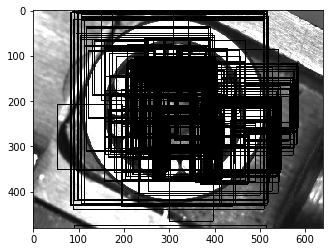

In [150]:
plt.imshow(draw_bounding_box(image1,max_C,max_R), cmap=cm.gray, vmin=0, vmax=255)

In [119]:
image.shape[1]**2*image.shape[0]

196608000

In [120]:
image.shape[1]*image.shape[0]

307200

In [67]:
count = 0
def find_circle(image,A,B):
    global count
    m = image.shape[0]
    n = image.shape[1]
    got_A = False
    got_B = False
    is_done = False
    for i in range(A[0],m):
        for j in range(0,n):
            if i==m-1 and j==n-1:
                is_done=True
                return None, None, A, B, None, is_done
            if i==A[0] and j<=A[1]:
                continue
            count+=1
            if image[i][j]==0:
                A = (i,j)
                got_A=True
                break
        if got_A:
            break
    
    
    for j in range(0,n):
        for i in range(A[0],m):
            if image[i][j]==0:
                B = (i,j)
                got_B=True
                break
        if got_B:
            break
    
    if got_A and got_B and is_center(A,B):
        C = (B[0],A[1])
        R = ecl_dist(A, C)
        circumference = circumference_coords(C,R)
        
        if is_circle(circumference, image):
            return circumference, R, A, B, C, is_done
    return None, None, A, B, None, None

In [18]:
def is_circle(circumference, image, error = 1):
    total = 0
    for i,j in list(circumference):
        if i<image.shape[0] and j<image.shape[1] and is_an_edge(image, (i,j), error):
            total+=1
            
    if total/len(circumference)>0.05:
        return True
    return False

In [16]:
def circumference_coords(C,R):
    degree = 0
    circumference = []
    while degree<360:
        xi = round(C[0]+R*math.cos(degree * math.pi / 180))
        xj = round(C[1]+R*math.sin(degree * math.pi / 180))
        circumference.append((xi, xj))
        degree+=0.01
    return set(circumference)

In [68]:
A = (0,0)
B = (0,0)
max_R = 0
max_C = None
max_circum = None
while True:
    circum, R, A, B, C, is_done = find_circle(edges, A, B)
    #print(R)
    if is_done:
        break
    if R is not None:
        if R>max_R:
            max_R = R
            max_C = C
            max_circum = circum